In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from neo import io
import quantities as pq

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [22]:
# Import the list of files to analyse

ramps_df = pd.read_excel('C://Users//cdixon//Documents//DataSynaptopathies/20181121_AMPA_RampDetails.xlsx')
ramps_df.dropna(how='all', inplace=True)
summary_df = pd.read_excel('C://Users//cdixon//Documents//DataSynaptopathies//2017Electrophysiology/825RigBackup/GluR2_KA_summary211118.xlsx',
                              sheetname='KA 1mM Heteromers Summary')
summary_df.dropna(how='all', inplace=True)
summary_df.reset_index(inplace=True)
summary_df['Record'] = summary_df['Record'].astype(str)
summary_df['Date'] = summary_df['Date'].astype(int).astype(str)


def make_filenames(summary=summary_df, ramps_df=ramps_df):
    summary_df['File'] = 'blank'
    for row in range(0, len(summary_df)):
        summary_df.loc[row, 'File'] = summary_df['Date'][row] + '_' + summary_df['Record'][row][:3]

        
make_filenames()
ramps_df = pd.merge(ramps_df, summary_df[['Mutant', 'File']], how='inner', on='File')
# ramps_df.sort_values('Mutant', inplace=True) # Do this for graphing
ramps_df.reset_index(drop=True, inplace=True)

ramps_df['Analysis_start']=ramps_df['Analysis_start'].replace(0, 1) #functions require -1s before start

# Note: ramps threshold here refers to classifying a ramp as control or drug, not identifying ramps

In [3]:
summary_df[summary_df['Mutant'] == 'V647L']

index    Date Mutant Record  KA Holding current  KA Amplitude  \
97      97  181004  V647L    002           97.656667   1003.988333   
104    104  181018  V647L    004           27.233333    721.666667   
138    138  181115  V647L    012          184.933333   2943.250000   
139    139  181115  V647L    013           66.500000   1807.466667   
140    140  181115  V647L    014         1055.000000    433.300000   
141    141  181115  V647L    015           79.533333    478.583333   

     Unnamed: 5 Unnamed: 6        File  
97          NaN        NaN  181004_002  
104         NaN        NaN  181018_004  
138         NaN        NaN  181115_012  
139         NaN        NaN  181115_013  
140         NaN        NaN  181115_014  
141         NaN        NaN  181115_015

In [4]:
ramps_df.loc[ramps_df['Mutant'] == 'V647L', :]

File      Date number  ramp threshold  Analysis_start  \
83   181004_002  181004.0    002          -500.0           160.0   
90   181018_004  181018.0    004          -500.0            30.0   
118  181115_012  181115.0    012         -2000.0            25.0   
119  181115_013  181115.0    013         -1200.0            20.0   
120  181115_015  181115.0    015          -400.0            25.0   

     Analysis_end Notes Mutant  
83          230.0   NaN  V647L  
90          120.0   NaN  V647L  
118          87.0   NaN  V647L  
119          78.0   NaN  V647L  
120          59.0   NaN  V647L

In [5]:
len(ramps_df)

167

In [6]:

print(ramps_df['Mutant'].value_counts())
ramps_df.tail()

WT        19
GRIA1     19
A639S     18
528Del    14
D611N     13
G609R     11
Q607E     10
F644L     10
T646N     10
I375V      9
P528T      9
D302G      7
W788L      7
G47E       6
V647L      5
Name: Mutant, dtype: int64


File      Date number  ramp threshold  Analysis_start  \
162  190308_003  190308.0    003          -300.0            82.0   
163  190308_011  190308.0    011          -400.0            20.0   
164  190308_012  190308.0    012         -1000.0            45.0   
165  190308_013  190308.0    013         -3000.0            20.0   
166  190308_014  190308.0    014          -600.0            45.0   

     Analysis_end Notes Mutant  
162         135.0   NaN  I375V  
163          60.0   NaN  I375V  
164          90.0   NaN  I375V  
165          60.0   NaN  I375V  
166          85.0   NaN  I375V

In [7]:

class Cell:
    '''Loads the data for one cell, as defined in the summary dataframe'''
    def __init__(self, filepath, df, row):
        start_ms = int(df['Analysis_start'][row]-1)*1000
        end_ms = int(df['Analysis_end'][row]+2)*1000
        r = io.WinEdrIO(filename=filepath)
        seg = r.read_segment(lazy=False, cascade=True,)
        I = seg.analogsignals[0]
        self.I = I[start_ms:end_ms]         
        if end_ms > len(I):  #keep in mind that I and self.I are different
            end_ms = len(I)
        print('total= ' , len(I), 'start=', start_ms, 'end=', end_ms)
        time = seg.analogsignals[0].times # warning: this can extend beyond the length of the recording;
        # can lead to len(t) > len(I)
        self.time = time[0:(end_ms - start_ms)] # In case the I is shorter than specified; need to keep t the same

        


def read_currentTime_batch(filepath, df, row):
    '''Returns time and current from WinEDR file, trimming the file according to df. Units are extracted; use .values if necessary'''
    start_ms = int(df['Analysis_start'][row]-1)*1000
    end_ms = int(df['Analysis_end'][row]+2)*1000
    r = io.WinEdrIO(filename=filepath)
    seg = r.read_segment(lazy=False, cascade=True,)
    I = seg.analogsignals[0]
    I = I[start_ms:end_ms] 
    print('total= ' , len(I), 'start=', start_ms, 'end=', end_ms)
    if (end_ms - start_ms) > len(I):
        end_ms = len(I)
    time = seg.analogsignals[0].times # warning: this can extend beyond the length of the recording;
    # can lead to len(t) > len(I)
    time = time[0:(end_ms - start_ms)] # This forces the len(I) and len(t) to be the same
    return (I, time)
    
    
def read_currentTime_single_file(filepath):
    '''reads signal for the whole file; does not require start and end time from dataFrame'''
    r = io.WinEdrIO(filename=filepath)
    seg = r.read_segment(lazy=False, cascade=True,)
    I = seg.analogsignals[0]
    time = seg.analogsignals[0].times
    return (I, time)

In [8]:
'''
Attempted to refactor to use the single cell processing function
Current fail: on 180405_003, doesn't identify drug ramps

'''


def Process_cells_batch (df=ramps_df, jump_threshold=50):
    df['RI'] = ''
    for row in range(0, len(df)): #len(df)
        print('Processing row ', row)

        process_cells_df(df, row)
        
        df['RI'][row] = RI
        
        print(filename, 'processed')
    df.to_excel('ramps_results.xlsx')

# Process_cells_batch (df=ramps_df, jump_threshold=50)

Processing 190308_011
total=  45000 start= 17000 end= 62000
Without duplicates:  [2021, 3821, 7322, 9203, 11003, 15377, 17177, 19369, 21169, 23554, 25354, 33215, 37332, 39150, 40950]
robust = [2021, 9203, 15377, 19369, 23554, 39150]
-400.0
control [2021, 9203, 39150]


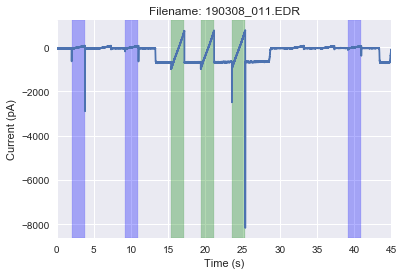

-400.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


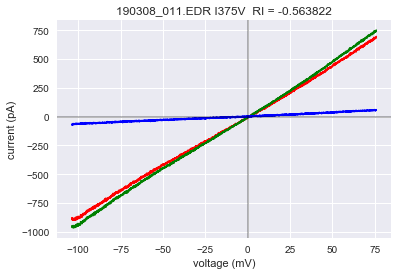

RI =  -0.563822
finished processing 190308_011.EDR
Processing 190308_012
total=  48000 start= 44000 end= 92000
Without duplicates:  [4350, 6150, 7907, 9707, 11467, 13267, 15609, 17644, 19444, 21762, 23562, 25570, 27370, 32370, 34170, 36112, 37912, 39795, 41595, 44640, 44678]
robust = [4350, 7907, 11467, 17644, 21762, 25570, 32370, 36112, 39795]
-1000.0
control [4350, 7907, 11467, 32370, 36112]


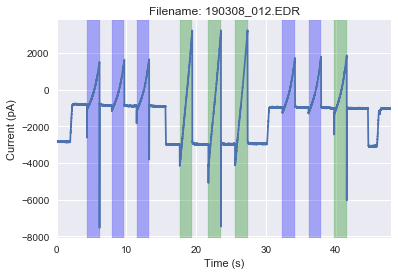

-1000.0


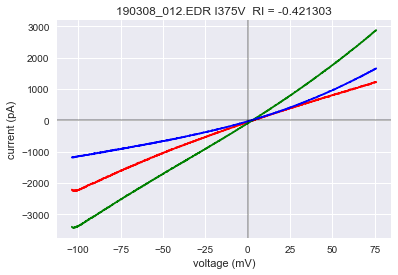

RI =  -0.421303
finished processing 190308_012.EDR
Processing 190308_013
total=  43000 start= 19000 end= 62000
Without duplicates:  [2081, 3881, 5706, 7506, 9444, 11244, 13938, 15996, 17796, 19865, 21665, 23424, 25224, 30102, 31902, 34279, 36079, 37961, 39761, 42080, 42140]
robust = [2081, 5706, 9444, 15996, 19865, 23424, 30102, 34279, 37961]
-3000.0
control [2081, 5706, 9444, 30102, 34279, 37961]


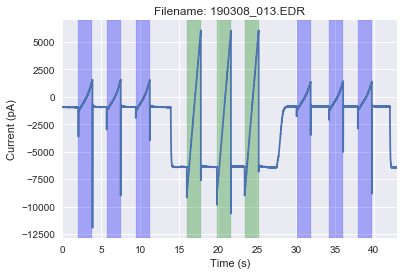

-3000.0


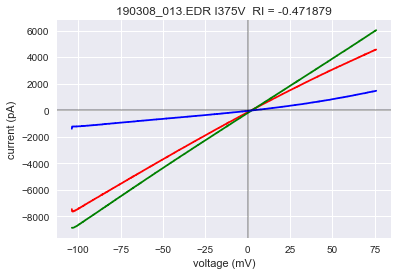

RI =  -0.471879
finished processing 190308_013.EDR
Processing 190308_014
total=  43000 start= 44000 end= 87000
Without duplicates:  [4469, 6269, 8343, 10143, 12084, 13884, 18259, 20059, 21942, 23742, 27434, 29234, 33672, 35472, 37297, 39097]
robust = [4469, 8343, 12084, 18259, 21942, 27434, 33672, 37297]
-600.0
control [4469, 8343, 12084, 33672, 37297]


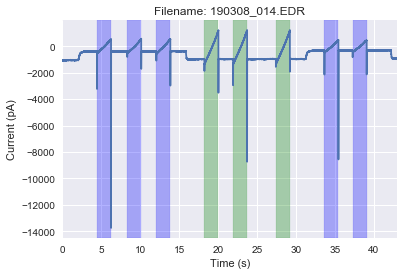

-600.0


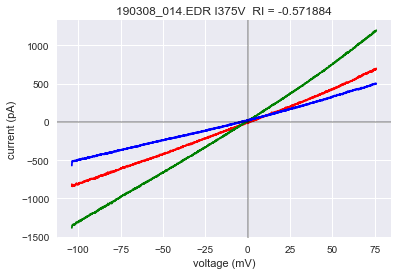

RI =  -0.571884
finished processing 190308_014.EDR


In [24]:

def process_cell(I, time, drug_threshold, filename, mutant = ' '):
    '''Suitable for individual or batch processing of ramp files
    Mutant can be left blank or filled in from the df if batch processing
    Packages functions for: finding ramps, classifying, subtracting, clculating RI,
    graphing for inspection of ramp classification, graph of ramps and outputting ramp data as csv'''
    
    jumps = find_jumps(data=I) #allows default jump threshold to default to 50. Not the same as drug threshold
    ramp_starts = ramp_start_robust(jumps)
    print('robust =', ramp_starts)
    
    c_ramp_starts, d_ramp_starts = control_or_drug(I, drug_threshold, ramp_starts) 
    print ('control', c_ramp_starts)
 
    plot_trace(time, I, filename, c_ramp_starts, d_ramp_starts)
    subtracted = subtracted_ramp(I, ramp_starts, drug_threshold)
    RI, pos, neg = rectification(subtracted)
    
    # this needs to be fed data from frame when used for batch
    graph_final_ramps(I, filename, mutant, subtracted, c_ramp_starts, d_ramp_starts, RI)#Is this really graphing new data???
    save_ramp_data(filename, I, time, subtracted, c_ramp_starts, d_ramp_starts)
    # df['RI'][row] = RI
    # Need to add return values?
    # Save c_ramp_starts, d_ramp_starts
    
    print('RI = ', RI)
    return subtracted, c_ramp_starts, d_ramp_starts, RI
    

#filepath = '180607_007.EDR'  # currently in this folder, full path not needed
#filename = '180607_007'
#drug_threshold = ramps_df['ramp threshold'][ramps_df['File'] == filename].values[0]

#I, time = read_currentTime_single_file(filepath)
#subtracted, c_ramp_starts, d_ramp_starts, RI = process_cell(I, time, drug_threshold, filename)


def process_cells_df(df, row):
    '''to proccess a single cell, but pulling from the dataframe'''
    filepath = df['File'][row]
    print('Processing', filepath)
    filename = df['File'][row] + '.EDR'
    I, time = read_currentTime_batch(filename, df, row)
    drug_threshold = df['ramp threshold'][row]
    process_cell(I, time, drug_threshold, filename, df['Mutant'][row])
    print('finished processing', filename)
    return I, time

for row in range(163,167):
    process_cells_df(ramps_df, row)

    

In [10]:

    
    
def save_ramp_data(filename, I, time, subtracted, c_ramp_starts, d_ramp_starts):
    # dump the 3 different ramps into a CSV and save it
    # Need to use the ramp starts to pull out the full value of the ramp
    
    sub = pd.DataFrame(subtracted, columns=['Subtracted'])
    drug = pd.DataFrame(average_ramps(I, d_ramp_starts), columns=['Drug'])
    con = pd.DataFrame(average_ramps(I, c_ramp_starts), columns=['Control'])
    rampsSummary = pd.concat([sub, drug, con], axis=1)
    save_as = filename + 'RampSummary.csv'
    rampsSummary.to_csv(save_as)
    return rampsSummary

#save_ramp_data(filename, I, time, subtracted, c_ramp_starts, d_ramp_starts)


total rows: 167
Processing row  0
total=  103792 start= 29000 end= 92000
Without duplicates:  [1756, 3556, 6939, 8739, 10992, 12792, 18416, 20216, 22097, 23897, 25842, 27642, 34707, 36507, 38759, 40559, 42691, 44491, 51427, 53227, 54670, 56470, 58476, 60276]
robust = [1756, 6939, 10992, 18416, 22097, 25842, 34707, 38759, 42691, 51427, 54670, 58476]
-1300.0
time len= 63000 I len= 63000


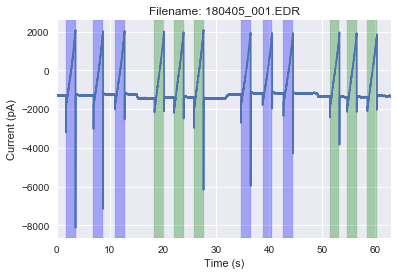

-1300.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


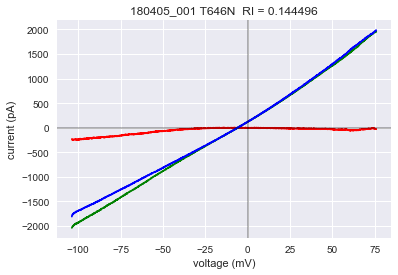

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


180405_001.EDR processed
total rows: 167
Processing row  1
total=  157684 start= 24000 end= 92000
Without duplicates:  [5318, 7118, 8500, 10300, 12121, 13921, 18534, 20359, 22159, 22333, 22765, 23004, 24481, 24841, 26281, 26926, 28970, 30834, 32174, 33834, 37146, 38946, 43004, 45259, 47059, 52310, 54110, 56114, 57914, 58533, 59921, 61721]
robust = [5318, 8500, 12121, 20359, 24481, 37146, 45259, 52310, 56114, 59921]
-1000.0
time len= 68000 I len= 68000


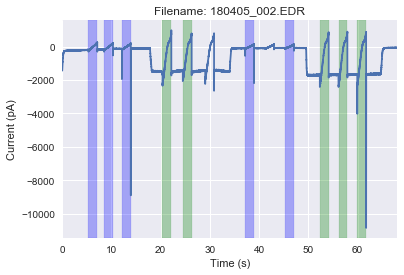

-1000.0


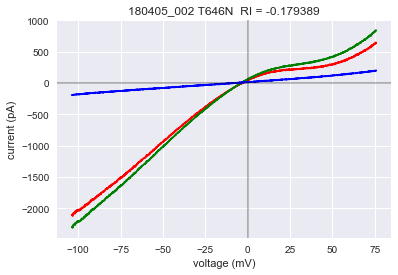

180405_002.EDR processed
total rows: 167
Processing row  2
total=  105788 start= 24000 end= 90000
Without duplicates:  [3637, 5437, 7883, 9683, 11938, 13738, 21045, 22845, 24732, 26532, 28595, 30395, 36964, 38764, 41144, 42944, 45007, 46807, 52374, 54174, 56183, 57983, 60110, 61910]
robust = [3637, 7883, 11938, 21045, 24732, 28595, 36964, 41144, 45007, 52374, 56183, 60110]
-500.0
time len= 66000 I len= 66000


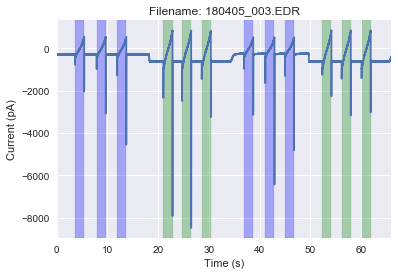

-500.0


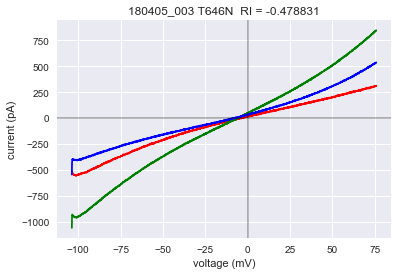

180405_003.EDR processed
total rows: 167
Processing row  3
total=  221556 start= 89000 end= 160000
Without duplicates:  [3405, 5205, 8019, 9819, 12641, 14441, 16571, 18371, 23685, 25485, 27424, 29224, 31293, 33093, 39473, 41273, 43400, 45200, 47647, 49447, 54573, 56373, 58378, 60178, 62374, 64174]
robust = [3405, 8019, 12641, 16571, 23685, 27424, 31293, 39473, 43400, 47647, 54573, 58378, 62374]
-1000.0
time len= 71000 I len= 71000


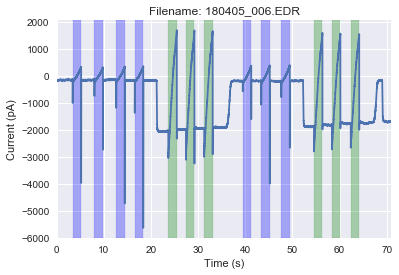

-1000.0


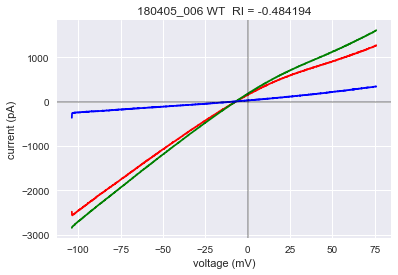

180405_006.EDR processed
total rows: 167
Processing row  4
total=  121756 start= 44000 end= 107000
Without duplicates:  [2853, 4653, 6597, 8397, 10340, 12140, 19641, 21441, 23007, 24807, 26378, 28178, 33930, 35730, 37671, 39471, 41415, 43215, 48845, 50540, 50645, 52399, 53911, 54199, 56334, 57801, 58079, 58134]
robust = [2853, 6597, 10340, 19641, 23007, 26378, 33930, 37671, 41415, 48845, 52399, 56334]
-1000.0
time len= 63000 I len= 63000


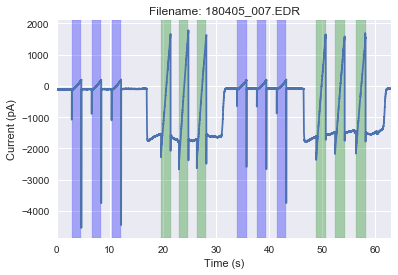

-1000.0


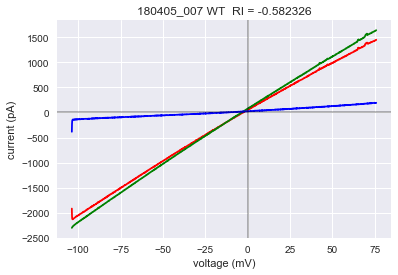

180405_007.EDR processed
total rows: 167
Processing row  5
total=  215568 start= 69000 end= 137000
Without duplicates:  [3189, 4989, 6991, 8791, 10799, 12599, 15271, 18105, 19905, 21906, 23706, 26398, 28198, 34324, 36124, 37946, 39746, 41686, 43486, 49673, 51473, 53605, 55405, 58161, 59961]
robust = [3189, 6991, 10799, 18105, 21906, 26398, 34324, 37946, 41686, 49673, 53605, 58161]
-1000.0
time len= 68000 I len= 68000


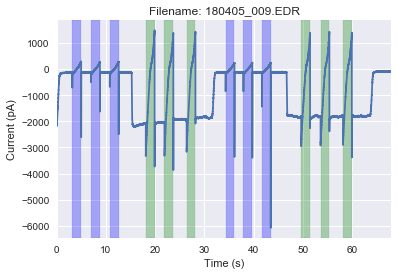

-1000.0


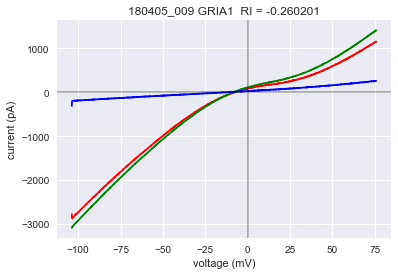

180405_009.EDR processed
total rows: 167
Processing row  6
total=  121756 start= 19000 end= 112000
Without duplicates:  [4148, 5948, 8138, 9938, 11950, 13750, 31225, 33025, 34969, 36769, 38902, 40702, 46951, 48751, 50881, 52681, 54694, 56494, 63489, 65289, 67483, 69283, 71347, 73147, 79903, 81703, 83706, 85506, 87453, 89253]
robust = [4148, 8138, 11950, 31225, 34969, 38902, 46951, 50881, 54694, 63489, 67483, 71347, 79903, 83706, 87453]
-500.0
time len= 93000 I len= 93000


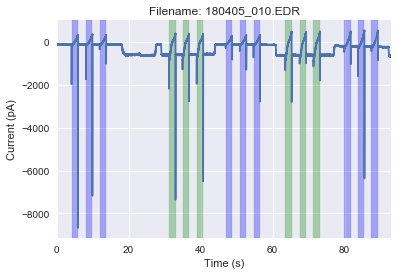

-500.0


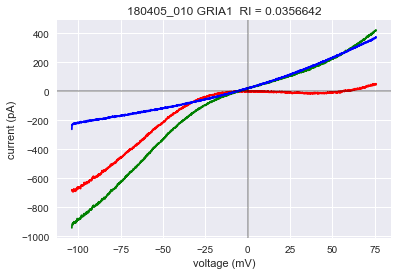

180405_010.EDR processed
total rows: 167
Processing row  7
total=  145708 start= 34000 end= 127000
Without duplicates:  [2558, 4358, 6305, 8105, 10110, 11910, 13406, 16036, 16940, 18471, 20271, 26397, 28197, 30451, 32251, 34320, 36120, 43186, 44986, 46987, 48787, 50795, 52595, 59348, 61148, 62431, 63338, 65138, 67459, 69259, 86923, 88723]
robust = [2558, 6305, 10110, 18471, 26397, 30451, 34320, 43186, 46987, 50795, 59348, 63338, 67459, 86923]
-1500.0
time len= 93000 I len= 93000


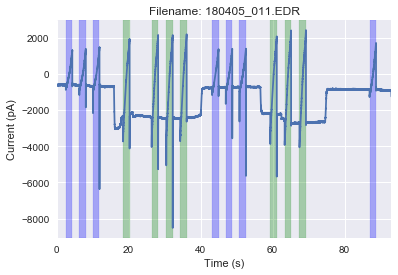

-1500.0


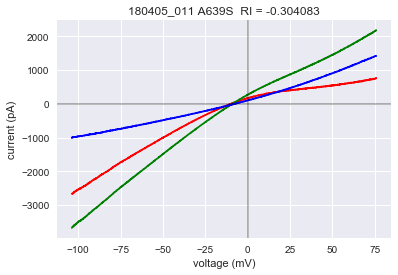

180405_011.EDR processed
total rows: 167
Processing row  8
total=  125748 start= 32000 end= 102000
Without duplicates:  [2686, 4486, 6368, 8168, 9986, 11786, 16379, 19096, 20896, 22780, 24580, 26147, 27947, 36318, 38118, 40063, 41864, 43743, 45543, 50165, 53292, 55092, 56975, 58775, 60597, 62397]
robust = [2686, 6368, 9986, 19096, 22780, 26147, 36318, 43743, 53292, 56975, 60597]
-1000.0
time len= 70000 I len= 70000


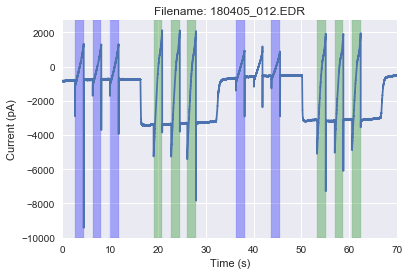

-1000.0


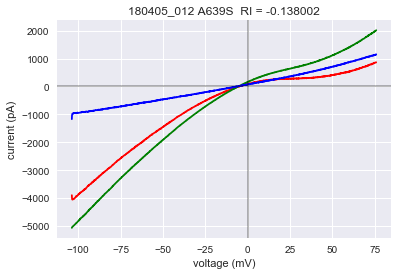

180405_012.EDR processed
total rows: 167
Processing row  9
total=  157684 start= 69000 end= 142000
Without duplicates:  [4316, 6116, 8113, 9913, 11733, 13533, 19036, 20836, 22279, 24079, 25897, 27697, 33704, 35504, 37254, 39054, 40937, 42737, 47861, 49661, 51483, 53283, 55104, 56904, 61846, 63646, 65084, 66884, 68707, 70507]
robust = [4316, 8113, 11733, 19036, 22279, 25897, 33704, 37254, 40937, 47861, 51483, 55104, 61846, 65084, 68707]
-1500.0
time len= 73000 I len= 73000


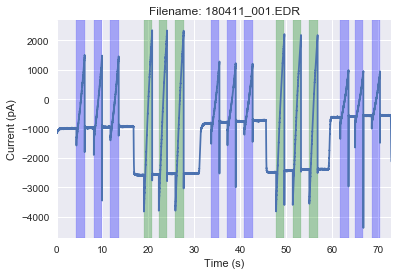

-1500.0


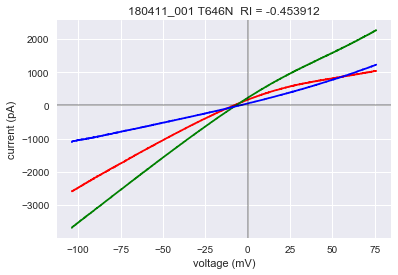

180411_001.EDR processed
total rows: 167
Processing row  10
total=  103792 start= 19000 end= 57000
Without duplicates:  [4140, 5940, 7884, 9684, 11693, 13493, 18453, 21489, 23289, 25420, 27220, 29105, 30804, 30905, 33677, 37215]
robust = [4140, 7884, 11693, 21489, 25420, 29105]
-1500.0
time len= 38000 I len= 38000


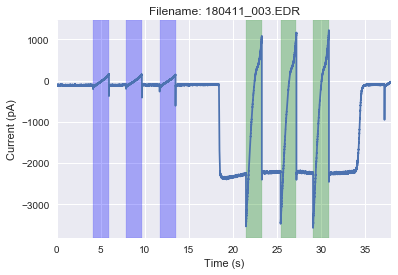

-1500.0


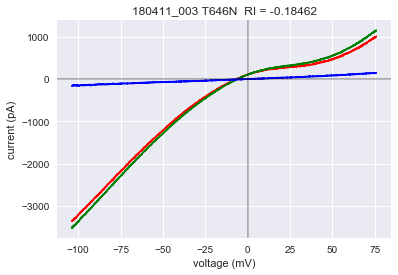

180411_003.EDR processed
total rows: 167
Processing row  11
total=  105788 start= 21000 end= 90000
Without duplicates:  [3386, 5186, 7940, 9740, 13432, 15232, 21793, 23593, 25475, 27275, 29099, 30899, 35902, 37702, 40327, 42127, 44388, 46188, 52369, 54169, 56176, 57976, 59983, 61783]
robust = [3386, 7940, 13432, 21793, 25475, 29099, 35902, 40327, 44388, 52369, 56176, 59983]
-1500.0
time len= 69000 I len= 69000


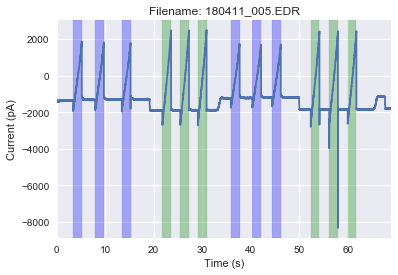

-1500.0


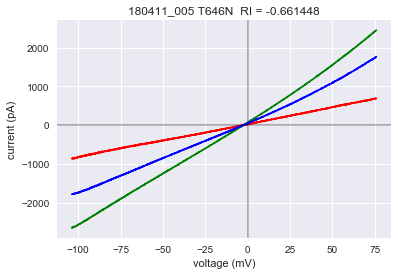

180411_005.EDR processed
total rows: 167
Processing row  12
total=  107784 start= 20000 end= 87000
Without duplicates:  [4454, 6254, 8010, 9810, 11626, 13426, 18368, 20168, 22049, 23849, 25854, 27654, 33781, 35581, 37466, 39266, 41266, 43066, 48071, 49871, 51750, 53550, 56119, 57919]
robust = [4454, 8010, 11626, 18368, 22049, 25854, 33781, 37466, 41266, 48071, 51750, 56119]
-500.0
time len= 67000 I len= 67000


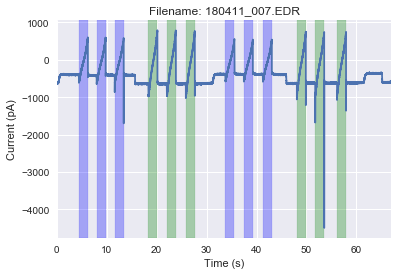

-500.0


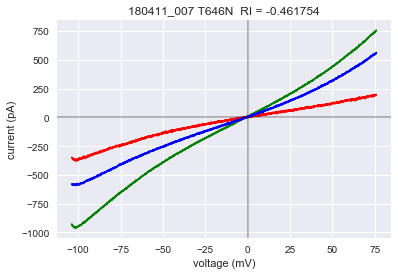

180411_007.EDR processed
total rows: 167
Processing row  13
total=  143712 start= 49000 end= 129000
Without duplicates:  [6902, 8702, 10523, 12323, 14332, 16132, 19502, 22009, 23809, 25749, 27549, 30990, 32790, 38541, 40341, 42351, 44151, 45907, 47707, 50652, 52705, 54505, 56386, 58186, 60193, 61993, 67557, 69357, 71299, 73099, 74858, 76658]
robust = [6902, 10523, 14332, 22009, 25749, 30990, 38541, 42351, 45907, 52705, 56386, 60193, 67557, 71299, 74858]
-1500.0
time len= 80000 I len= 80000


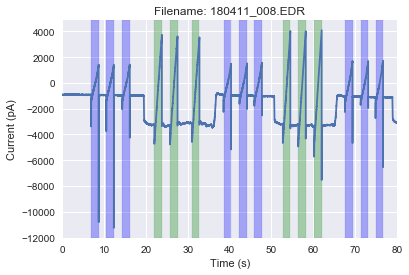

-1500.0


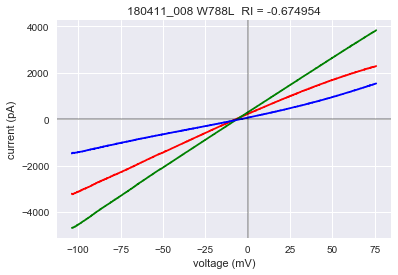

180411_008.EDR processed
total rows: 167
Processing row  14
total=  85828 start= 17000 end= 75000
Without duplicates:  [2833, 4633, 6953, 8753, 10821, 12621, 17518, 20743, 22543, 24929, 26729, 28857, 30657, 32723, 34523, 43023, 44823, 46825, 48625, 50513, 52313, 56763, 56782]
robust = [2833, 6953, 10821, 20743, 24929, 28857, 32723, 43023, 46825, 50513]
-1000.0
time len= 58000 I len= 58000


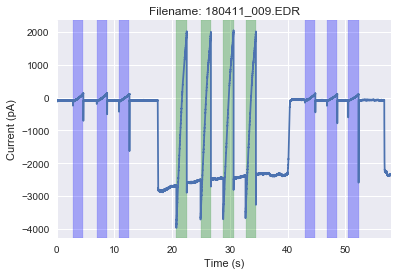

-1000.0


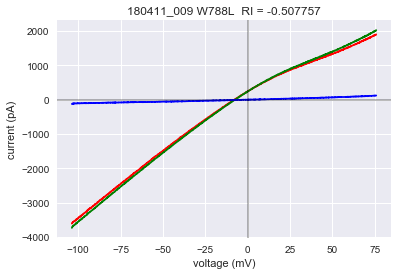

180411_009.EDR processed
total rows: 167
Processing row  15
total=  117764 start= 18000 end= 100000
Without duplicates:  [3519, 5319, 7328, 9128, 11571, 13371, 19098, 21740, 23540, 25484, 27284, 29477, 31277, 36902, 38702, 40773, 42573, 44643, 46443, 49309, 52132, 53932, 55753, 57553, 59373, 61173, 68976, 70776, 72600, 74400, 76219, 78019, 80490, 80506]
robust = [3519, 7328, 11571, 21740, 25484, 29477, 36902, 40773, 44643, 52132, 55753, 59373, 68976, 72600, 76219]
-1000.0
time len= 82000 I len= 82000


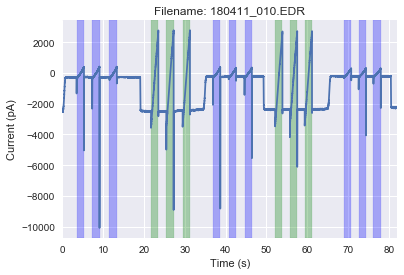

-1000.0


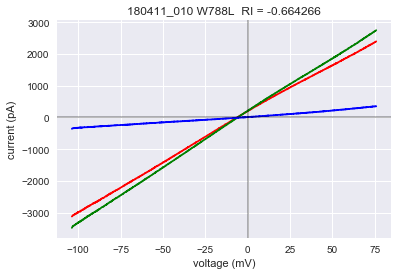

180411_010.EDR processed
total rows: 167
Processing row  16
total=  131736 start= 31000 end= 102000
Without duplicates:  [6184, 7984, 9676, 11476, 13297, 15097, 19600, 21400, 23405, 25205, 27400, 29200, 37074, 38874, 40753, 42553, 44439, 46239, 50988, 52788, 54790, 56590, 58662, 60462]
robust = [6184, 9676, 13297, 19600, 23405, 27400, 37074, 40753, 44439, 50988, 54790, 58662]
-400.0
time len= 71000 I len= 71000


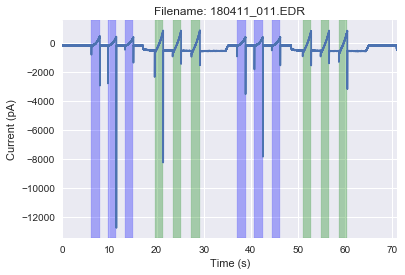

-400.0


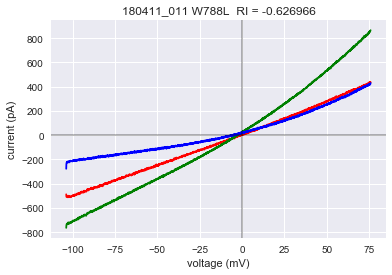

180411_011.EDR processed
total rows: 167
Processing row  17
total=  115768 start= 22000 end= 97000
Without duplicates:  [3947, 5747, 7051, 7754, 9554, 11435, 13235, 17590, 21357, 23157, 25661, 27461, 29907, 31707, 38954, 40754, 42697, 44497, 46066, 47866, 51925, 54302, 56102, 58111, 59911, 61920, 63720, 74495, 74509]
robust = [3947, 7754, 11435, 21357, 25661, 29907, 38954, 42697, 46066, 54302, 58111, 61920]
-1500.0
time len= 75000 I len= 75000


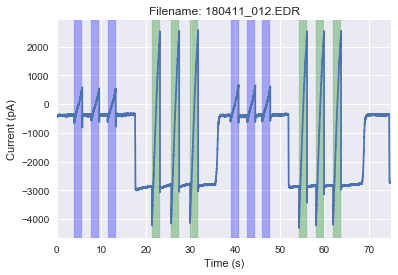

-1500.0


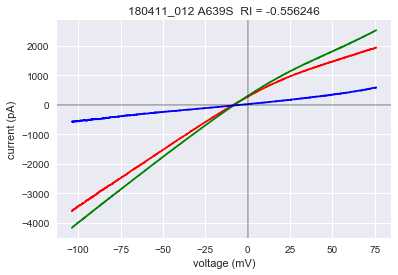

180411_012.EDR processed
total rows: 167
Processing row  18
total=  125748 start= 73000 end= 108000
Without duplicates:  [2376, 4176, 6178, 7978, 10110, 11910, 18969, 20769, 22713, 24513, 26525, 28325]
robust = [2376, 6178, 10110, 18969, 22713, 26525]
-1500.0
time len= 35000 I len= 35000


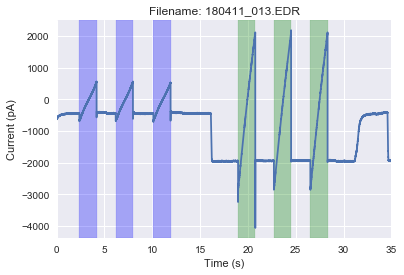

-1500.0


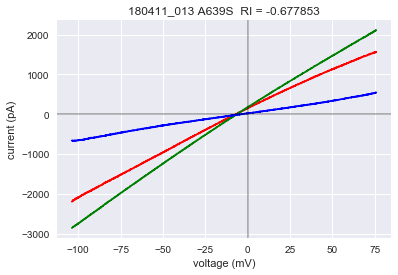

180411_013.EDR processed
total rows: 167
Processing row  19
total=  105788 start= 19000 end= 91000
Without duplicates:  [4198, 5998, 8129, 9929, 11937, 13737, 19732, 21532, 23542, 25342, 27284, 29084, 36147, 37947, 39768, 41568, 43571, 45371, 48253, 50053, 55365, 57165, 59422, 61222, 63726, 65526]
robust = [4198, 8129, 11937, 19732, 23542, 27284, 36147, 39768, 43571, 48253, 55365, 59422, 63726]
-1000.0
time len= 72000 I len= 72000


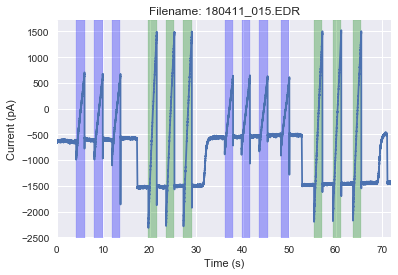

-1000.0


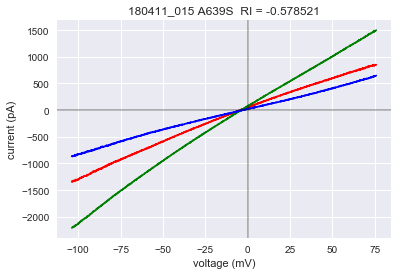

180411_015.EDR processed
total rows: 167
Processing row  20
total=  117764 start= 19000 end= 100000
Without duplicates:  [4893, 6693, 8698, 10498, 12504, 14304, 19006, 23114, 24914, 26919, 28719, 30974, 32774, 42020, 43820, 45825, 47625, 49820, 51620, 63612, 65412, 68163, 69963, 72783, 74583, 79144]
robust = [4893, 8698, 12504, 23114, 26919, 30974, 42020, 45825, 49820, 63612, 68163, 72783]
-1500.0
time len= 81000 I len= 81000


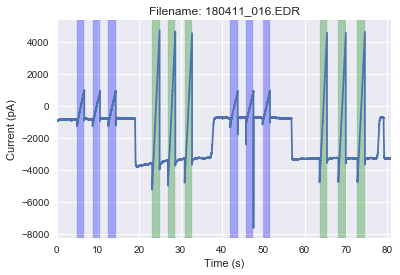

-1500.0


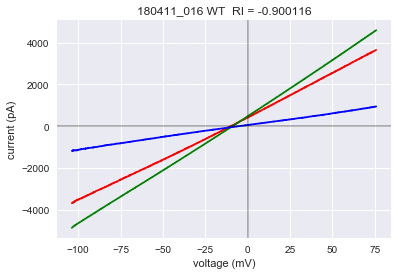

180411_016.EDR processed
total rows: 167
Processing row  21
total=  169660 start= 19000 end= 162000
Without duplicates:  [1710, 3510, 5640, 7440, 9447, 11247, 19059, 20859, 22300, 24100, 26174, 27974, 34847, 36647, 38463, 40263, 42518, 44318, 52131, 53931, 56123, 57923, 59867, 61667, 99062, 108919, 110719, 112593, 114393, 116151, 117951, 122703, 124503, 126446, 128246, 130253, 132053, 132054]
robust = [1710, 5640, 9447, 19059, 22300, 26174, 34847, 38463, 42518, 52131, 56123, 59867, 108919, 112593, 116151, 122703, 126446, 130253]
-1500.0
time len= 143000 I len= 143000


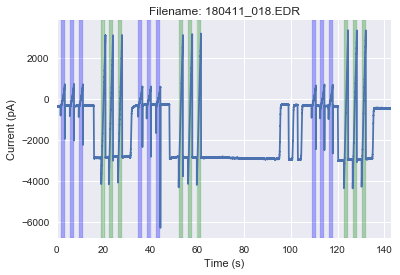

-1500.0


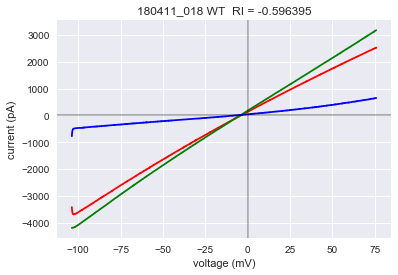

180411_018.EDR processed
total rows: 167
Processing row  22
total=  99800 start= 20000 end= 87000
Without duplicates:  [3458, 5258, 9061, 11069, 12869, 16482, 16815, 17706, 17903, 18402, 18799, 20674, 20902, 21056, 21545, 22552, 22845, 24412, 24682, 26384, 26834, 27854, 29654, 29994, 30695, 32572, 37890, 40022, 41822, 43888, 45688, 49516, 50163, 51035, 51255, 53055, 53628, 53867, 54729, 54997, 56797, 57085, 58129, 58304, 58681, 58788, 60481, 60779, 62979, 63116, 66216, 66581, 66981]
robust = [3458, 11069, 27854, 40022, 43888, 51255, 54997, 58681]
-500.0
time len= 67000 I len= 67000


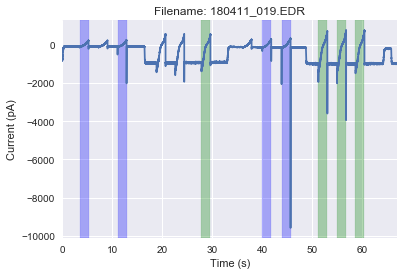

-500.0


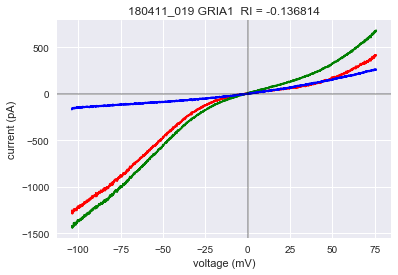

180411_019.EDR processed
total rows: 167
Processing row  23
total=  109780 start= 31000 end= 96000
Without duplicates:  [3642, 5442, 7264, 9064, 10878, 12678, 16409, 18742, 20542, 23108, 24908, 26605, 28405, 33779, 35579, 37585, 39385, 41330, 43130, 45997, 49194, 50994, 53002, 54802, 57059, 58859, 59910]
robust = [3642, 7264, 10878, 18742, 23108, 26605, 33779, 37585, 41330, 49194, 53002, 57059]
-1500.0
time len= 65000 I len= 65000


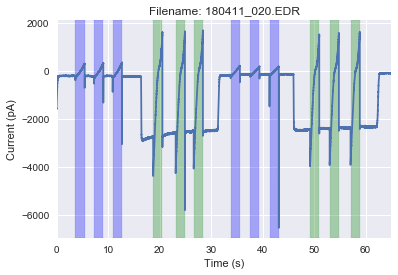

-1500.0


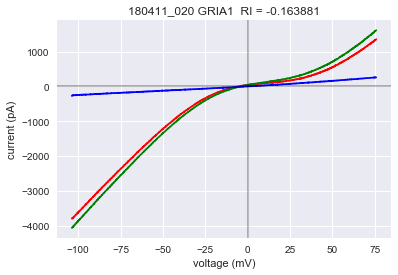

180411_020.EDR processed
total rows: 167
Processing row  24
total=  93812 start= 34000 end= 93812
Without duplicates:  [6550, 8350, 10544, 12344, 14538, 16338, 28203, 30003, 32819, 34619, 37000, 38800, 46673, 48473, 51293, 53093, 56286, 58086]
robust = [6550, 10544, 14538, 28203, 32819, 37000, 46673, 51293, 56286]
-150.0
time len= 59812 I len= 59812


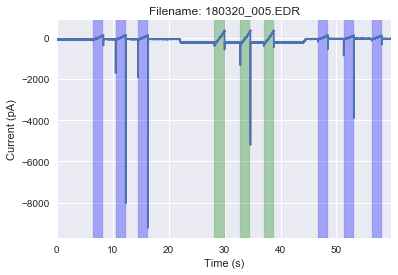

-150.0


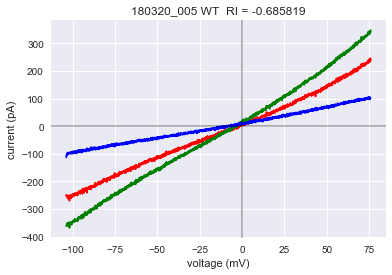

180320_005.EDR processed
total rows: 167
Processing row  25
total=  145708 start= 39000 end= 128000
Without duplicates:  [2613, 4413, 6734, 8534, 10973, 12773, 22399, 24199, 33126, 34926, 38433, 40233, 48163, 49963, 52907, 54707, 58399, 60199, 67134, 68934, 71191, 72991, 75372, 77172]
robust = [2613, 6734, 10973, 22399, 33126, 38433, 48163, 52907, 58399, 67134, 71191, 75372]
-1000.0
time len= 89000 I len= 89000


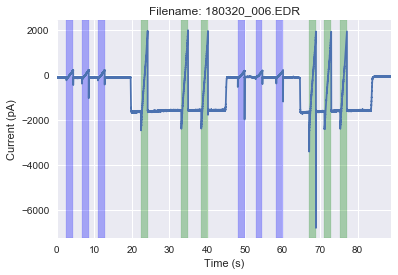

-1000.0


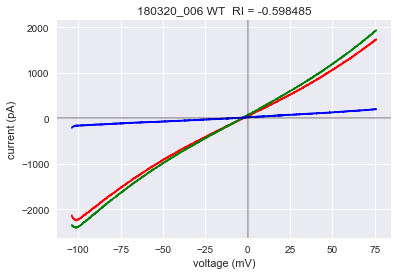

180320_006.EDR processed
total rows: 167
Processing row  26
total=  203592 start= 126000 end= 179000
Without duplicates:  [5031, 6831, 9023, 10823, 14327, 16127, 22442, 24242, 27493, 29293, 31864, 33664, 36292, 38092, 44348, 46148, 49522, 51322]
robust = [5031, 9023, 14327, 22442, 27493, 31864, 36292, 44348, 49522]
-400.0
time len= 53000 I len= 53000


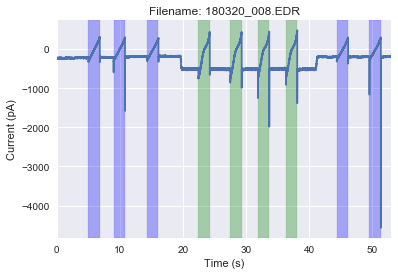

-400.0


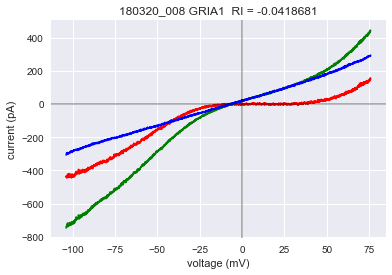

180320_008.EDR processed
total rows: 167
Processing row  27
total=  149700 start= 54000 end= 149700
Without duplicates:  [4772, 6572, 9017, 10817, 12888, 14688, 26378, 29049, 30849, 32670, 34470, 36662, 38462, 43896, 45696, 47893, 49693, 51761, 53561, 64654, 69394, 74197, 81776, 83576, 85205, 87005, 89325, 91125, 94007, 94058]
robust = [4772, 9017, 12888, 29049, 32670, 36662, 43896, 47893, 51761, 81776, 85205, 89325]
-1000.0
time len= 95700 I len= 95700


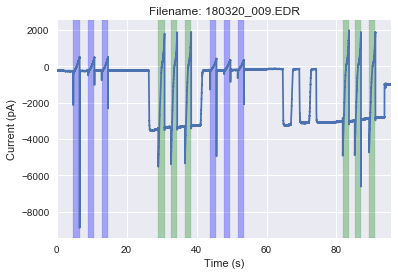

-1000.0


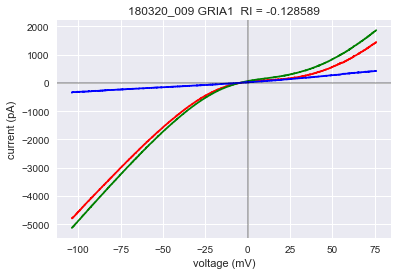

180320_009.EDR processed
total rows: 167
Processing row  28
total=  141716 start= 44000 end= 124000
Without duplicates:  [6413, 8213, 12465, 14265, 16331, 18131, 23820, 25620, 28129, 29929, 31749, 33549, 40668, 42468, 44600, 46400, 48599, 50399, 56767, 58567, 61449, 63249, 65694, 67494]
robust = [6413, 12465, 16331, 23820, 28129, 31749, 40668, 44600, 48599, 56767, 61449, 65694]
-2000.0
time len= 80000 I len= 80000


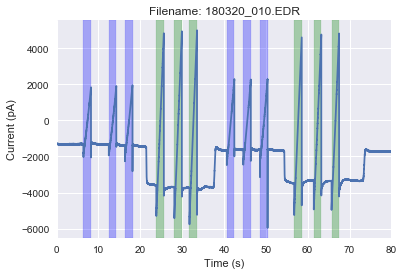

-2000.0


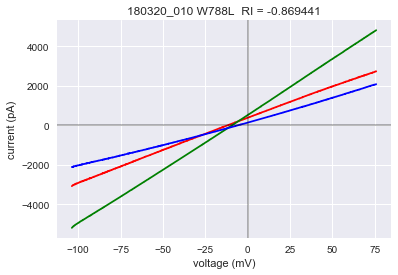

180320_010.EDR processed
total rows: 167
Processing row  29
total=  117764 start= 44000 end= 107000
Without duplicates:  [5221, 7021, 9658, 11458, 18452, 20252, 21759, 23559, 25126, 26926, 32490, 34290, 36109, 37909, 39853, 41653, 45417, 48719, 50519, 52583, 54383, 56269, 58069]
robust = [5221, 9658, 18452, 21759, 25126, 32490, 36109, 39853, 48719, 52583, 56269]
-2000.0
time len= 63000 I len= 63000


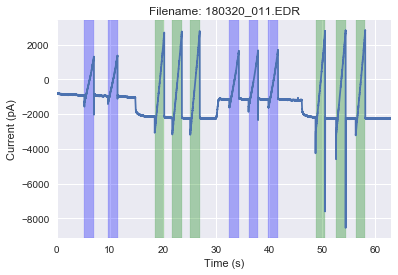

-2000.0


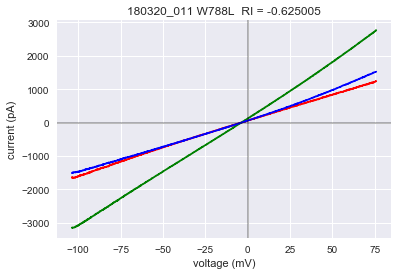

180320_011.EDR processed
total rows: 167
Processing row  30
total=  113772 start= 25000 end= 113772
Without duplicates:  [6127, 7927, 10002, 11802, 13929, 15729, 21603, 23403, 25222, 27022, 28840, 30640, 35893, 37693, 39761, 41561, 43255, 45055, 50304, 52104, 54366, 56166, 58418, 60218]
robust = [6127, 10002, 13929, 21603, 25222, 28840, 35893, 39761, 43255, 50304, 54366, 58418]
-500.0
time len= 88772 I len= 88772


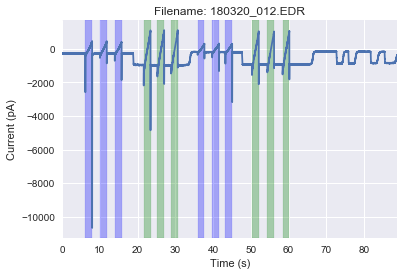

-500.0


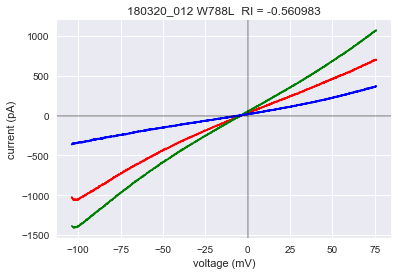

180320_012.EDR processed
total rows: 167
Processing row  31
total=  155688 start= 39000 end= 118000
Without duplicates:  [1306, 6058, 7858, 10239, 12039, 15046, 16846, 23407, 25207, 26848, 27151, 28951, 30194, 31020, 32820, 39509, 41309, 43624, 45424, 47495, 49295, 56166, 57966, 59848, 61648, 63968, 65768, 68273, 70073]
robust = [6058, 10239, 15046, 23407, 27151, 31020, 39509, 43624, 47495, 56166, 59848, 63968, 68273]
-500.0
time len= 79000 I len= 79000


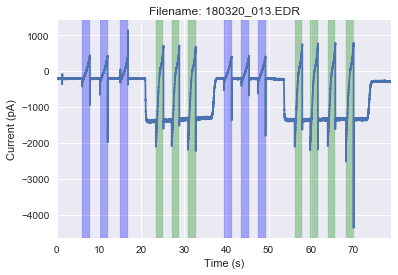

-500.0


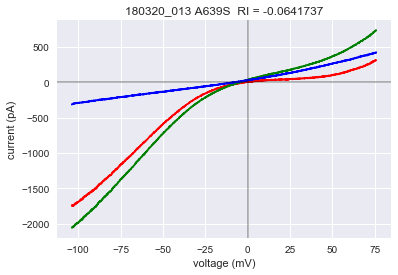

180320_013.EDR processed
total rows: 167
Processing row  32
total=  305388 start= 34000 end= 113000
Without duplicates:  [3805, 5605, 12354, 14154, 21903, 23703, 30637, 32437, 33944, 35744, 37437, 39237, 43091, 46862, 48662, 51174, 52974, 54598, 56398, 62273, 64073, 65958, 67758, 69886, 71686]
robust = [3805, 12354, 21903, 30637, 33944, 37437, 46862, 51174, 54598, 62273, 65958, 69886]
-300.0
time len= 79000 I len= 79000


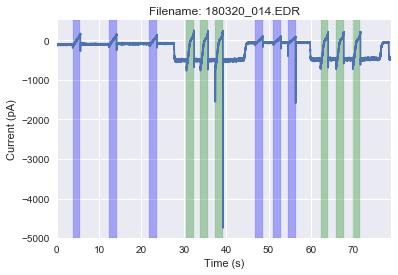

-300.0


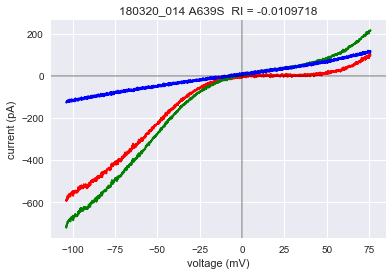

180320_014.EDR processed
total rows: 167
Processing row  33
total=  135728 start= 39000 end= 120000
Without duplicates:  [679, 1205, 5886, 7686, 10224, 12024, 15024, 16824, 21892, 25013, 26813, 29502, 31302, 34185, 35985, 42792, 44592, 49097, 50897, 54273, 56073, 62260, 62386, 64186, 66514, 67129, 68929, 71194, 71438, 73238]
robust = [5886, 10224, 15024, 25013, 29502, 34185, 42792, 49097, 54273, 62386, 67129, 71438]
-1000.0
time len= 81000 I len= 81000


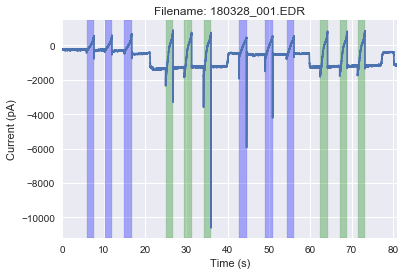

-1000.0


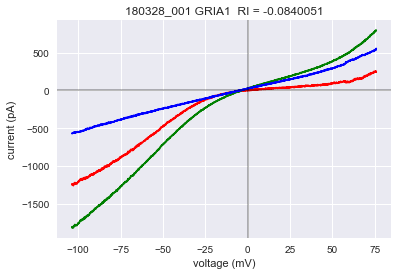

180328_001.EDR processed
total rows: 167
Processing row  34
total=  191616 start= 66000 end= 148000
Without duplicates:  [5064, 6864, 9367, 11167, 13485, 15285, 23219, 25019, 27218, 29018, 31271, 33071, 40444, 42244, 44312, 46112, 48368, 50168, 56483, 58283, 59848, 61648, 63720, 65520]
robust = [5064, 9367, 13485, 23219, 27218, 31271, 40444, 44312, 48368, 56483, 59848, 63720]
-300.0
time len= 82000 I len= 82000


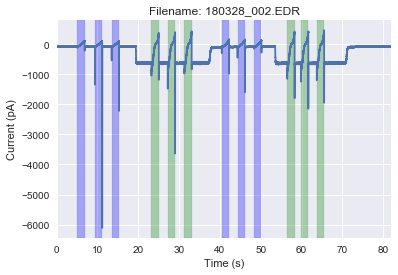

-300.0


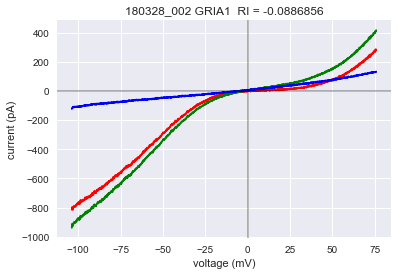

180328_002.EDR processed
total rows: 167
Processing row  35
total=  145708 start= 20000 end= 95000
Without duplicates:  [10259, 12059, 14251, 16051, 18247, 18442, 20047, 23109, 27040, 28840, 31224, 33024, 35650, 37450, 43824, 45624, 46054, 47695, 49495, 51251, 53051, 59926, 61726, 63230, 65030, 66978, 68778]
robust = [10259, 14251, 18247, 27040, 31224, 35650, 43824, 47695, 51251, 59926, 63230, 66978]
-500.0
time len= 75000 I len= 75000


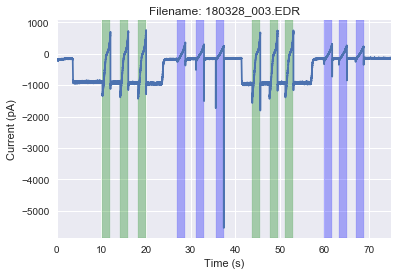

-500.0


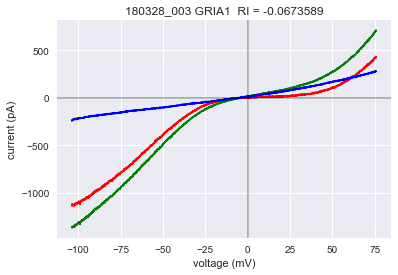

180328_003.EDR processed
total rows: 167
Processing row  36
total=  293412 start= 59000 end= 182000
Without duplicates:  [1298, 11935, 13735, 20111, 21911, 25105, 26905, 31264, 45630, 47430, 51290, 56179, 57979, 62544, 66975, 68775, 71030, 72830, 74462, 76262, 85445, 87245, 89005, 90805, 92368, 94168, 96969, 99422, 101222, 104038, 105838, 107534, 109334]
robust = [11935, 20111, 25105, 45630, 56179, 66975, 71030, 74462, 85445, 89005, 92368, 99422, 104038, 107534]
-1000.0
time len= 123000 I len= 123000


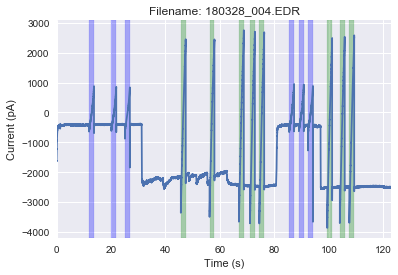

-1000.0


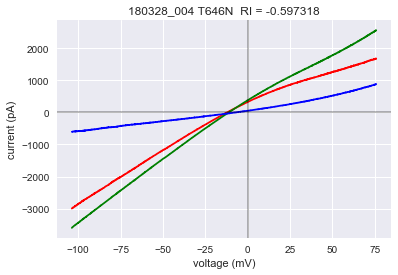

180328_004.EDR processed
total rows: 167
Processing row  37
total=  293412 start= 59000 end= 182000
Without duplicates:  [1298, 11935, 13735, 20111, 21911, 25105, 26905, 31264, 45630, 47430, 51290, 56179, 57979, 62544, 66975, 68775, 71030, 72830, 74462, 76262, 85445, 87245, 89005, 90805, 92368, 94168, 96969, 99422, 101222, 104038, 105838, 107534, 109334]
robust = [11935, 20111, 25105, 45630, 56179, 66975, 71030, 74462, 85445, 89005, 92368, 99422, 104038, 107534]
-1000.0
time len= 123000 I len= 123000


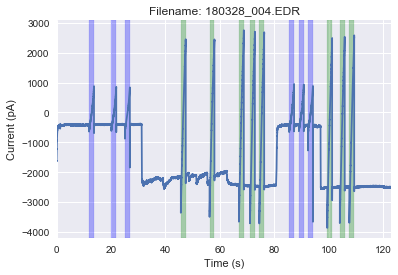

-1000.0


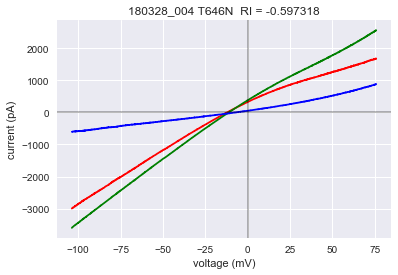

180328_004.EDR processed
total rows: 167
Processing row  38
total=  61876 start= 1000 end= 61876
Without duplicates:  [3544, 5344, 7034, 8834, 11470, 13270, 16598, 19334, 21134, 23076, 24876, 26816, 28616, 35930, 37730, 39673, 41473, 42977, 44777, 48032, 50217, 52017, 53524, 55324, 57144, 58944]
robust = [3544, 7034, 11470, 19334, 23076, 26816, 35930, 39673, 42977, 50217, 53524, 57144]
-2000.0
time len= 60876 I len= 60876


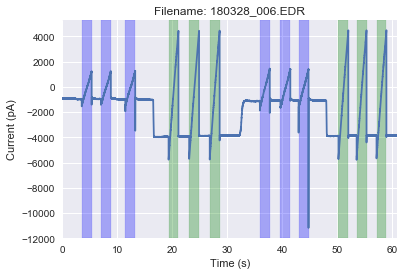

-2000.0


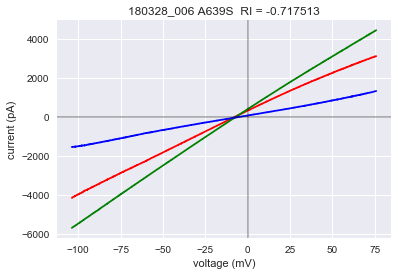

180328_006.EDR processed
total rows: 167
Processing row  39
total=  85828 start= 0 end= 72000
Without duplicates:  [1925, 3725, 5984, 7784, 9792, 11592, 25013, 26813, 28765, 30565, 32690, 34490, 40990, 42790, 44608, 46408, 48542, 50342, 53641, 55347, 57147, 59272, 61072, 63207, 65007]
robust = [1925, 5984, 9792, 25013, 28765, 32690, 40990, 44608, 48542, 55347, 59272, 63207]
-500.0
time len= 72000 I len= 72000


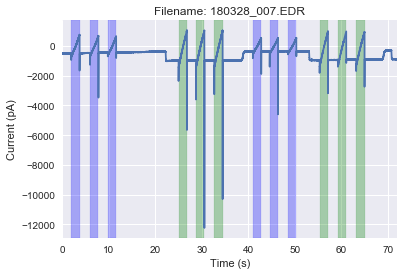

-500.0


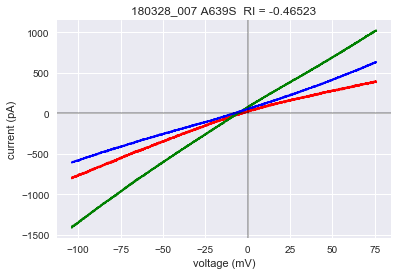

180328_007.EDR processed
total rows: 167
Processing row  40
total=  91816 start= 0 end= 76000
Without duplicates:  [1427, 3227, 5859, 7659, 9664, 11464, 17686, 21773, 23573, 25956, 27756, 30200, 32000, 38930, 40730, 42860, 44660, 46728, 48528, 54158, 55958, 58025, 59825, 62890, 64690]
robust = [1427, 5859, 9664, 21773, 25956, 30200, 38930, 42860, 46728, 54158, 58025, 62890]
-800.0
time len= 76000 I len= 76000


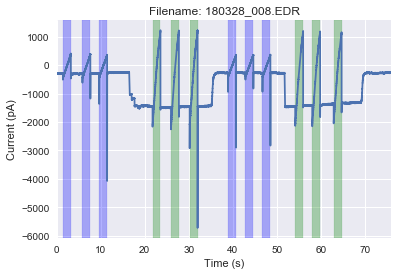

-800.0


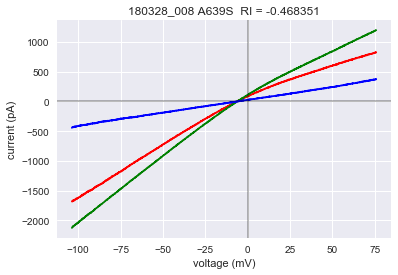

180328_008.EDR processed
total rows: 167
Processing row  41
total=  179640 start= 19000 end= 92000
Without duplicates:  [2565, 2693, 8639, 10439, 12691, 14491, 16438, 18238, 23117, 24917, 26732, 28532, 30601, 32401, 37466, 39266, 41214, 43014, 44953, 46753, 48635, 50435, 52755, 53973, 55064, 56864, 58807, 60607, 62737, 64537]
robust = [8639, 12691, 16438, 23117, 26732, 30601, 37466, 41214, 44953, 48635, 55064, 58807, 62737]
-1600.0
time len= 73000 I len= 73000


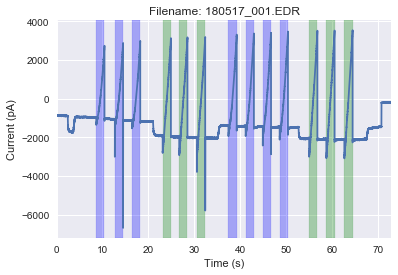

-1600.0


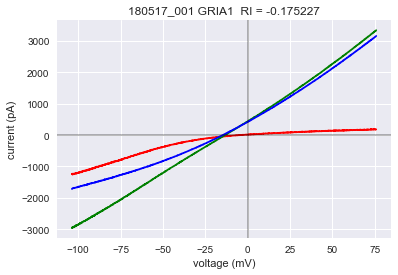

180517_001.EDR processed
total rows: 167
Processing row  42
total=  179640 start= 19000 end= 92000
Without duplicates:  [2565, 2693, 8639, 10439, 12691, 14491, 16438, 18238, 23117, 24917, 26732, 28532, 30601, 32401, 37466, 39266, 41214, 43014, 44953, 46753, 48635, 50435, 52755, 53973, 55064, 56864, 58807, 60607, 62737, 64537]
robust = [8639, 12691, 16438, 23117, 26732, 30601, 37466, 41214, 44953, 48635, 55064, 58807, 62737]
-1600.0
time len= 73000 I len= 73000


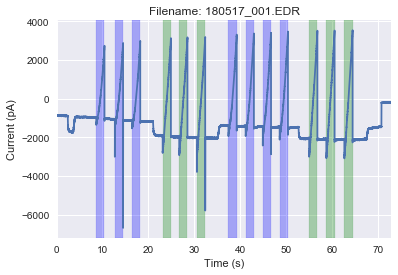

-1600.0


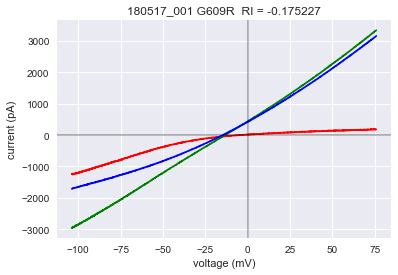

180517_001.EDR processed
total rows: 167
Processing row  43
total=  123752 start= 0 end= 74000
Without duplicates:  [2802, 4602, 7611, 9411, 10922, 11347, 11577, 11699, 12319, 12555, 12672, 12969, 13147, 13814, 14228, 14833, 15005, 16115, 16272, 17291, 17448, 20495, 22392, 24192, 26206, 28006, 28266, 30069, 31001, 31198, 31869, 37496, 39296, 41674, 43474, 45669, 47469, 49365, 49475, 49717, 49847, 50260, 50385, 50897, 51258, 51559, 51888, 52123, 52412, 52641, 53023, 60022, 61822, 63830, 65630, 66835, 67636, 69436, 69446]
robust = [2802, 7611, 11347, 22392, 26206, 30069, 37496, 41674, 45669, 60022, 63830, 67636]
-400.0
time len= 74000 I len= 74000


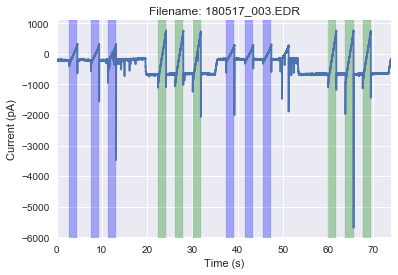

-400.0


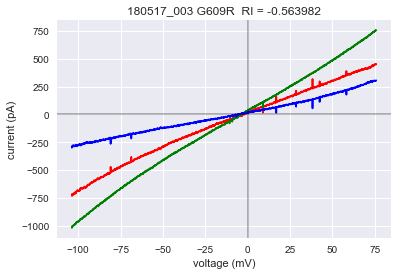

180517_003.EDR processed
total rows: 167
Processing row  44
total=  97804 start= 0 end= 82000
Without duplicates:  [2206, 2870, 2979, 3276, 3626, 3795, 3960, 4332, 4856, 5022, 5595, 5955, 6297, 6852, 6986, 7732, 8507, 9532, 11410, 12879, 13210, 18774, 19531, 19686, 20574, 22394, 24194, 26079, 27879, 36687, 38487, 39043, 39219, 39409, 39907, 40101, 40349, 40835, 41037, 41380, 41851, 42250, 42455, 43678, 43783, 45348, 46763, 47103, 48903, 49523, 51659, 52973, 53459, 59648, 61448, 63453, 65253, 67131, 68931, 76356, 76973, 77154, 77483, 77586, 77707, 77880, 78075, 78189, 78332, 78698, 78874, 79222, 79521, 79916, 80235, 80290]
robust = [3795, 7732, 11410, 18774, 22394, 26079, 36687, 47103, 51659, 59648, 63453, 67131]
-580.0
time len= 82000 I len= 82000


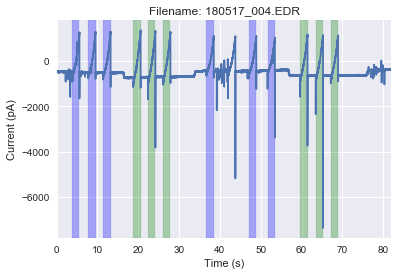

-580.0


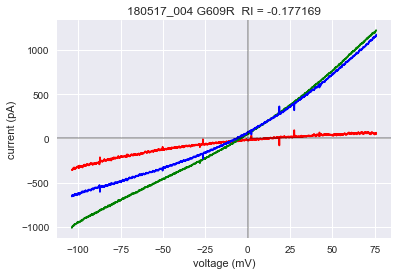

180517_004.EDR processed
total rows: 167
Processing row  45
total=  147704 start= 0 end= 112000
Without duplicates:  [3298, 5098, 6980, 8780, 10856, 12656, 21893, 25013, 26813, 28948, 30748, 32819, 34619, 40988, 42788, 44733, 46533, 48416, 50216, 53782, 57278, 59078, 60898, 62698, 64763, 66563, 71254, 73054, 77492, 79292, 81363, 83163, 85855, 87655, 90499, 92532, 94332, 95864, 98649, 100449, 102641, 104441, 105274]
robust = [3298, 6980, 10856, 25013, 28948, 32819, 40988, 44733, 48416, 57278, 60898, 64763, 71254, 77492, 81363, 85855, 92532, 98649, 102641]
-600.0
time len= 112000 I len= 112000


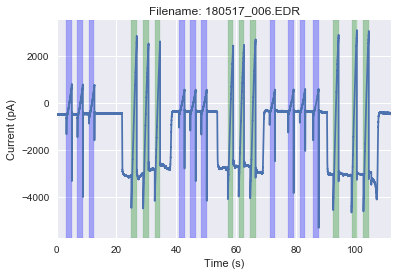

-600.0


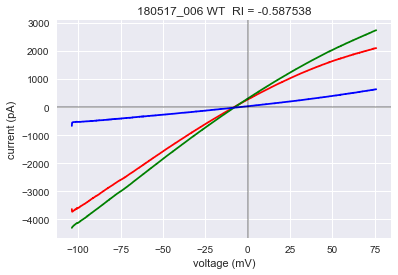

180517_006.EDR processed
total rows: 167
Processing row  46
total=  205588 start= 99000 end= 204000
Without duplicates:  [1762, 6193, 11248, 16029, 16492, 18292, 20613, 22413, 24354, 26154, 26680, 33653, 35453, 37465, 39265, 41644, 43444, 45449, 47249, 66106, 67906, 70034, 71834, 73842, 75642, 79003, 90189, 91989, 93874, 95674, 97551, 99351]
robust = [16492, 20613, 24354, 33653, 37465, 41644, 45449, 66106, 70034, 73842, 90189, 93874, 97551]
-1000.0
time len= 105000 I len= 105000


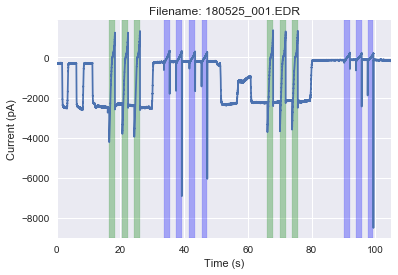

-1000.0


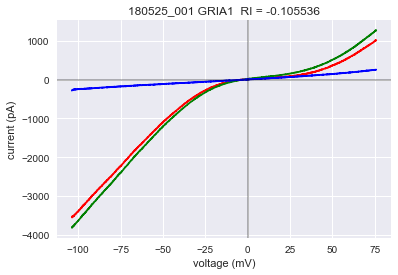

180525_001.EDR processed
total rows: 167
Processing row  47
total=  99800 start= 0 end= 85000
Without duplicates:  [1490, 3290, 5858, 7658, 12160, 13960, 20333, 20786, 20887, 21079, 21304, 21542, 21930, 22326, 22521, 22993, 23324, 23454, 25254, 25478, 25916, 26031, 26277, 26560, 27077, 28842, 29388, 29730, 29970, 30210, 30809, 30930, 32728, 33304, 33817, 34076, 34309, 34606, 35118, 36155, 38803, 40603, 42672, 44472, 46352, 48152, 51375, 52138, 52628, 52851, 52967, 53431, 53610, 53784, 54271, 55584, 55842, 56645, 57524, 57713, 59324, 59574, 59716, 60390, 60690, 60967, 61185, 62880, 63083, 63530, 63707, 63818, 64650, 64818, 65227, 65470, 66762, 69566, 71366, 73870, 75670, 77928, 79728, 82637, 84924, 84962]
robust = [1490, 5858, 12160, 23454, 38803, 42672, 46352, 53784, 57524, 69566, 73870, 77928]
-1000.0
time len= 85000 I len= 85000


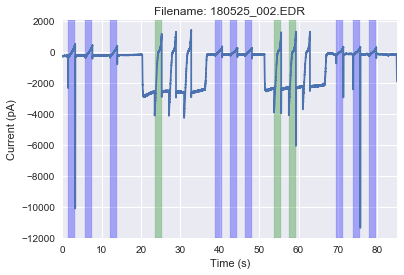

-1000.0


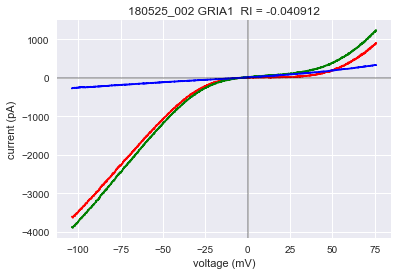

180525_002.EDR processed
total rows: 167
Processing row  48
total=  151696 start= 0 end= 84000
Without duplicates:  [12685, 14485, 16862, 18662, 20487, 22287, 30530, 32330, 35088, 36888, 39761, 41561, 49750, 51550, 53933, 55733, 57736, 59536, 65348, 67148, 69341, 71141, 73400, 75200]
robust = [12685, 16862, 20487, 30530, 35088, 39761, 49750, 53933, 57736, 65348, 69341, 73400]
-400.0
time len= 84000 I len= 84000


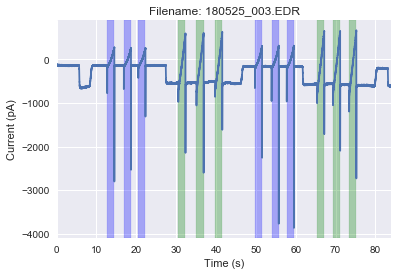

-400.0


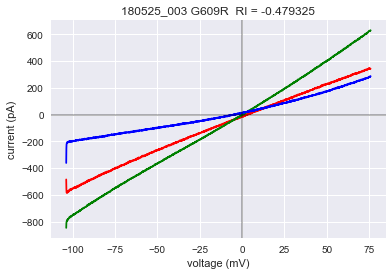

180525_003.EDR processed
total rows: 167
Processing row  49
total=  137724 start= 0 end= 112000
Without duplicates:  [4303, 6103, 9905, 12477, 14277, 40053, 41853, 44609, 46409, 48539, 50339, 53287, 55087, 61208, 63008, 67499, 70316, 72116, 84797, 86597, 89038, 90838, 93030, 94830]
robust = [4303, 12477, 40053, 44609, 48539, 53287, 61208, 70316, 84797, 89038, 93030]
-100.0
time len= 112000 I len= 112000


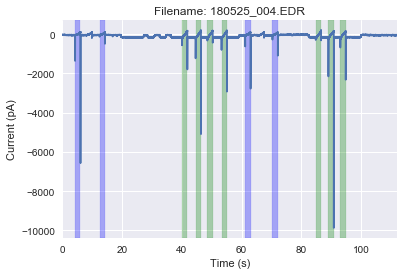

-100.0


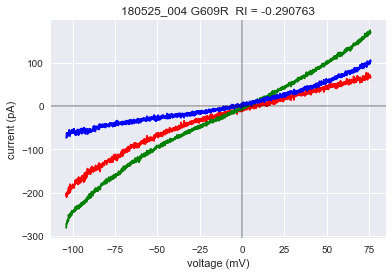

180525_004.EDR processed
total rows: 167
Processing row  50
total=  59880 start= 0 end= 37000
Without duplicates:  [3665, 5465, 7412, 9212, 11276, 13076, 22507, 24307, 26256, 28056, 30495, 32295]
robust = [3665, 7412, 11276, 22507, 26256, 30495]
-200.0
time len= 37000 I len= 37000


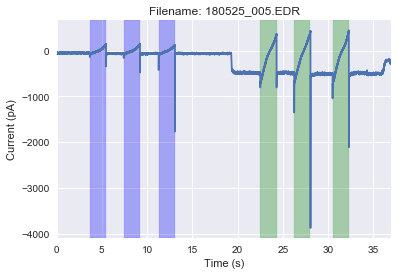

-200.0


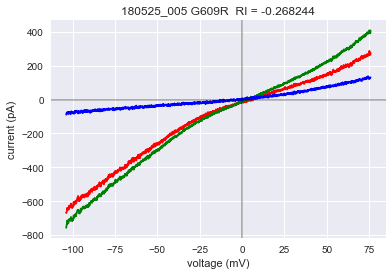

180525_005.EDR processed
total rows: 167
Processing row  51
total=  109780 start= 0 end= 92000
Without duplicates:  [10037, 11837, 13967, 15767, 17899, 19699, 24949, 26749, 28941, 30741, 32873, 34673, 40423, 42223, 44294, 46094, 48226, 50026, 55469, 57269, 59706, 61506, 64202, 66002, 72440, 74240, 75742, 77542, 79051, 80851]
robust = [10037, 13967, 17899, 24949, 28941, 32873, 40423, 44294, 48226, 55469, 59706, 64202, 72440, 75742, 79051]
-220.0
time len= 92000 I len= 92000


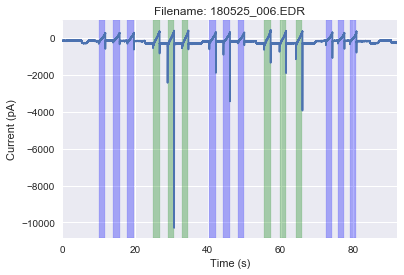

-220.0


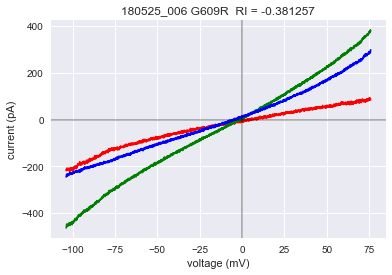

180525_006.EDR processed
total rows: 167
Processing row  52
total=  91816 start= 0 end= 91000
Without duplicates:  [2112, 3912, 5920, 7720, 9602, 11402, 20145, 21945, 23827, 25627, 27452, 29252, 50785, 52585, 55343, 57143, 59086, 60886, 65450, 67250, 69443, 71243, 73006, 74806, 80427, 82227, 85729, 87529, 89597]
robust = [2112, 5920, 9602, 20145, 23827, 27452, 50785, 55343, 59086, 65450, 69443, 73006, 80427, 85729]
-200.0
time len= 91000 I len= 91000


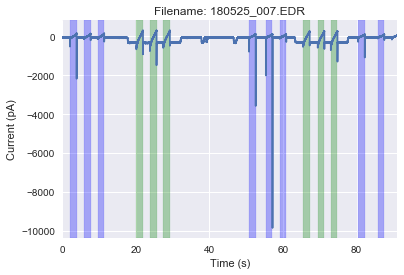

-200.0


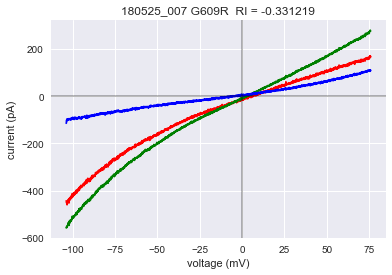

180525_007.EDR processed
total rows: 167
Processing row  53
total=  165668 start= 0 end= 157000
Without duplicates:  [2491, 4291, 6359, 8159, 11042, 12842, 40802, 42602, 45981, 47781, 50913, 52713, 60332, 62132, 64330, 66130, 69196, 70996, 77804, 79604, 81554, 83354, 87041, 88841, 117120, 118920, 120861, 122661, 130038, 131838, 142640, 144440, 146885, 148685, 150190, 151990]
robust = [2491, 6359, 11042, 40802, 45981, 50913, 60332, 64330, 69196, 77804, 81554, 87041, 117120, 120861, 130038, 142640, 146885, 150190]
-120.0
time len= 157000 I len= 157000


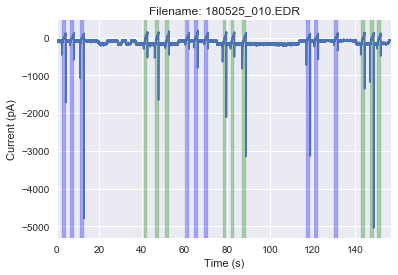

-120.0


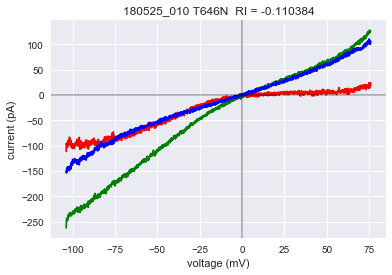

180525_010.EDR processed
total rows: 167
Processing row  54
total=  127744 start= 0 end= 97000
Without duplicates:  [2740, 4540, 11100, 12900, 16653, 18453, 25367, 31985, 35497, 37297, 41555, 43355, 45547, 47347, 49539, 51339, 58339, 60139, 62392, 64192, 66513, 68313, 75077, 78280, 80080, 81642, 83442, 85266, 87066]
robust = [2740, 11100, 16653, 35497, 41555, 45547, 49539, 58339, 62392, 66513, 78280, 81642, 85266]
-1000.0
time len= 97000 I len= 97000


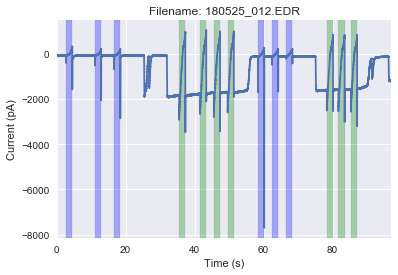

-1000.0


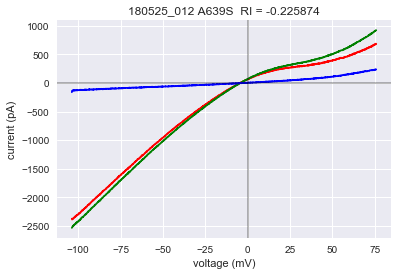

180525_012.EDR processed
total rows: 167
Processing row  55
total=  183632 start= 0 end= 107000
Without duplicates:  [2550, 4350, 6857, 8657, 11347, 13147, 17445, 40425, 42225, 44297, 46097, 48165, 49965, 55715, 57515, 57760, 59584, 61384, 63577, 65377, 66436, 72064, 73864, 76682, 78482, 80675, 82475, 90037, 91837, 94150, 95950, 98585, 100385]
robust = [2550, 6857, 11347, 40425, 44297, 48165, 55715, 59584, 63577, 72064, 76682, 80675, 90037, 94150, 98585]
-700.0
time len= 107000 I len= 107000


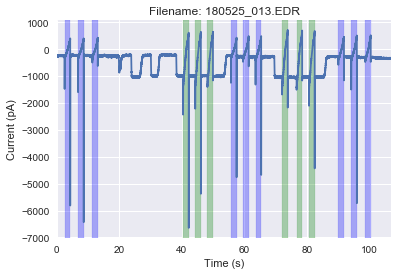

-700.0


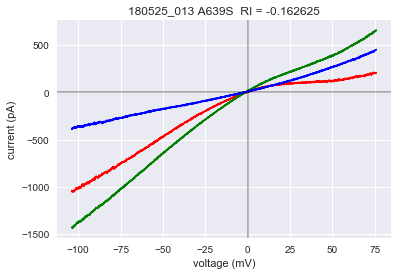

180525_013.EDR processed
total rows: 167
Processing row  56
total=  139720 start= 59000 end= 139720
Without duplicates:  [3141, 4941, 10334, 11565, 13365, 15369, 17032, 17169, 20675, 22475, 22639, 30269, 33098, 34898, 37273, 39073, 44012, 45812, 50297, 51440, 53235, 57988, 59788, 62294, 64094, 67154, 73800, 74636]
robust = [3141, 11565, 15369, 20675, 33098, 37273, 44012, 57988, 62294]
-500.0
time len= 80720 I len= 80720


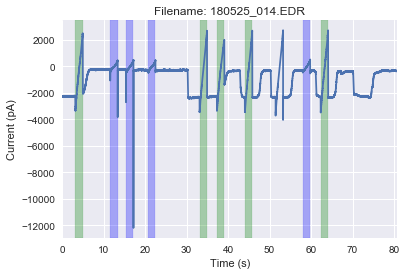

-500.0


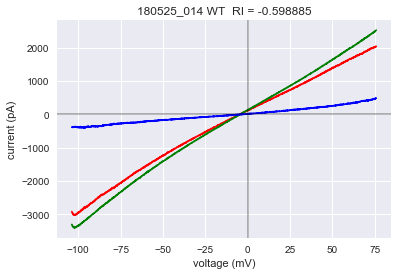

180525_014.EDR processed
total rows: 167
Processing row  57
total=  97804 start= 24000 end= 96000
Without duplicates:  [3398, 5198, 8630, 10430, 12997, 14797, 20299, 22099, 24105, 25905, 27977, 29777, 34774, 36574, 38647, 40447, 42330, 44130, 50065, 51865, 53680, 55480, 57988, 59788, 62540, 64340, 70468]
robust = [3398, 8630, 12997, 20299, 24105, 27977, 34774, 38647, 42330, 50065, 53680, 57988, 62540]
-500.0
time len= 72000 I len= 72000


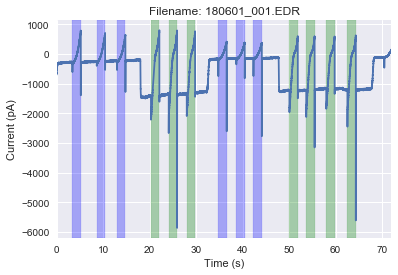

-500.0


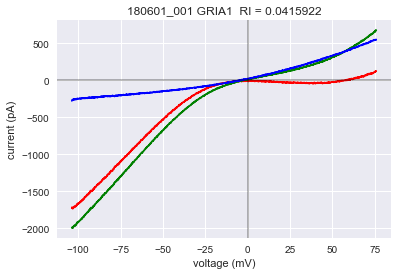

180601_001.EDR processed
total rows: 167
Processing row  58
total=  123752 start= 7000 end= 112000
Without duplicates:  [16702, 18502, 20945, 22745, 24627, 26427, 29387, 31997, 33797, 36303, 38103, 40546, 42346, 48532, 50332, 52706, 54506, 57328, 59128, 64939, 66006, 70431, 72231, 74611, 76411, 80728, 82528, 92457, 94257]
robust = [16702, 20945, 24627, 31997, 36303, 40546, 48532, 52706, 57328, 70431, 74611, 80728, 92457]
-500.0
time len= 105000 I len= 105000


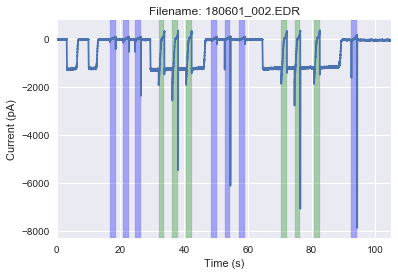

-500.0


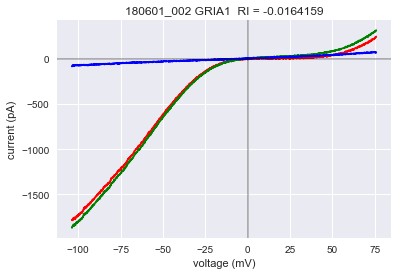

180601_002.EDR processed
total rows: 167
Processing row  59
total=  99800 start= 0 end= 99800
Without duplicates:  [24580, 26380, 28634, 30434, 34309, 41178, 42978, 45048, 46848, 48980, 50780, 56282, 58082, 60521, 62321, 64451, 66251, 72193, 73993, 76122, 77922, 80055, 81855, 88601, 90401, 92533, 94333, 96528, 98328]
robust = [24580, 28634, 41178, 45048, 48980, 56282, 60521, 64451, 72193, 76122, 80055, 88601, 92533, 96528]
-200.0
time len= 99800 I len= 99800


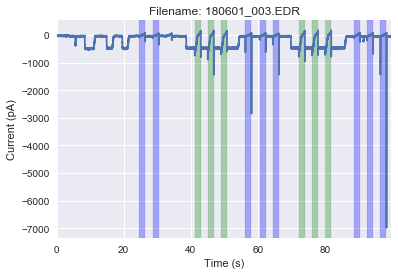

-200.0


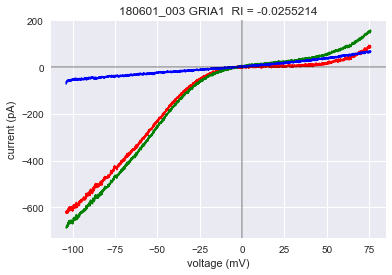

180601_003.EDR processed
total rows: 167
Processing row  60
total=  139720 start= 31000 end= 139720
Without duplicates:  [3874, 5674, 7679, 9479, 11426, 13226, 18100, 19900, 21908, 23708, 25591, 27391, 33450, 35250, 37756, 39556, 41561, 43361, 49050, 50850, 52863, 54663, 56724, 58524, 64533, 66333, 68892, 70692, 73140, 74940, 80062, 81862, 83934, 85734, 88116, 89916, 97786, 99586, 101466, 103266, 105275, 107075]
robust = [3874, 7679, 11426, 18100, 21908, 25591, 33450, 37756, 41561, 49050, 52863, 56724, 64533, 68892, 73140, 80062, 83934, 88116, 97786, 101466, 105275]
-1000.0
time len= 108720 I len= 108720


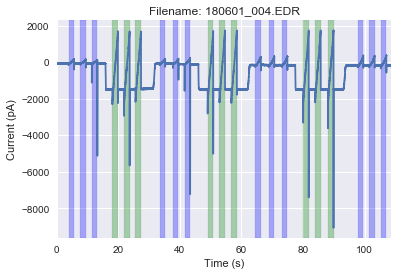

-1000.0


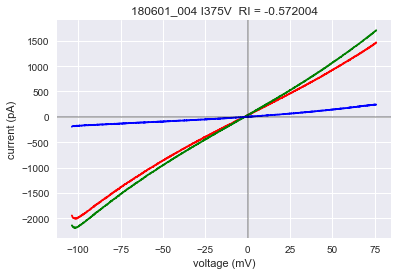

180601_004.EDR processed
total rows: 167
Processing row  61
total=  105788 start= 0 end= 105788
Without duplicates:  [1855, 3655, 6037, 7837, 9904, 11704, 34993, 36793, 38607, 40407, 42291, 44091, 49595, 51395, 53274, 55074, 56834, 58634, 64198, 65998, 67812, 69612, 71432, 73232, 78858, 80658, 82852, 84652, 87031, 88831, 94209, 96009, 97829, 99629, 101448, 103248]
robust = [1855, 6037, 9904, 34993, 38607, 42291, 49595, 53274, 56834, 64198, 67812, 71432, 78858, 82852, 87031, 94209, 97829, 101448]
-500.0
time len= 105788 I len= 105788


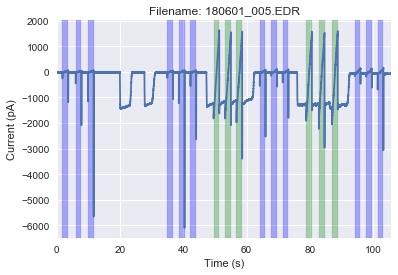

-500.0


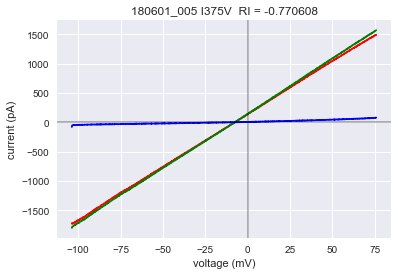

180601_005.EDR processed
total rows: 167
Processing row  62
total=  119760 start= 47000 end= 119760
Without duplicates:  [4600, 6400, 9216, 11016, 13457, 15257, 21136, 22936, 25815, 27615, 29871, 31671, 36858, 38658, 40477, 42277, 43971, 45771, 51647, 53447, 55585, 57385, 59135, 60935]
robust = [4600, 9216, 13457, 21136, 25815, 29871, 36858, 40477, 43971, 51647, 55585, 59135]
-1000.0
time len= 72760 I len= 72760


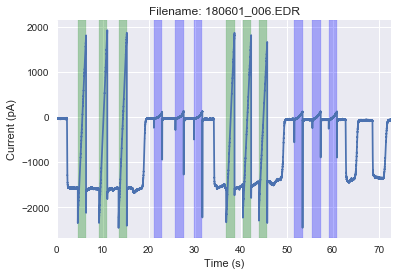

-1000.0


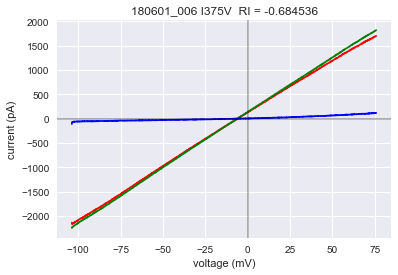

180601_006.EDR processed
total rows: 167
Processing row  63
total=  157684 start= 77000 end= 157684
Without duplicates:  [2678, 4478, 6671, 8471, 10289, 12089, 14925, 18026, 19826, 22644, 24444, 26641, 28441, 36686, 38486, 40929, 42729, 44801, 46601, 50171, 52787, 54587, 56533, 58333, 60209, 62009, 69571, 71371, 73253, 75053, 77122, 78922]
robust = [2678, 6671, 10289, 18026, 22644, 26641, 36686, 40929, 44801, 52787, 56533, 60209, 69571, 73253, 77122]
-1500.0
time len= 80684 I len= 80684


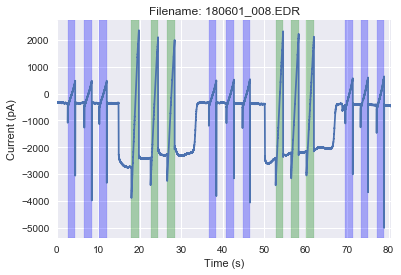

-1500.0


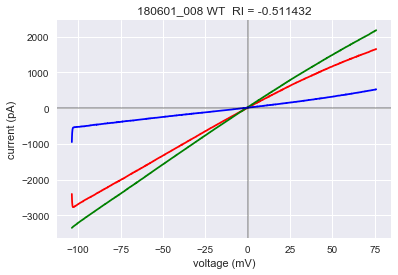

180601_008.EDR processed
total rows: 167
Processing row  64
total=  113772 start= 29000 end= 108000
Without duplicates:  [3446, 5246, 7308, 9108, 11432, 13232, 18104, 19904, 22721, 24521, 26530, 28330, 34518, 36318, 38134, 39934, 42696, 44496, 50243, 52043, 52184, 53795, 55595, 57670, 59470, 66155, 67955, 70332, 72132, 74326, 76126]
robust = [3446, 7308, 11432, 18104, 22721, 26530, 34518, 38134, 42696, 50243, 53795, 57670, 66155, 70332, 74326]
-1000.0
time len= 79000 I len= 79000


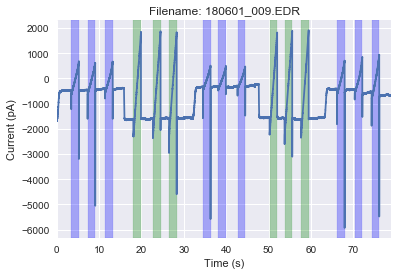

-1000.0


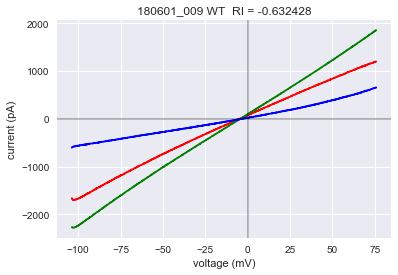

180601_009.EDR processed
total rows: 167
Processing row  65
total=  115768 start= 29000 end= 102000
Without duplicates:  [4817, 6617, 8809, 10609, 12618, 14418, 19792, 21592, 23722, 25522, 27963, 29763, 41627, 43427, 45621, 47421, 50924, 52724, 57794, 59594, 61536, 63336, 65221, 67021]
robust = [4817, 8809, 12618, 19792, 23722, 27963, 41627, 45621, 50924, 57794, 61536, 65221]
-2000.0
time len= 73000 I len= 73000


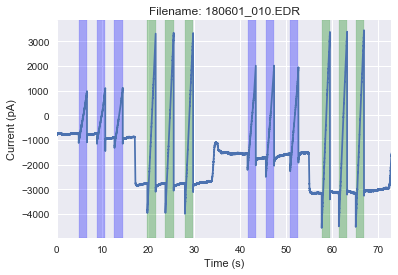

-2000.0


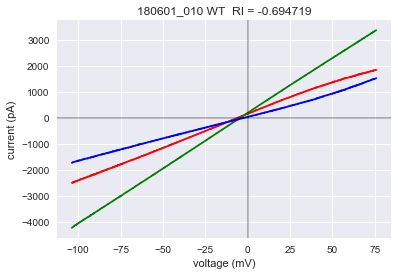

180601_010.EDR processed
total rows: 167
Processing row  66
total=  131736 start= 62000 end= 131736
Without duplicates:  [3016, 4816, 6821, 8621, 10938, 12738, 18614, 20414, 22417, 24217, 26043, 27843, 33588, 35388, 37276, 39076, 40828, 42628, 48193, 49993, 51622, 53422, 55054, 56854]
robust = [3016, 6821, 10938, 18614, 22417, 26043, 33588, 37276, 40828, 48193, 51622, 55054]
-600.0
time len= 69736 I len= 69736


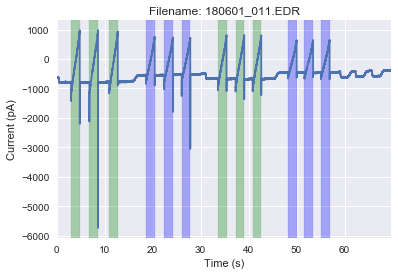

-600.0


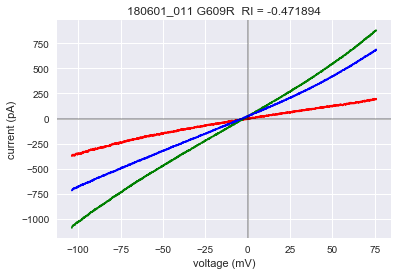

180601_011.EDR processed
total rows: 167
Processing row  67
total=  97804 start= 29000 end= 92000
Without duplicates:  [1876, 3676, 5556, 7356, 9549, 11349, 16541, 18341, 20347, 22147, 24469, 26269, 32330, 34130, 36070, 37870, 39694, 41494, 46552, 48352, 50358, 52158, 54351, 56151]
robust = [1876, 5556, 9549, 16541, 20347, 24469, 32330, 36070, 39694, 46552, 50358, 54351]
-100.0
time len= 63000 I len= 63000


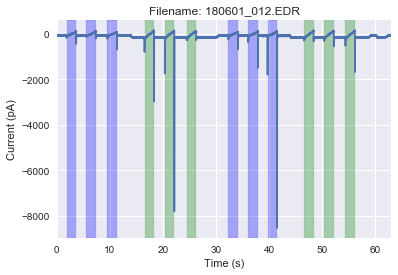

-100.0


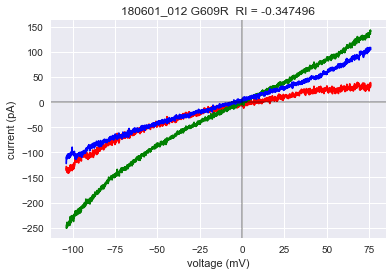

180601_012.EDR processed
total rows: 167
Processing row  68
total=  153692 start= 34000 end= 108000
Without duplicates:  [1863, 3663, 5671, 7471, 9537, 11337, 16531, 18331, 30381, 32181, 34248, 36048, 37929, 39729, 44983, 46783, 48602, 50402, 52285, 54085, 60520, 62320, 64450, 66250, 68196, 69996]
robust = [1863, 5671, 9537, 16531, 30381, 34248, 37929, 44983, 48602, 52285, 60520, 64450, 68196]
-300.0
time len= 74000 I len= 74000


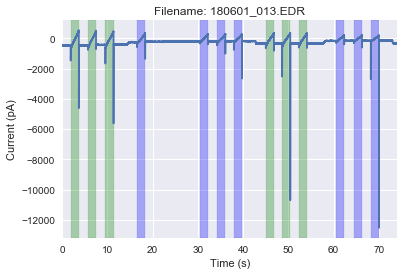

-300.0


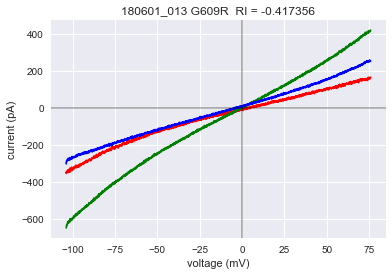

180601_013.EDR processed
total rows: 167
Processing row  69
total=  125748 start= 39000 end= 94000
Without duplicates:  [2613, 4413, 5921, 7721, 9606, 11406, 14259, 15372, 16983, 17218, 18534, 18885, 19018, 19351, 19791, 21082, 22882, 24825, 26407, 26625, 38812, 40301, 42101, 44051, 45851, 48106, 49906, 53620, 54315, 54419]
robust = [2613, 5921, 9606, 17218, 21082, 24825, 40301, 44051, 48106]
-1000.0
time len= 55000 I len= 55000


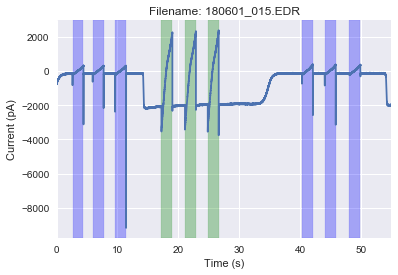

-1000.0


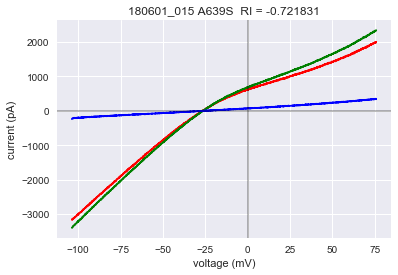

180601_015.EDR processed
total rows: 167
Processing row  70
total=  147704 start= 24000 end= 102000
Without duplicates:  [1015, 2814, 4945, 6745, 10129, 11929, 19736, 21536, 23230, 25030, 26067, 27102, 28902, 31699, 32443, 36959, 38759, 40640, 42440, 43945, 45745, 53809, 55609, 57613, 59413, 61482, 63282]
robust = [4945, 10129, 19736, 23230, 27102, 36959, 40640, 43945, 53809, 57613, 61482]
-1000.0
time len= 78000 I len= 78000


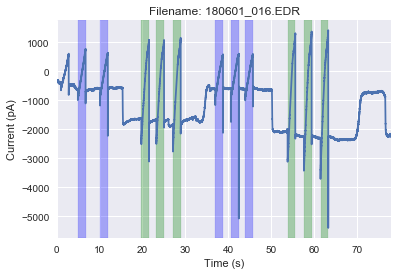

-1000.0


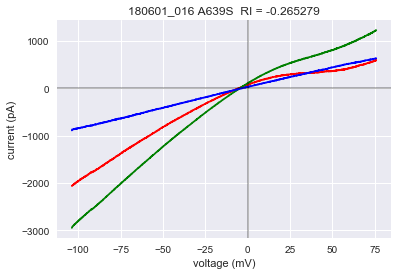

180601_016.EDR processed
total rows: 167
Processing row  71
total=  197604 start= 79000 end= 182000
Without duplicates:  [2500, 8293, 10093, 11908, 13708, 15590, 17390, 23515, 25315, 34809, 36609, 38803, 40603, 47600, 49400, 51343, 53143, 55087, 56887, 67127, 70128, 71928, 73746, 75546, 77682, 79482, 84542, 86342, 88224, 90024, 91967, 93767, 98932, 102252, 102256]
robust = [8293, 11908, 15590, 23515, 34809, 38803, 47600, 51343, 55087, 70128, 73746, 77682, 84542, 88224, 91967]
-1000.0
time len= 103000 I len= 103000


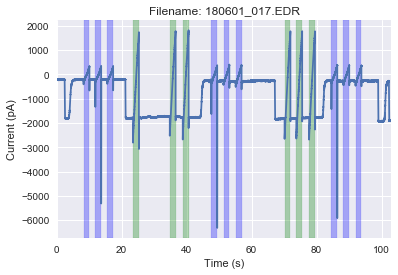

-1000.0


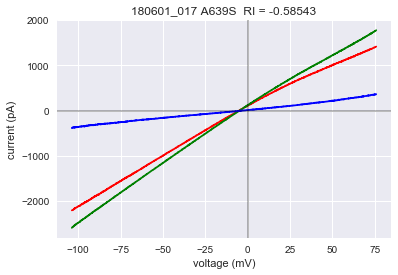

180601_017.EDR processed
total rows: 167
Processing row  72
total=  169660 start= 27000 end= 107000
Without duplicates:  [3080, 4880, 7127, 8927, 11061, 12861, 16315, 22854, 24654, 26656, 28456, 30400, 32200, 39760, 41560, 44072, 45872, 48936, 50736, 55276, 58174, 59974, 62410, 64210, 68650, 70450, 78642]
robust = [3080, 7127, 11061, 22854, 26656, 30400, 39760, 44072, 48936, 58174, 62410, 68650]
-1500.0
time len= 80000 I len= 80000


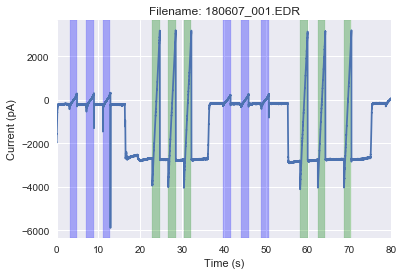

-1500.0


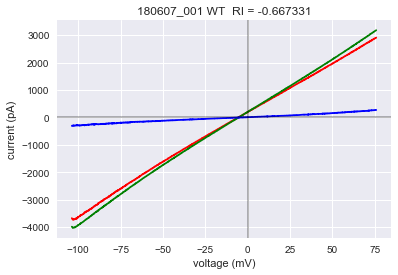

180607_001.EDR processed
total rows: 167
Processing row  73
total=  105788 start= 27000 end= 92000
Without duplicates:  [2324, 4124, 5939, 7739, 9750, 11550, 16983, 18783, 20670, 22470, 24474, 26274, 31712, 33512, 35332, 37132, 38884, 40684, 44127, 45927, 51621, 53421, 55989, 57789, 59607, 61407, 64343]
robust = [2324, 5939, 9750, 16983, 20670, 24474, 31712, 35332, 38884, 44127, 51621, 55989, 59607]
-1000.0
time len= 65000 I len= 65000


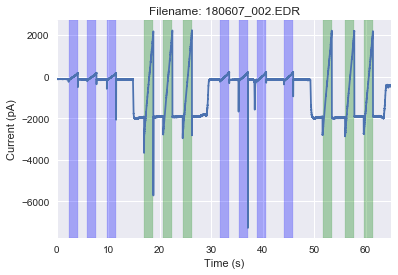

-1000.0


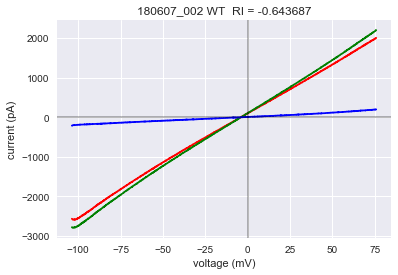

180607_002.EDR processed
total rows: 167
Processing row  74
total=  135728 start= 24000 end= 115000
Without duplicates:  [3820, 5620, 7382, 7519, 9182, 11065, 12865, 15787, 18364, 20164, 22602, 24402, 31465, 33265, 39075, 40875, 46627, 48427, 50814, 52614, 57674, 59474, 60498, 62928, 65348, 67148, 68591, 70391, 72272, 74072, 77952, 79514, 81314, 81801, 83005, 84805, 85694, 86489, 88305]
robust = [3820, 7382, 11065, 18364, 22602, 31465, 39075, 46627, 50814, 57674, 65348, 68591, 72272, 79514, 83005]
-2000.0
time len= 91000 I len= 91000


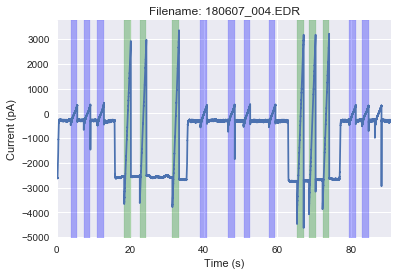

-2000.0


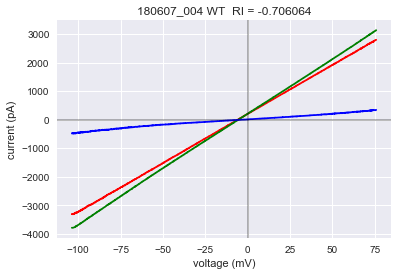

180607_004.EDR processed
total rows: 167
Processing row  75
total=  105788 start= 9000 end= 42000
Without duplicates:  [3971, 5771, 7657, 9457, 11646, 13446, 18014, 19814, 21383, 23183, 25937, 27737]
robust = [3971, 7657, 11646, 18014, 21383, 25937]
-500.0
time len= 33000 I len= 33000


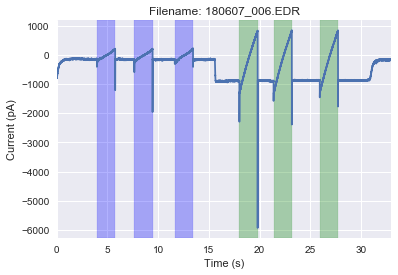

-500.0


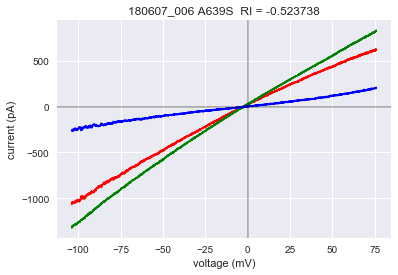

180607_006.EDR processed
total rows: 167
Processing row  76
total=  129740 start= 0 end= 50000
Without duplicates:  [3425, 5225, 7730, 9530, 11285, 13085, 21025, 22825, 24186, 25080, 26880, 28947, 30747, 36440, 38240, 40553, 42353, 44359, 46159]
robust = [3425, 7730, 11285, 21025, 25080, 28947, 36440, 40553, 44359]
-1000.0
time len= 50000 I len= 50000


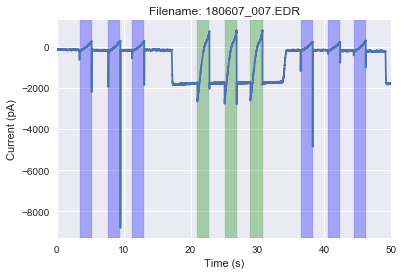

-1000.0


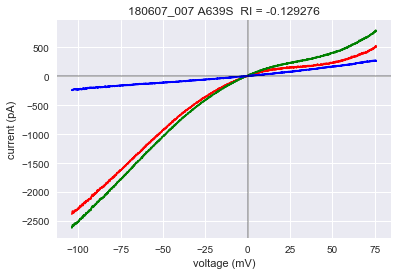

180607_007.EDR processed
total rows: 167
Processing row  77
total=  105788 start= 19000 end= 69000
Without duplicates:  [53, 965, 2859, 3508, 3690, 4554, 4996, 5514, 7314, 7862, 8911, 10710, 11311, 11558, 12245, 12566, 13253, 13417, 15053, 17187, 18987, 21436, 22401, 22703, 23226, 27479, 29279, 30803, 32004, 32527, 34531, 36331, 38400, 39221, 39523, 41323, 41548, 41687, 43627, 44017, 44340, 45274, 46127, 46448, 46760, 46980, 47331, 47576, 47711, 47954, 48205, 48409, 48535, 48808, 48966, 49032]
robust = [5514, 13253, 17187, 27479, 34531, 39523]
-1000.0
time len= 50000 I len= 50000


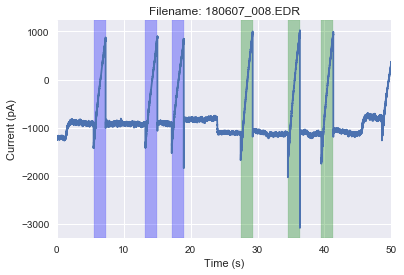

-1000.0


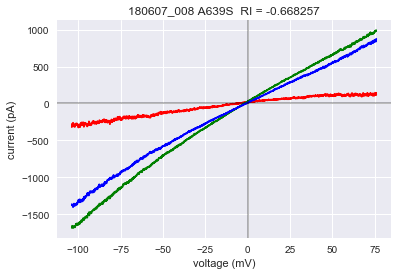

180607_008.EDR processed
total rows: 167
Processing row  78
total=  211576 start= 89000 end= 157000
Without duplicates:  [7974, 9774, 12957, 14728, 17572, 19372, 24200, 26992, 28792, 31051, 32851, 34917, 36717, 56072, 57872, 59694, 61494, 62938, 64738, 67633, 67637]
robust = [7974, 17572, 26992, 31051, 34917, 56072, 59694, 62938]
-1500.0
time len= 68000 I len= 68000


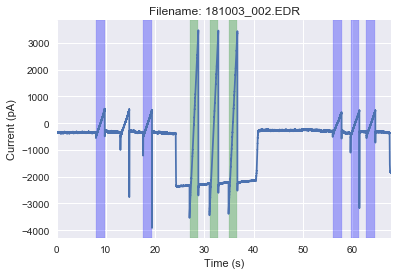

-1500.0


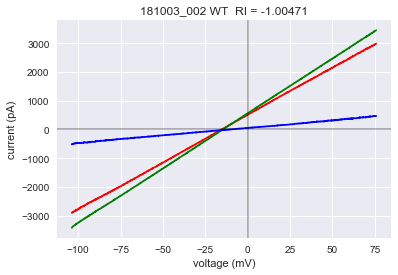

181003_002.EDR processed
total rows: 167
Processing row  79
total=  197604 start= 99000 end= 167000
Without duplicates:  [447, 2764, 4564, 12497, 14297, 16544, 18415, 20548, 22348, 28664, 30464, 31903, 33703, 35648, 37448, 43137, 44937, 47378, 49178, 51189, 52989, 58799, 60599, 63542, 65342, 67721]
robust = [2764, 12497, 20548, 28664, 31903, 35648, 43137, 47378, 51189, 58799, 63542]
-150.0
time len= 68000 I len= 68000


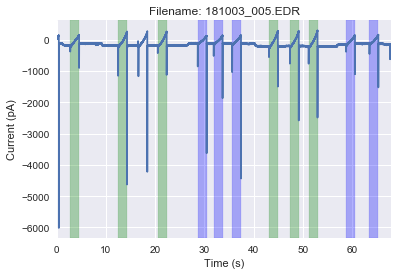

-150.0


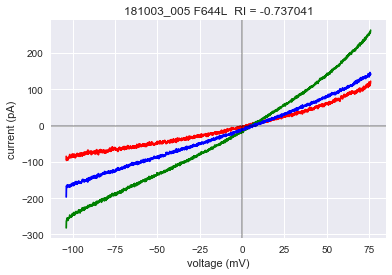

181003_005.EDR processed
total rows: 167
Processing row  80
total=  137724 start= 9000 end= 65000
Without duplicates:  [743, 960, 14515, 16315, 19197, 20997, 25989, 26898, 32302, 34102, 36419, 38219, 40475, 42275, 47717, 49517, 52582, 54348, 54385]
robust = [14515, 19197, 32302, 36419, 40475, 47717]
-100.0
time len= 56000 I len= 56000


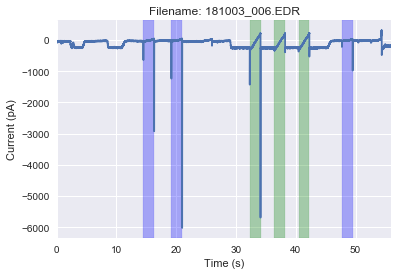

-100.0


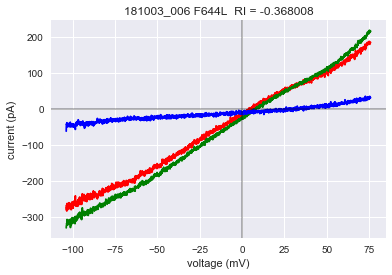

181003_006.EDR processed
total rows: 167
Processing row  81
total=  197604 start= 29000 end= 87000
Without duplicates:  [2447, 8994, 10794, 12989, 14789, 16791, 18591, 21172, 23911, 25711, 27961, 29761, 31829, 33629, 39697, 41497, 43499, 45299, 47181, 48981, 53256, 57174]
robust = [8994, 12989, 16791, 23911, 27961, 31829, 39697, 43499, 47181]
-2000.0
time len= 58000 I len= 58000


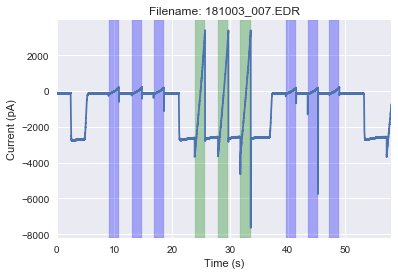

-2000.0


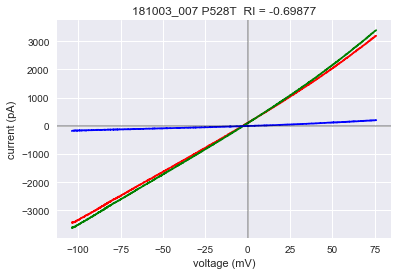

181003_007.EDR processed
total rows: 167
Processing row  82
total=  137724 start= 34000 end= 87000
Without duplicates:  [354, 5928, 7728, 9923, 11723, 14039, 15839, 21652, 23452, 25397, 27197, 29203, 31003, 39812, 41612, 43748, 45548, 47551, 49351, 52444, 52447]
robust = [5928, 9923, 14039, 21652, 25397, 29203, 39812, 43748, 47551]
-1500.0
time len= 53000 I len= 53000


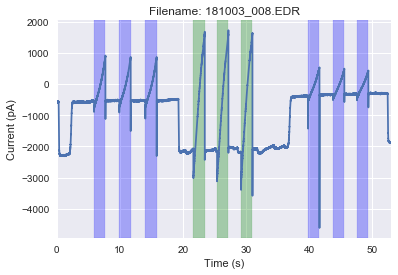

-1500.0


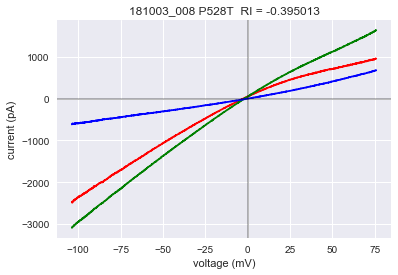

181003_008.EDR processed
total rows: 167
Processing row  83
total=  395208 start= 159000 end= 232000
Without duplicates:  [6008, 7808, 10005, 11805, 13935, 15735, 23047, 24847, 26849, 28649, 30907, 32707, 39457, 41257, 43262, 45062, 46821, 48621, 54683, 56483, 58112, 59912, 61674, 63474]
robust = [6008, 10005, 13935, 23047, 26849, 30907, 39457, 43262, 46821, 54683, 58112, 61674]
-500.0
time len= 73000 I len= 73000


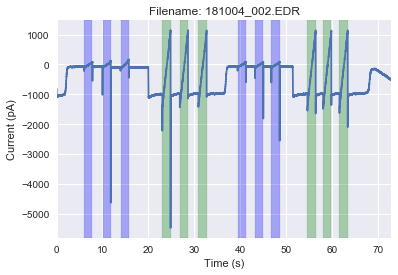

-500.0


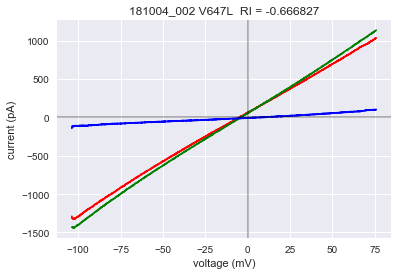

181004_002.EDR processed
total rows: 167
Processing row  84
total=  265468 start= 74000 end= 162000
Without duplicates:  [5556, 7355, 9859, 11659, 14853, 16653, 23648, 25448, 27452, 29252, 31141, 32941, 39186, 40986, 42741, 44541, 46548, 48348, 54476, 56276, 58220, 60020, 62522, 64322, 71136, 72936, 74689, 76489, 78311, 80111]
robust = [9859, 14853, 23648, 27452, 31141, 39186, 42741, 46548, 54476, 58220, 62522, 71136, 74689, 78311]
-1500.0
time len= 88000 I len= 88000


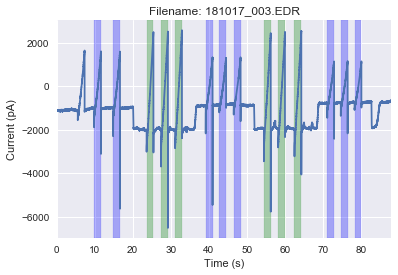

-1500.0


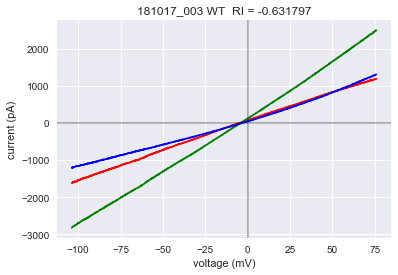

181017_003.EDR processed
total rows: 167
Processing row  85
total=  147704 start= 59000 end= 132000
Without duplicates:  [2246, 4325, 6125, 8385, 10185, 12256, 14056, 19988, 21788, 23800, 25600, 27541, 29341, 34403, 36203, 38584, 40384, 43702, 45502, 53248, 53386, 55048, 58115, 59915, 63175, 64975, 64987]
robust = [4325, 8385, 12256, 19988, 23800, 27541, 34403, 38584, 43702, 53248, 58115, 63175]
-800.0
time len= 73000 I len= 73000


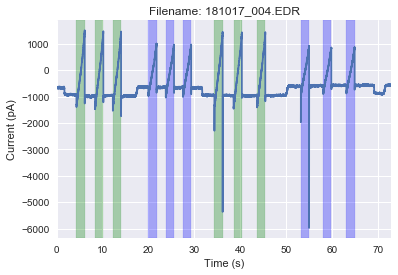

-800.0


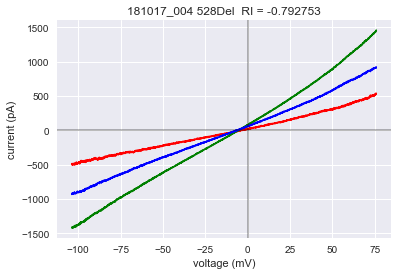

181017_004.EDR processed
total rows: 167
Processing row  86
total=  129740 start= 39000 end= 112000
Without duplicates:  [9414, 11214, 13032, 14832, 16592, 18392, 25449, 27249, 29133, 30933, 31268, 32502, 34302, 39865, 41665, 43734, 45534, 47354, 49154, 53846, 55646, 57587, 59387, 61268, 63068]
robust = [9414, 13032, 16592, 25449, 29133, 32502, 39865, 43734, 47354, 53846, 57587, 61268]
-1000.0
time len= 73000 I len= 73000


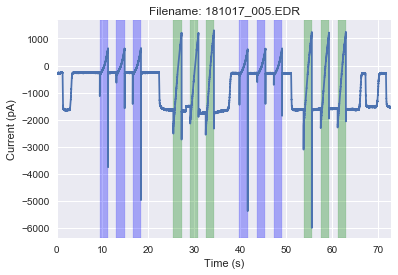

-1000.0


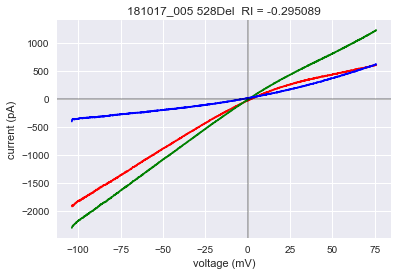

181017_005.EDR processed
total rows: 167
Processing row  87
total=  221556 start= 89000 end= 162000
Without duplicates:  [2308, 4108, 6050, 7850, 9861, 11661, 13601, 15401, 21092, 22892, 24958, 26758, 28703, 30503, 35509, 37309, 39062, 40861, 42809, 44609, 50853, 52653, 55287, 57087, 59277, 61077, 67455, 69255, 72382]
robust = [2308, 6050, 9861, 13601, 21092, 24958, 28703, 35509, 42809, 50853, 55287, 59277, 67455]
-500.0
time len= 73000 I len= 73000


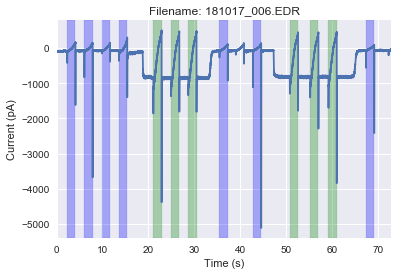

-500.0


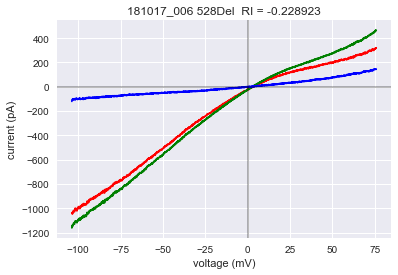

181017_006.EDR processed
total rows: 167
Processing row  88
total=  221556 start= 39000 end= 122000
Without duplicates:  [2673, 4473, 7165, 8965, 10788, 12588, 14408, 16208, 23890, 25690, 27759, 29559, 31189, 32989, 39615, 41415, 43550, 45350, 47291, 49091, 55831, 56464, 58264, 60272, 62072, 64013, 65813, 74621, 76421, 78303, 80103, 81921]
robust = [2673, 7165, 10788, 14408, 23890, 27759, 31189, 39615, 43550, 47291, 56464, 60272, 64013, 74621, 78303]
-600.0
time len= 83000 I len= 83000


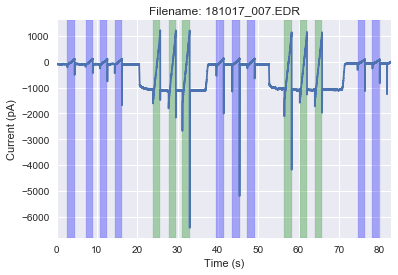

-600.0


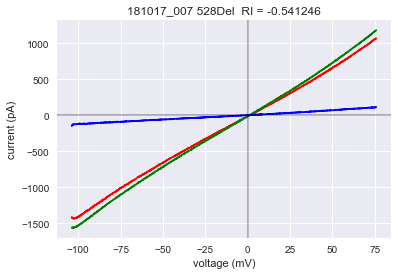

181017_007.EDR processed
total rows: 167
Processing row  89
total=  131736 start= 14000 end= 102000
Without duplicates:  [6529, 8329, 9891, 11691, 13511, 15311, 21747, 23547, 25558, 27358, 29300, 31100, 36414, 38214, 39974, 41774, 43716, 45516, 54196, 55996, 57440, 59240, 62248, 64048, 69361, 71161, 73605, 75405, 77220, 79020]
robust = [6529, 9891, 13511, 21747, 25558, 29300, 36414, 39974, 43716, 54196, 57440, 62248, 69361, 73605, 77220]
-1000.0
time len= 88000 I len= 88000


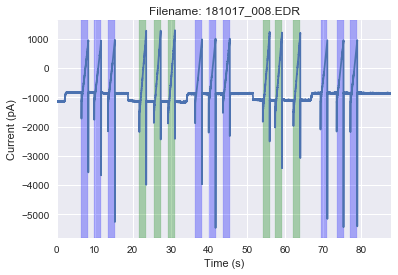

-1000.0


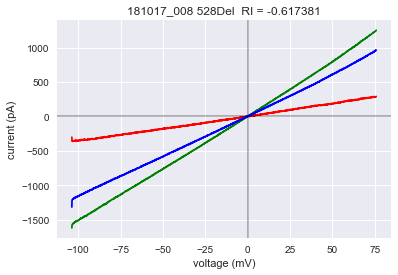

181017_008.EDR processed
total rows: 167
Processing row  90
total=  193612 start= 29000 end= 122000
Without duplicates:  [6311, 8111, 9802, 11602, 13366, 15166, 20661, 22461, 24406, 26206, 28212, 30012, 35389, 37189, 38947, 40747, 42188, 43988, 49121, 50921, 52739, 54539, 56604, 58404, 62658, 64458, 67214, 69014, 70830, 72630, 77326, 79126, 80567, 82367, 83933, 85733]
robust = [6311, 9802, 13366, 20661, 24406, 28212, 35389, 38947, 42188, 49121, 52739, 56604, 62658, 67214, 70830, 77326, 80567, 83933]
-500.0
time len= 93000 I len= 93000


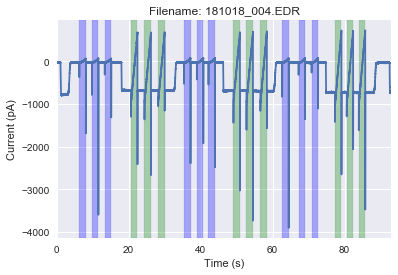

-500.0


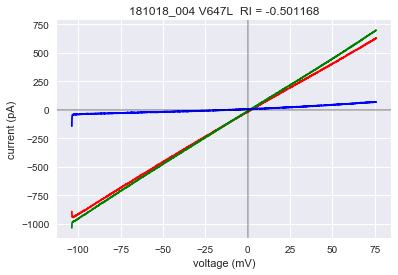

181018_004.EDR processed
total rows: 167
Processing row  91
total=  233532 start= 144000 end= 212000
Without duplicates:  [4004, 5804, 7687, 9487, 12371, 14171, 24595, 26395, 29525, 31325, 33645, 35445, 37828, 39628, 47564, 49364, 51305, 53105, 54862, 56662]
robust = [4004, 7687, 12371, 24595, 29525, 33645, 37828, 47564, 51305, 54862]
-2000.0
time len= 68000 I len= 68000


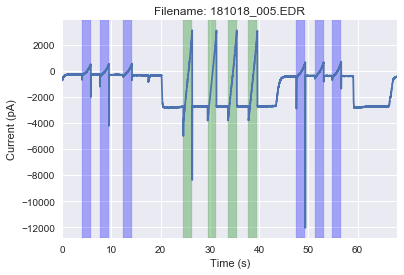

-2000.0


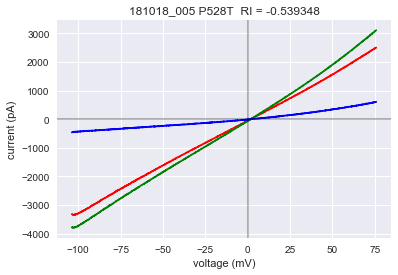

181018_005.EDR processed
total rows: 167
Processing row  92
total=  199600 start= 39000 end= 172000
Without duplicates:  [5172, 6972, 9414, 11214, 16034, 17834, 25180, 27946, 29746, 32066, 33866, 35807, 37607, 39602, 42863, 44663, 46731, 48531, 51725, 53525, 57324, 61267, 63067, 65013, 66813, 69257, 71057, 71538, 80551, 82351, 84543, 86343, 89103, 90903, 94623, 97458, 99258, 99843, 101207, 103007, 104947, 106747, 113499, 115299, 118928, 120728, 122608, 124408, 127413, 127425]
robust = [5172, 9414, 16034, 27946, 32066, 35807, 42863, 46731, 51725, 61267, 65013, 69257, 80551, 84543, 89103, 97458, 101207, 104947, 113499, 118928, 122608]
-1500.0
time len= 133000 I len= 133000


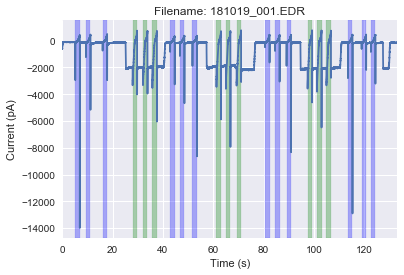

-1500.0


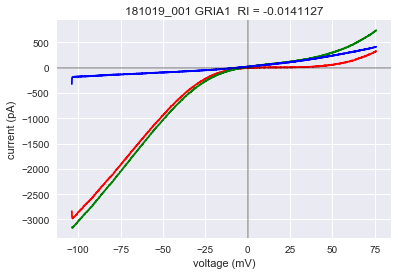

181019_001.EDR processed
total rows: 167
Processing row  93
total=  117764 start= 19000 end= 92000
Without duplicates:  [9825, 11625, 13502, 15302, 16998, 18798, 24362, 26162, 28103, 29903, 31976, 33776, 39713, 41513, 43392, 45192, 46823, 48623, 55311, 57111, 59241, 61041, 64546, 66346]
robust = [9825, 13502, 16998, 24362, 28103, 31976, 39713, 43392, 46823, 55311, 59241, 64546]
-500.0
time len= 73000 I len= 73000


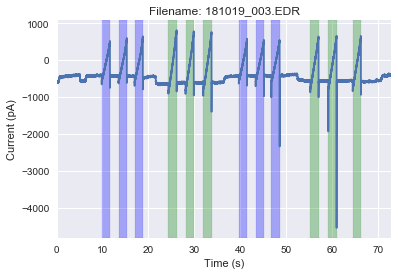

-500.0


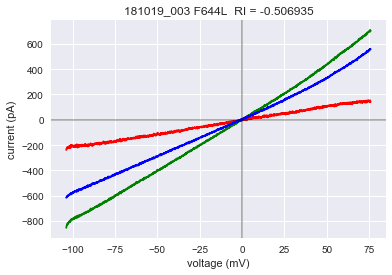

181019_003.EDR processed
total rows: 167
Processing row  94
total=  371256 start= 129000 end= 242000
Without duplicates:  [4084, 5884, 8268, 10068, 21245, 23045, 33854, 35654, 37592, 39392, 41463, 43263, 50011, 51811, 54442, 56242, 58188, 59988, 68296, 70096, 73099, 74899, 77155, 78955, 87201, 89001, 90572, 92372, 94818, 96618, 99873, 101673]
robust = [4084, 8268, 21245, 33854, 37592, 41463, 50011, 54442, 58188, 68296, 73099, 77155, 87201, 90572, 94818, 99873]
-500.0
time len= 113000 I len= 113000


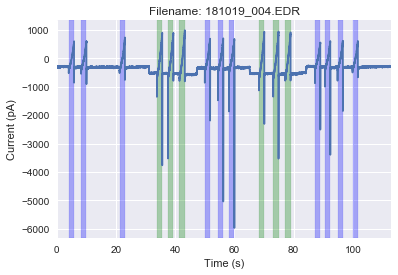

-500.0


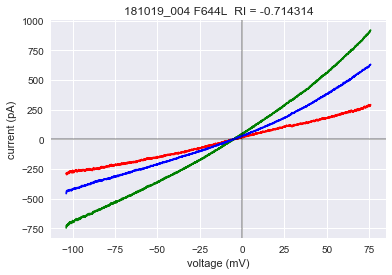

181019_004.EDR processed
total rows: 167
Processing row  95
total=  371256 start= 129000 end= 242000
Without duplicates:  [4084, 5884, 8268, 10068, 21245, 23045, 33854, 35654, 37592, 39392, 41463, 43263, 50011, 51811, 54442, 56242, 58188, 59988, 68296, 70096, 73099, 74899, 77155, 78955, 87201, 89001, 90572, 92372, 94818, 96618, 99873, 101673]
robust = [4084, 8268, 21245, 33854, 37592, 41463, 50011, 54442, 58188, 68296, 73099, 77155, 87201, 90572, 94818, 99873]
-500.0
time len= 113000 I len= 113000


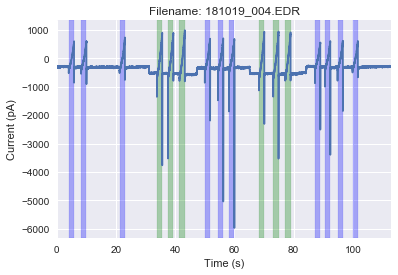

-500.0


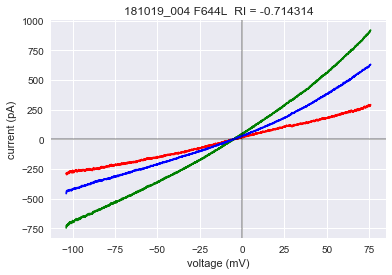

181019_004.EDR processed
total rows: 167
Processing row  96
total=  149700 start= 24000 end= 92000
Without duplicates:  [2887, 4687, 6566, 8366, 10252, 12052, 14934, 17988, 19788, 21416, 23216, 24976, 26776, 33215, 35015, 38943, 41136, 42936, 45724, 48378, 50178, 51681, 53481, 55364, 57164, 62979, 64779]
robust = [2887, 6566, 10252, 17988, 21416, 24976, 33215, 41136, 48378, 51681, 55364, 62979]
-1500.0
time len= 68000 I len= 68000


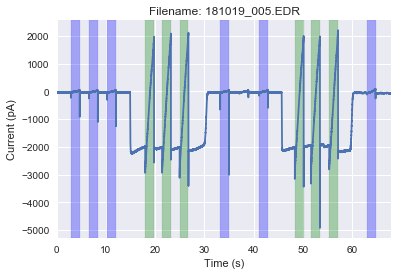

-1500.0


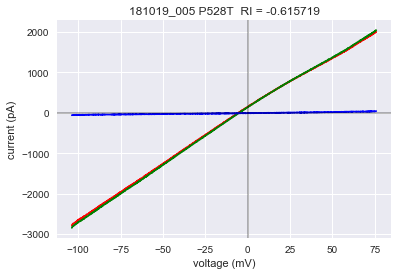

181019_005.EDR processed
total rows: 167
Processing row  97
total=  75848 start= 11000 end= 44000
Without duplicates:  [4280, 6080, 7649, 9449, 11267, 13067, 18008, 19808, 21313, 23113, 24932, 26732, 31800]
robust = [4280, 7649, 11267, 18008, 21313, 24932]
-1500.0
time len= 33000 I len= 33000


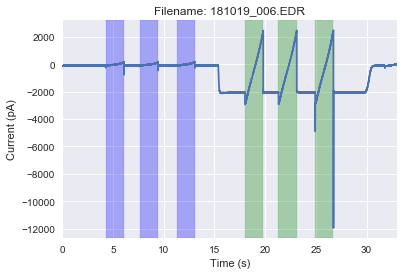

-1500.0


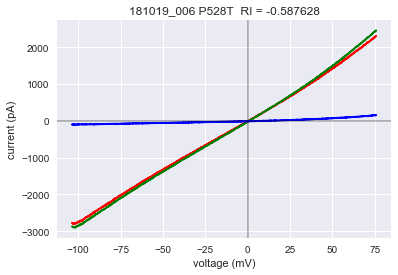

181019_006.EDR processed
total rows: 167
Processing row  98
total=  125748 start= 39000 end= 122000
Without duplicates:  [6609, 8409, 10225, 12025, 13469, 15269, 27541, 30479, 34375, 36175, 38119, 39919, 41865, 43665, 45926, 48041, 49841, 51534, 53334, 55217, 57017, 60488, 61152, 64130, 64312, 68374, 68804, 69196, 70324, 70931, 71281, 71993, 72233, 74999, 76799, 77500, 79307, 81107, 81508, 82875]
robust = [6609, 10225, 13469, 34375, 38119, 41865, 48041, 51534, 55217, 74999, 79307]
-2000.0
time len= 83000 I len= 83000


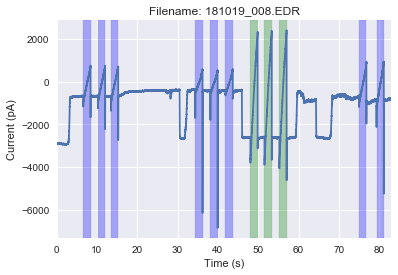

-2000.0


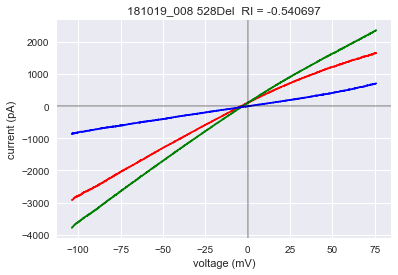

181019_008.EDR processed
total rows: 167
Processing row  99
total=  121756 start= 20000 end= 112000
Without duplicates:  [9663, 14061, 15861, 17680, 19480, 21423, 23223, 29348, 31148, 33155, 34955, 36903, 38703, 45700, 47500, 50004, 51804, 54251, 56051, 61797, 63597, 65541, 67341, 69224, 71024, 76276, 78076, 79893, 81693, 83764, 85564]
robust = [14061, 17680, 21423, 29348, 33155, 36903, 45700, 50004, 54251, 61797, 65541, 69224, 76276, 79893, 83764]
-1500.0
time len= 92000 I len= 92000


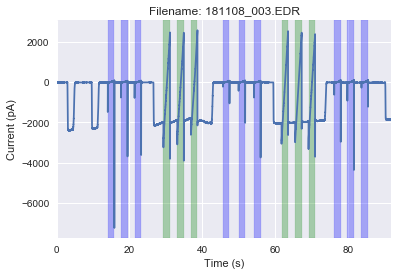

-1500.0


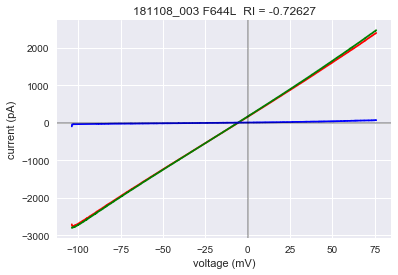

181108_003.EDR processed
total rows: 167
Processing row  100
total=  131736 start= 24000 end= 110000
Without duplicates:  [4010, 5810, 7941, 9741, 11810, 13610, 20669, 22469, 24293, 26093, 28095, 29895, 36208, 38008, 40576, 42376, 44630, 46430, 46540, 48345, 50874, 52674, 54680, 56480, 58671, 60471, 62732, 64532, 70650, 72450, 74900, 76700, 79141, 80941, 84404, 84408]
robust = [4010, 7941, 11810, 20669, 24293, 28095, 36208, 40576, 44630, 50874, 54680, 58671, 62732, 70650, 74900, 79141]
-1500.0
time len= 86000 I len= 86000


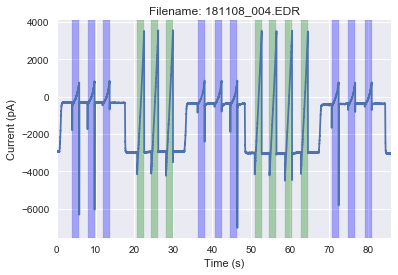

-1500.0


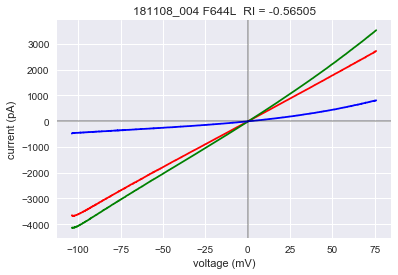

181108_004.EDR processed
total rows: 167
Processing row  101
total=  109780 start= 64000 end= 102000
Without duplicates:  [3322, 5122, 7818, 9618, 11308, 13108, 15319, 17924, 19724, 22540, 24340, 26415, 28215, 33640, 37090, 37106]
robust = [3322, 7818, 11308, 17924, 22540, 26415]
-2000.0
time len= 38000 I len= 38000


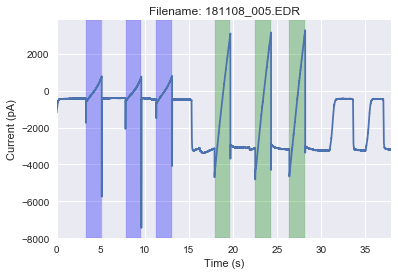

-2000.0


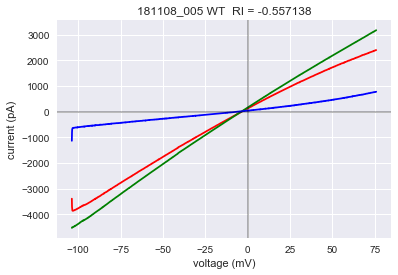

181108_005.EDR processed
total rows: 167
Processing row  102
total=  149700 start= 54000 end= 102000
Without duplicates:  [1714, 3514, 5395, 7195, 9016, 10816, 16314, 18114, 20120, 21920, 23803, 25603, 31918, 33718, 35719, 37519, 39339, 41139]
robust = [1714, 5395, 9016, 16314, 20120, 23803, 31918, 35719, 39339]
-500.0
time len= 48000 I len= 48000


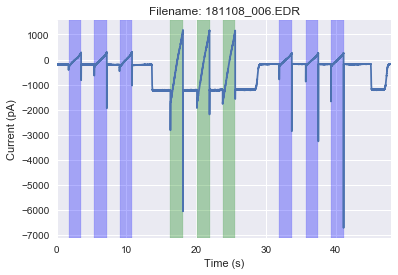

-500.0


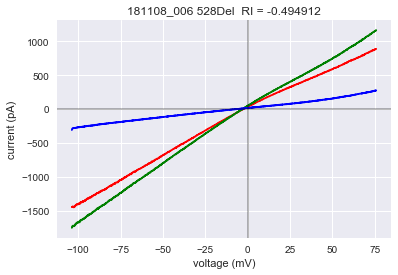

181108_006.EDR processed
total rows: 167
Processing row  103
total=  65868 start= 19000 end= 51000
Without duplicates:  [7698, 9498, 11442, 13242, 15248, 17048, 22614, 24414, 26543, 28343, 30287]
robust = [7698, 11442, 15248, 22614, 26543]
-300.0
time len= 32000 I len= 32000


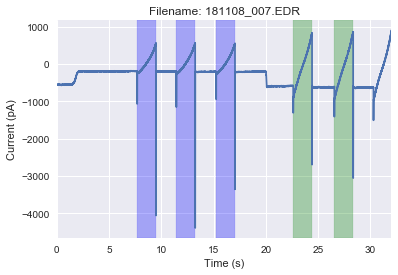

-300.0


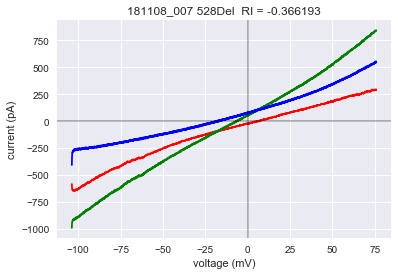

181108_007.EDR processed
total rows: 167
Processing row  104
total=  141716 start= 44000 end= 127000
Without duplicates:  [1534, 3334, 6216, 8016, 10146, 11946, 16920, 19943, 21743, 23685, 25485, 27242, 29042, 37980, 39780, 40516, 41343, 43143, 45026, 46826, 48902, 51457, 53257, 55945, 57745, 59316, 61116, 67178, 68978, 70610, 72410, 74293, 76093]
robust = [1534, 6216, 10146, 19943, 23685, 27242, 37980, 41343, 45026, 51457, 55945, 59316, 67178, 70610, 74293]
-2000.0
time len= 83000 I len= 83000


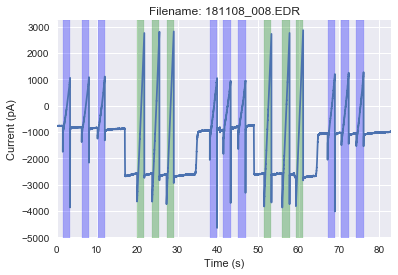

-2000.0


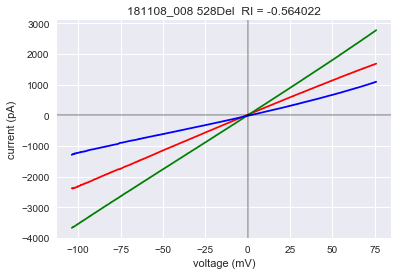

181108_008.EDR processed
total rows: 167
Processing row  105
total=  105788 start= 37000 end= 100000
Without duplicates:  [3865, 5665, 8044, 9844, 13835, 16404, 18204, 18440, 20475, 20651, 22451, 24644, 26444, 33939, 35739, 38250, 40050, 42489, 44289, 47563, 47979, 48103, 48401, 50288, 52088, 54094, 55894, 57845, 58028, 59828, 61099, 61832, 62076]
robust = [3865, 8044, 16404, 20651, 24644, 33939, 38250, 42489, 50288, 54094, 58028]
-1000.0
time len= 63000 I len= 63000


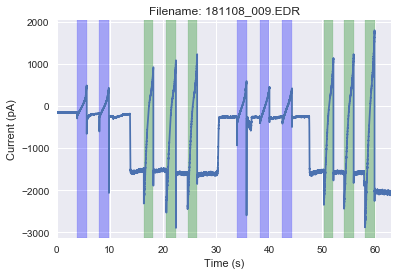

-1000.0


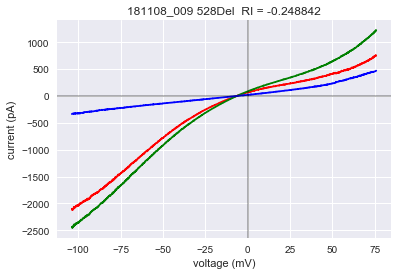

181108_009.EDR processed
total rows: 167
Processing row  106
total=  77844 start= 12000 end= 43000
Without duplicates:  [2781, 4581, 7403, 9203, 11083, 12883, 18320, 20120, 21938, 23738, 25371, 27171]
robust = [2781, 7403, 11083, 18320, 21938, 25371]
-800.0
time len= 31000 I len= 31000


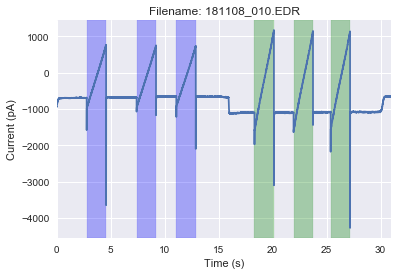

-800.0


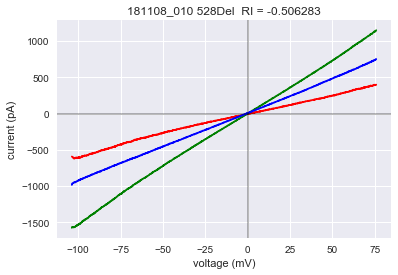

181108_010.EDR processed
total rows: 167
Processing row  107
total=  73852 start= 23000 end= 64000
Without duplicates:  [2701, 4501, 6449, 8249, 10192, 11992, 17491, 19291, 21358, 23158, 24914, 26714, 31655, 33455, 35024, 36824]
robust = [2701, 6449, 10192, 17491, 21358, 24914, 31655, 35024]
-1500.0
time len= 41000 I len= 41000


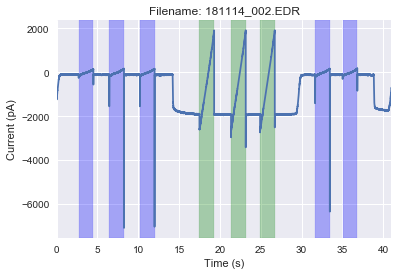

-1500.0


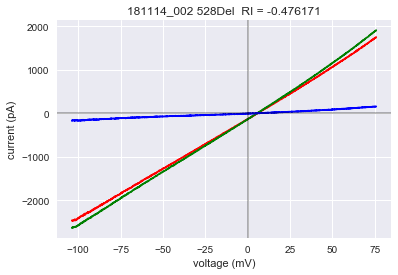

181114_002.EDR processed
total rows: 167
Processing row  108
total=  83832 start= 16000 end= 78000
Without duplicates:  [2087, 3887, 5765, 7565, 9385, 11185, 15752, 17552, 18994, 20794, 22551, 24351, 29042, 30842, 32284, 34084, 35656, 37456, 41151, 43643, 45443, 47392, 49192, 52446, 54246]
robust = [2087, 5765, 9385, 15752, 18994, 22551, 29042, 32284, 35656, 43643, 47392, 52446]
-1000.0
time len= 62000 I len= 62000


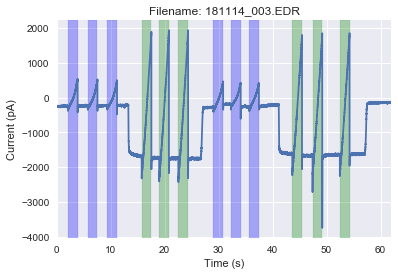

-1000.0


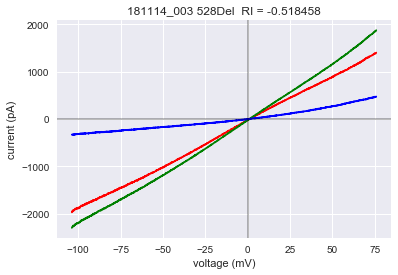

181114_003.EDR processed
total rows: 167
Processing row  109
total=  129740 start= 30000 end= 106000
Without duplicates:  [2122, 3922, 5865, 7665, 8823, 9795, 11595, 12702, 16913, 17017, 18713, 21529, 23329, 25085, 26885, 29774, 32075, 33875, 34942, 36192, 36387, 37896, 38603, 39998, 41798, 44528, 47050, 48850, 51791, 53591, 55598, 57398, 62837, 64637, 65147, 66829, 68629, 69580, 70081, 70703, 72489, 73556, 75458]
robust = [2122, 5865, 9795, 16913, 21529, 25085, 32075, 39998, 47050, 51791, 55598, 62837, 66829]
-1300.0
time len= 76000 I len= 76000


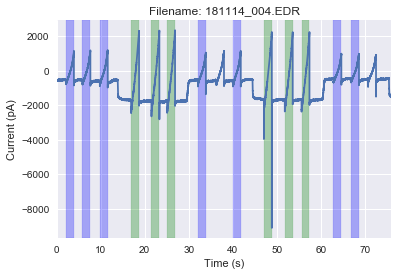

-1300.0


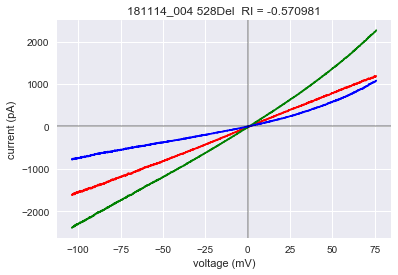

181114_004.EDR processed
total rows: 167
Processing row  110
total=  115768 start= 59000 end= 115768
Without duplicates:  [4266, 6066, 7885, 9685, 25306, 26977, 28777, 30912, 32712, 33572, 34112, 34864, 35108, 36706, 37056, 38570, 41768, 44077, 45877, 47633, 49433, 51316, 53116]
robust = [4266, 7885, 26977, 30912, 44077, 47633, 51316]
-1500.0
time len= 56768 I len= 56768


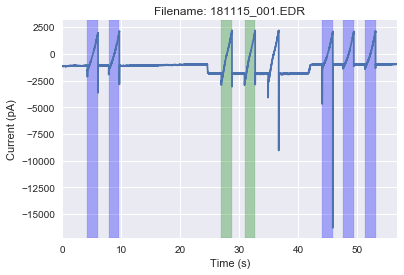

-1500.0


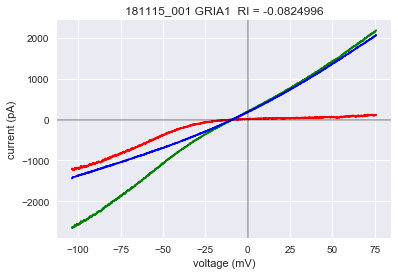

181115_001.EDR processed
total rows: 167
Processing row  111
total=  169660 start= 75000 end= 140000
Without duplicates:  [146, 4468, 6268, 7769, 9569, 12949, 14749, 19938, 21738, 23747, 25547, 29235, 31035, 36726, 38526, 39334, 39457, 40224, 40446, 42444, 45860, 46271, 46428, 48071, 49826, 51626, 54447, 54640, 56247, 61938, 63738, 64107, 64763, 64783]
robust = [4468, 7769, 12949, 19938, 23747, 29235, 36726, 46271, 49826, 54447, 61938]
-350.0
time len= 65000 I len= 65000


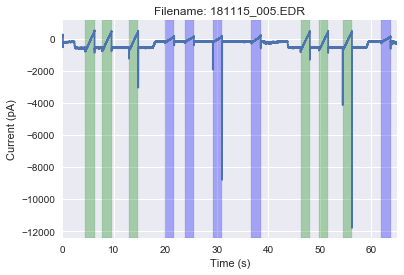

-350.0


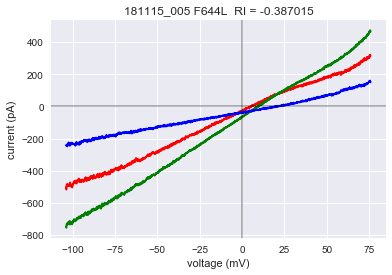

181115_005.EDR processed
total rows: 167
Processing row  112
total=  147704 start= 20000 end= 86000
Without duplicates:  [421, 3766, 5566, 7635, 9435, 11259, 13059, 15314, 16345, 16483, 16688, 17233, 17422, 19294, 19720, 20529, 20923, 21042, 22723, 22974, 24053, 24297, 24480, 24687, 26280, 27434, 28231, 28594, 28723, 30910, 32710, 34534, 34641, 36334, 38084, 39884, 43317, 43694, 43840, 43944, 44065, 45311, 46385, 46600, 48127, 48377, 49123, 49753, 51553, 52489, 52800, 53253, 53423, 55053, 55883, 56061, 56188, 56665, 57645, 58093, 60298, 62098, 64857]
robust = [3766, 7635, 11259, 20923, 24480, 30910, 34534, 38084, 49753, 53253, 60298]
-1000.0
time len= 66000 I len= 66000


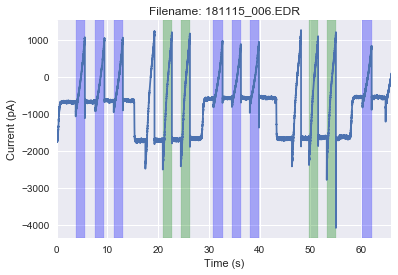

-1000.0


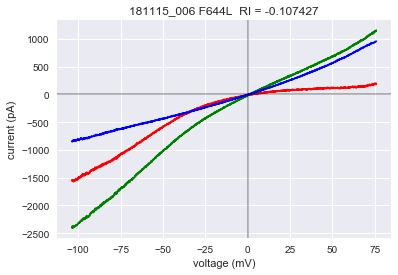

181115_006.EDR processed
total rows: 167
Processing row  113
total=  133732 start= 79000 end= 112000
Without duplicates:  [1339, 3139, 6023, 7823, 9768, 11568, 15882, 17682, 19247, 21047, 23306, 25106]
robust = [1339, 6023, 9768, 15882, 19247, 23306]
-500.0
time len= 33000 I len= 33000


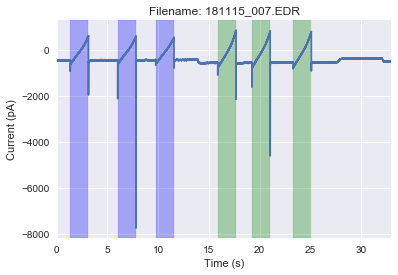

-500.0


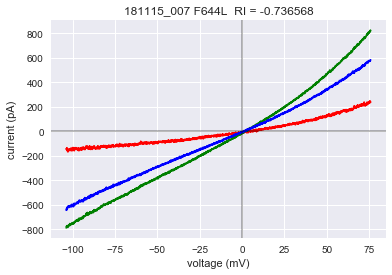

181115_007.EDR processed
total rows: 167
Processing row  114
total=  87824 start= 27000 end= 71000
Without duplicates:  [2571, 4371, 7565, 9365, 13169, 15596, 17987, 19787, 21289, 23089, 25096, 26896, 33898, 35698, 38141, 39941, 42384]
robust = [2571, 7565, 17987, 21289, 25096, 33898, 38141]
-2000.0
time len= 44000 I len= 44000


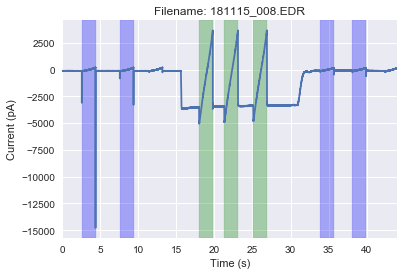

-2000.0


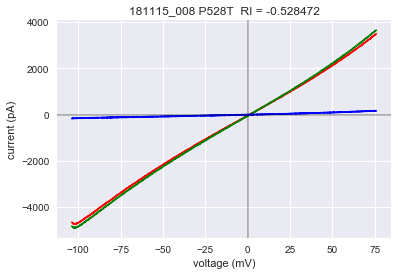

181115_008.EDR processed
total rows: 167
Processing row  115
total=  175648 start= 26000 end= 80000
Without duplicates:  [2764, 4564, 6754, 8554, 10747, 12547, 16068, 18544, 20344, 22665, 24465, 26661, 28461, 33215, 34736, 34975, 35983, 36187, 40073, 40239, 41873, 44012, 45812, 47751, 49551, 50136, 53140]
robust = [2764, 6754, 10747, 18544, 22665, 26661, 40073, 44012, 47751]
-2000.0
time len= 54000 I len= 54000


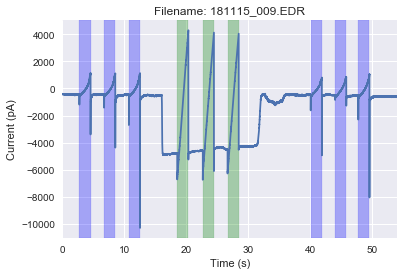

-2000.0


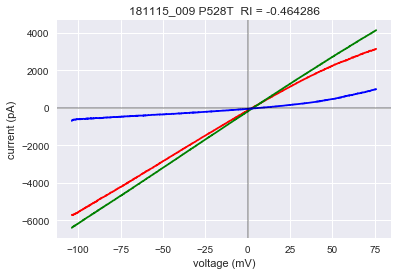

181115_009.EDR processed
total rows: 167
Processing row  116
total=  387224 start= 82000 end= 122000
Without duplicates:  [2388, 4188, 5882, 7682, 9686, 11486, 12621, 17804, 19604, 21295, 23095, 24727, 26527, 32033, 33833, 35332, 37132, 39327]
robust = [2388, 5882, 9686, 17804, 21295, 24727, 32033, 35332]
-500.0
time len= 40000 I len= 40000


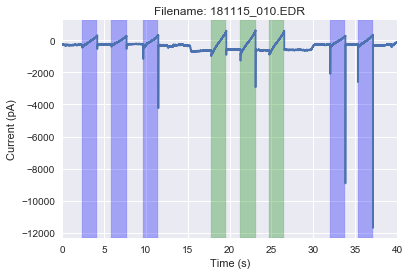

-500.0


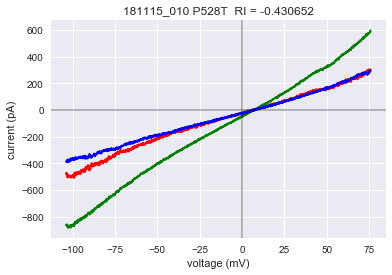

181115_010.EDR processed
total rows: 167
Processing row  117
total=  387224 start= 82000 end= 122000
Without duplicates:  [2388, 4188, 5882, 7682, 9686, 11486, 12621, 17804, 19604, 21295, 23095, 24727, 26527, 32033, 33833, 35332, 37132, 39327]
robust = [2388, 5882, 9686, 17804, 21295, 24727, 32033, 35332]
-500.0
time len= 40000 I len= 40000


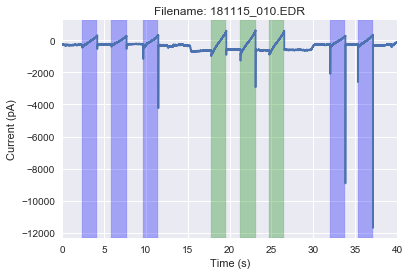

-500.0


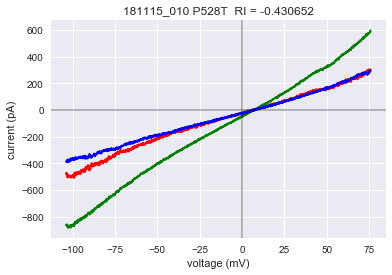

181115_010.EDR processed
total rows: 167
Processing row  118
total=  163672 start= 24000 end= 89000
Without duplicates:  [2136, 3936, 5814, 7614, 9685, 11485, 14279, 16613, 18413, 20042, 21842, 23411, 25211, 29905, 31705, 33522, 35322, 37329, 39129, 42996, 45879, 47679, 50431, 50561, 52231, 53926, 55726, 64037]
robust = [2136, 5814, 9685, 16613, 20042, 23411, 29905, 33522, 37329, 45879, 50431, 53926]
-2000.0
time len= 65000 I len= 65000


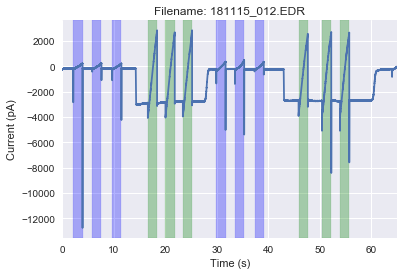

-2000.0


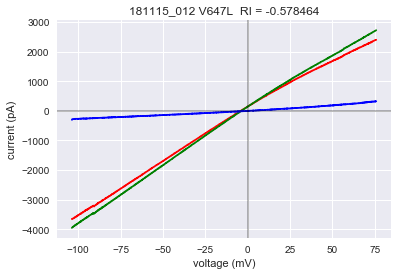

181115_012.EDR processed
total rows: 167
Processing row  119
total=  97804 start= 19000 end= 80000
Without duplicates:  [1772, 3572, 5643, 7443, 9446, 11246, 13716, 15878, 17678, 19682, 21482, 23423, 25223, 30226, 32026, 34343, 36143, 37777, 39577, 41768, 44022, 45822, 47635, 49435, 51006, 52806, 58056, 59856, 60702]
robust = [1772, 5643, 9446, 15878, 19682, 23423, 30226, 34343, 37777, 44022, 47635, 51006, 58056]
-1200.0
time len= 61000 I len= 61000


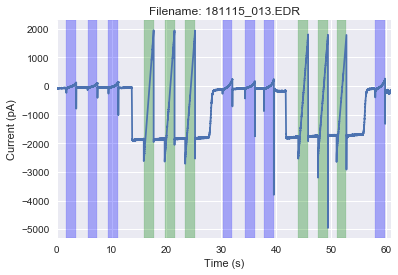

-1200.0


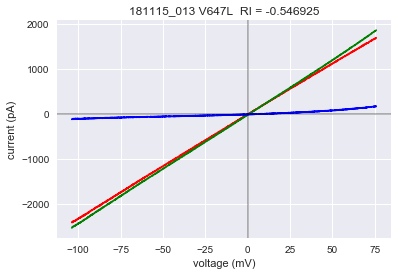

181115_013.EDR processed
total rows: 167
Processing row  120
total=  133732 start= 24000 end= 61000
Without duplicates:  [2013, 3813, 5820, 7620, 9561, 11361, 16553, 18353, 20175, 21975, 24602, 26402, 31844, 33644]
robust = [2013, 5820, 9561, 16553, 20175, 24602, 31844]
-400.0
time len= 37000 I len= 37000


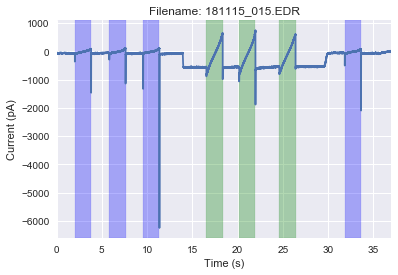

-400.0


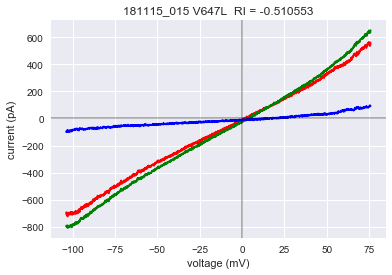

181115_015.EDR processed
total rows: 167
Processing row  121
total=  125748 start= 81000 end= 119000
Without duplicates:  [1346, 4981, 7193, 9099, 10899, 11606, 13024, 14824, 16646, 18446, 24696, 26496, 27938, 29738, 31558, 33358, 36956, 37004]
robust = [9099, 13024, 16646, 24696, 27938, 31558]
-2000.0
time len= 38000 I len= 38000


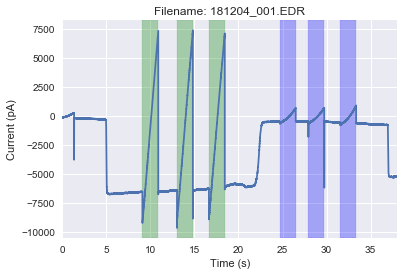

-2000.0


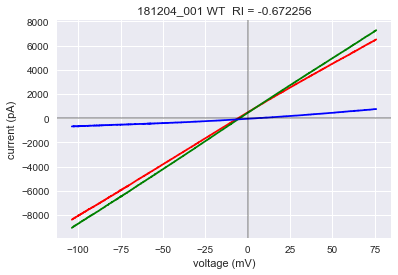

181204_001.EDR processed
total rows: 167
Processing row  122
total=  81836 start= 4000 end= 77000
Without duplicates:  [17519, 19319, 24247, 28056, 34555, 36355, 38548, 40348, 42354, 44154, 51150, 52950, 55646, 57446, 59451, 61251]
robust = [17519, 34555, 38548, 42354, 51150, 55646, 59451]
-100.0
time len= 73000 I len= 73000


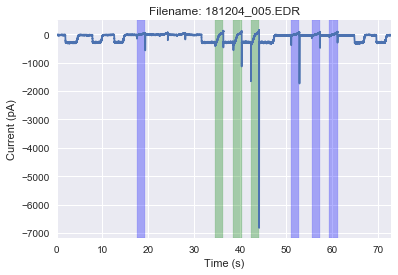

-100.0


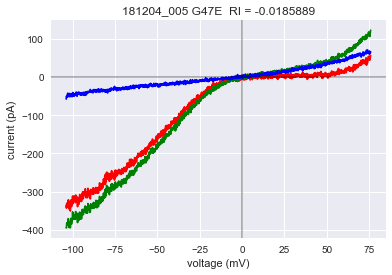

181204_005.EDR processed
total rows: 167
Processing row  123
total=  123752 start= 50000 end= 112000
Without duplicates:  [4332, 6401, 8201, 10336, 12136, 30985, 32785, 34731, 36531, 40908, 42708, 44776, 46576, 50321, 61554]
robust = [6401, 10336, 30985, 34731, 40908, 44776]
-50.0
time len= 62000 I len= 62000


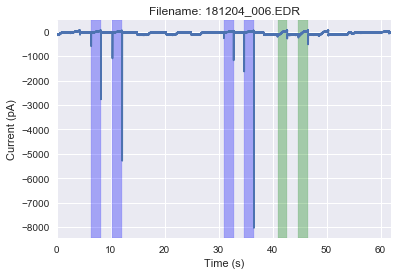

-50.0


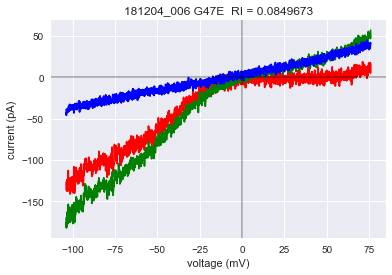

181204_006.EDR processed
total rows: 167
Processing row  124
total=  107784 start= 47000 end= 96000
Without duplicates:  [2601, 4401, 6028, 7828, 15515, 17315, 19141, 20941, 23690, 25490, 32927, 34727, 36548, 38348, 40168, 41968]
robust = [2601, 6028, 15515, 19141, 23690, 32927, 36548, 40168]
-2000.0
time len= 49000 I len= 49000


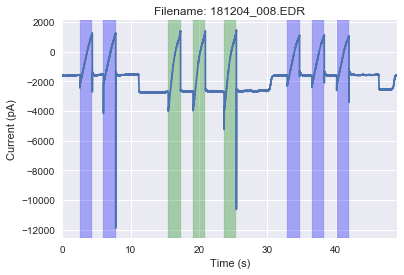

-2000.0


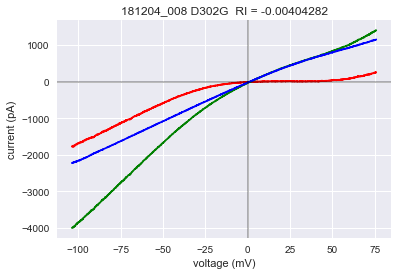

181204_008.EDR processed
total rows: 167
Processing row  125
total=  389220 start= 123000 end= 170000
Without duplicates:  [3256, 5056, 7808, 9608, 13357, 19850, 21650, 25707, 28530, 30330]
robust = [3256, 7808, 19850, 28530]
-50.0
time len= 47000 I len= 47000


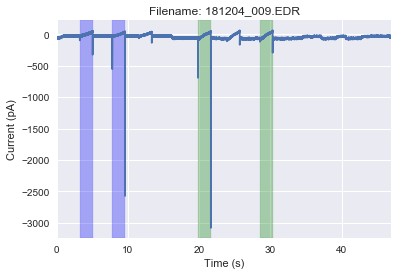

-50.0


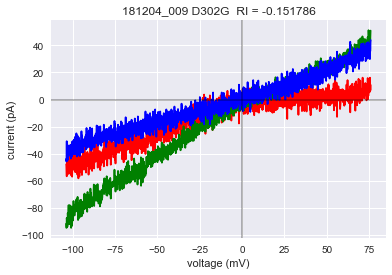

181204_009.EDR processed
total rows: 167
Processing row  126
total=  389220 start= 123000 end= 170000
Without duplicates:  [3256, 5056, 7808, 9608, 13357, 19850, 21650, 25707, 28530, 30330]
robust = [3256, 7808, 19850, 28530]
-50.0
time len= 47000 I len= 47000


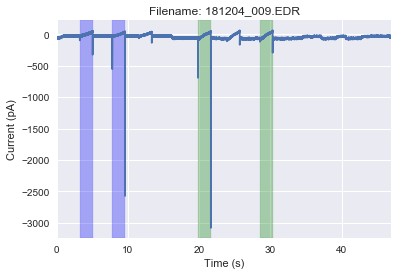

-50.0


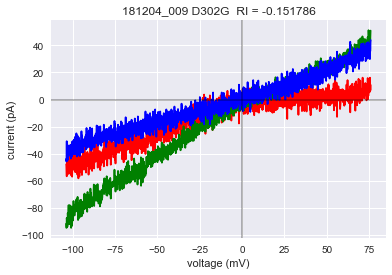

181204_009.EDR processed
total rows: 167
Processing row  127
total=  141716 start= 49000 end= 102000
Without duplicates:  [4159, 5959, 8025, 9825, 11523, 13323, 16939, 19692, 21492, 23377, 25177, 27743, 29543, 36478, 38278, 40159, 41959, 43591, 45391, 49467, 52391]
robust = [4159, 8025, 11523, 19692, 23377, 27743, 36478, 40159, 43591]
-2000.0
time len= 53000 I len= 53000


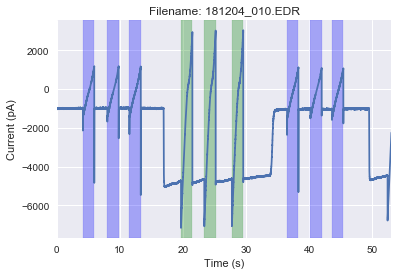

-2000.0


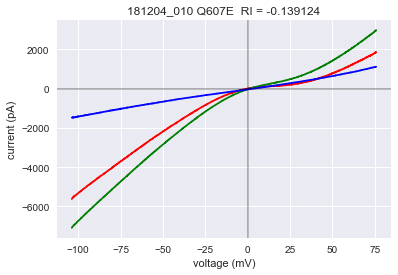

181204_010.EDR processed
total rows: 167
Processing row  128
total=  169660 start= 19000 end= 102000
Without duplicates:  [5704, 7504, 9385, 9582, 11185, 13380, 15180, 18996, 19367, 19753, 21274, 21721, 21988, 22125, 23788, 24186, 24577, 25100, 25418, 25797, 27597, 28119, 28455, 28805, 29658, 29854, 30141, 31654, 32406, 32518, 32882, 33059, 34389, 36406, 38034, 38511, 39168, 39425, 43642, 45442, 46037, 47762, 49562, 51947, 53747, 57026, 57196, 57505, 57691, 58018, 58361, 58510, 58866, 60177, 61981, 62335, 62597, 63219, 63929, 65729, 66327, 66540, 67625, 67751, 67898, 68664, 68851, 70464, 70601, 71366, 71703, 72395, 72859, 73157, 73281]
robust = [5704, 9385, 13380, 21988, 25797, 29854, 43642, 47762, 51947, 63929, 68664]
-1000.0
time len= 83000 I len= 83000


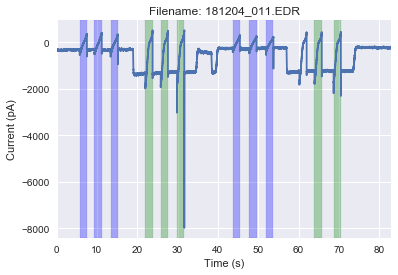

-1000.0


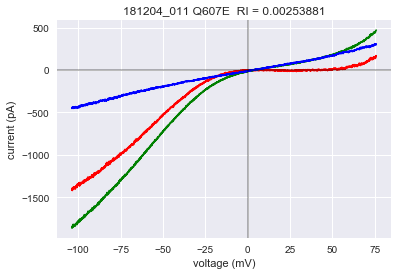

181204_011.EDR processed
total rows: 167
Processing row  129
total=  115768 start= 17000 end= 86000
Without duplicates:  [5197, 6997, 8565, 10365, 12187, 13987, 18674, 20474, 22356, 24156, 26352, 28152, 30094, 31894, 37710, 39510, 41455, 43255, 45072, 46872, 51002, 52802, 55117, 56917, 59175, 60975]
robust = [5197, 8565, 12187, 18674, 22356, 26352, 30094, 37710, 41455, 45072, 51002, 55117, 59175]
-500.0
time len= 69000 I len= 69000


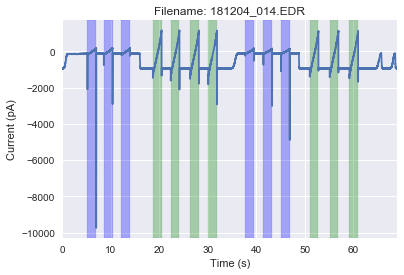

-500.0


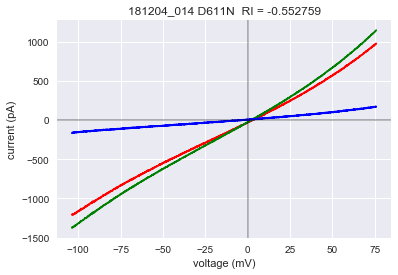

181204_014.EDR processed
total rows: 167
Processing row  130
total=  141716 start= 49000 end= 124000
Without duplicates:  [4221, 6021, 8214, 10014, 15068, 18750, 19254, 19777, 19899, 20068, 20373, 20860, 22221, 22999, 23150, 24799, 25026, 25426, 26748, 27024, 28548, 28718, 28864, 29614, 29786, 29956, 30064, 30762, 31054, 31407, 32854, 33501, 34451, 36352, 38724, 40524, 42593, 44393, 48325, 51371, 51721, 52097, 52387, 53753, 55056, 55200, 55516, 57000, 57690, 57831, 58094, 58380, 58480, 58869, 59003, 59238, 60803, 61383, 62484, 62649, 62813, 63040, 64613, 66296, 67714, 68139, 74153, 74359, 74468, 74889]
robust = [4221, 8214, 22999, 26748, 31054, 38724, 42593, 55200, 59003, 62813]
-1000.0
time len= 75000 I len= 75000


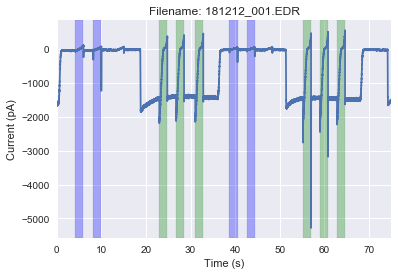

-1000.0


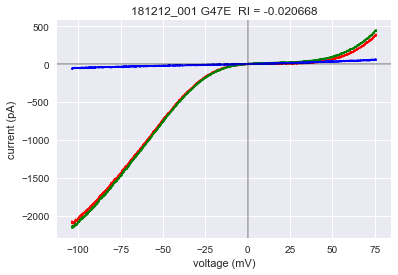

181212_001.EDR processed
total rows: 167
Processing row  131
total=  1257480 start= 74000 end= 142000
Without duplicates:  [1954, 3060, 4922, 7303, 9103, 11360, 13160, 17089, 17337, 17503, 17963, 18614, 19371, 19686, 19904, 20038, 21704, 22070, 22217, 22542, 23291, 23854, 24458, 26258, 26659, 27214, 29015, 29175, 30815, 31546, 31961, 32124, 32974, 33194, 33468, 34994, 35590, 36577, 36770, 37127, 37555, 37999, 38127, 41123, 42923, 45861, 47661, 50291, 50938, 52091, 55222, 57022]
robust = [7303, 11360, 19904, 24458, 29015, 33194, 41123, 45861, 50291, 55222]
-1400.0
time len= 68000 I len= 68000


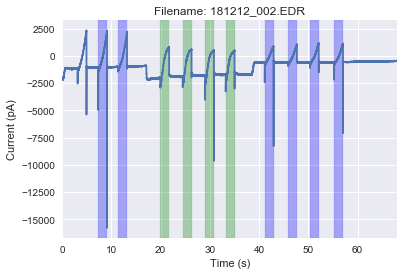

-1400.0


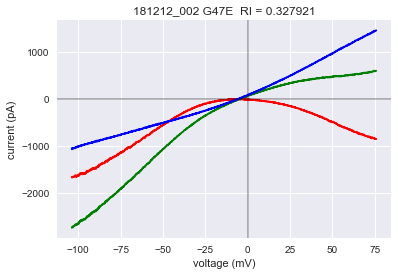

181212_002.EDR processed
total rows: 167
Processing row  132
total=  119760 start= 32000 end= 72000
Without duplicates:  [5311, 7111, 9800, 11600, 14356, 16156, 22408, 24208, 26029, 27829, 29833, 31633, 39319]
robust = [5311, 9800, 14356, 22408, 26029, 29833]
-200.0
time len= 40000 I len= 40000


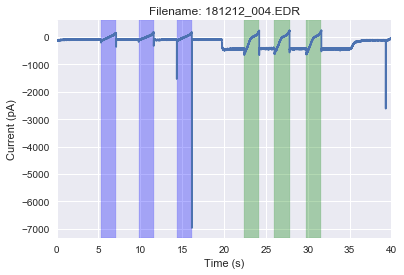

-200.0


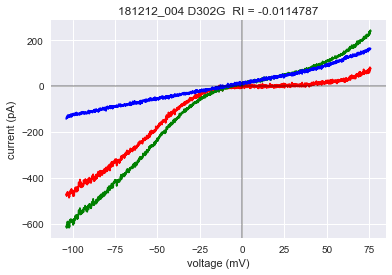

181212_004.EDR processed
total rows: 167
Processing row  133
total=  165668 start= 83000 end= 122000
Without duplicates:  [806, 2067, 5373, 6371, 7786, 9586, 9883, 10858, 11333, 11528, 13328, 13893, 15275, 17075, 17681, 19687, 23510, 25310, 27132, 28932, 30936, 32736, 37117]
robust = [7786, 11528, 15275, 23510, 27132, 30936]
-700.0
time len= 39000 I len= 39000


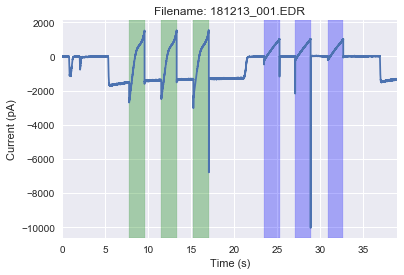

-700.0


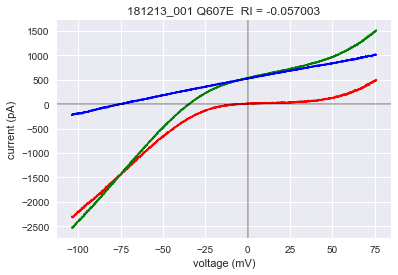

181213_001.EDR processed
total rows: 167
Processing row  134
total=  139720 start= 42000 end= 108000
Without duplicates:  [5040, 6840, 8852, 10652, 12902, 14702, 18198, 18979, 20582, 22382, 24447, 26247, 28192, 29992, 30182, 35306, 37106, 39171, 40971, 43042, 44842, 47850, 51090, 52890, 54896, 56696, 58704, 60504]
robust = [5040, 8852, 12902, 20582, 24447, 28192, 35306, 39171, 43042, 51090, 54896, 58704]
-1000.0
time len= 66000 I len= 66000


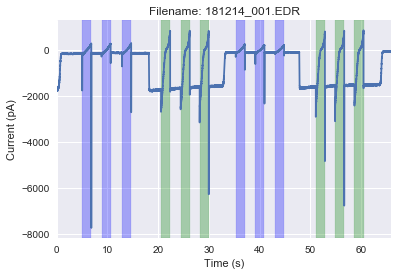

-1000.0


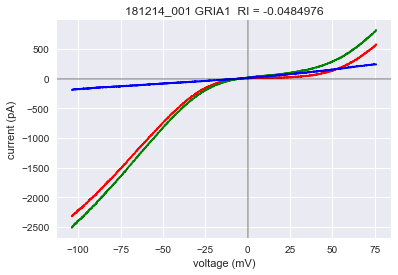

181214_001.EDR processed
total rows: 167
Processing row  135
total=  149700 start= 39000 end= 122000
Without duplicates:  [4685, 10425, 20701, 22501, 24385, 26185, 28133, 29933, 32683, 35426, 37226, 39236, 41036, 44412, 46212, 51963, 53763, 56024, 57824, 59450, 61250, 63837, 65942, 67742, 71559, 73359, 75678, 77478]
robust = [20701, 24385, 28133, 35426, 39236, 44412, 51963, 56024, 59450, 65942, 71559, 75678]
-1000.0
time len= 83000 I len= 83000


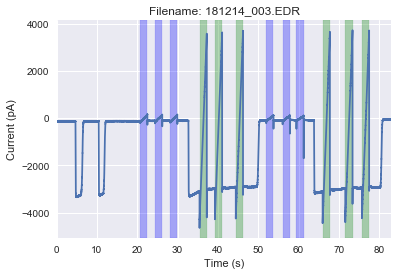

-1000.0


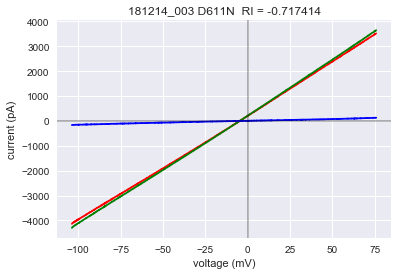

181214_003.EDR processed
total rows: 167
Processing row  136
total=  111776 start= 3000 end= 76000
Without duplicates:  [5502, 12532, 18027, 23638, 25438, 28256, 30056, 32000, 33800, 37503, 41049, 42849, 47728, 49528, 51784, 53584, 58586, 60386, 62453, 64253, 66260, 68060, 71799, 71817]
robust = [23638, 28256, 32000, 41049, 47728, 51784, 58586, 62453, 66260]
-1000.0
time len= 73000 I len= 73000


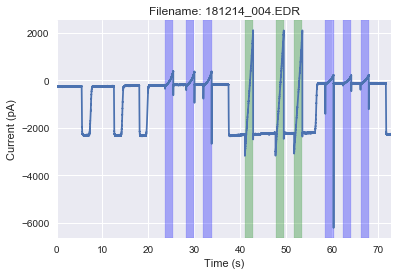

-1000.0


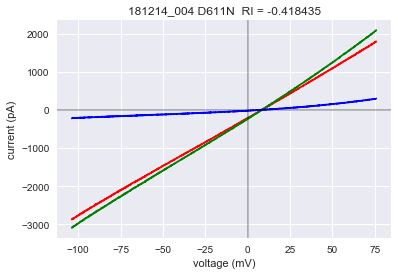

181214_004.EDR processed
total rows: 167
Processing row  137
total=  93812 start= 3000 end= 72000
Without duplicates:  [22825, 24625, 26512, 28312, 30438, 32238, 34620, 36420, 40300, 42100, 44168, 45968, 47661, 49461, 55399, 57199, 59022, 60822, 63077, 64877, 68628]
robust = [22825, 26512, 30438, 34620, 40300, 44168, 47661, 55399, 59022, 63077]
-700.0
time len= 69000 I len= 69000


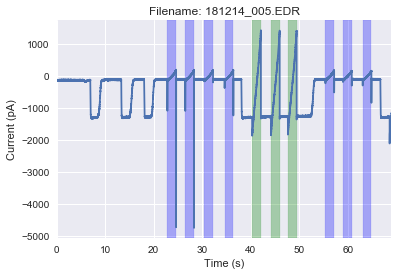

-700.0


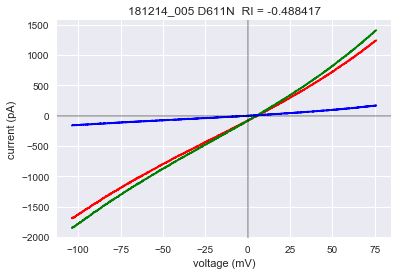

181214_005.EDR processed
total rows: 167
Processing row  138
total=  121756 start= 61000 end= 117000
Without duplicates:  [4953, 6753, 9885, 11685, 14623, 16423, 23486, 25286, 27044, 28844, 30721, 32521, 38025, 39825, 45076, 46876, 48696, 50496]
robust = [4953, 9885, 14623, 23486, 27044, 30721, 38025, 45076, 48696]
-300.0
time len= 56000 I len= 56000


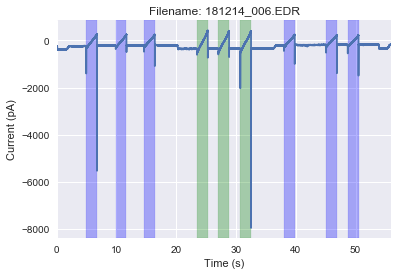

-300.0


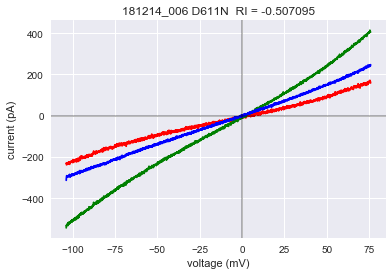

181214_006.EDR processed
total rows: 167
Processing row  139
total=  205588 start= 121000 end= 160000
Without duplicates:  [2162, 3962, 5720, 7520, 9280, 11080, 13273, 15896, 17696, 19323, 21123, 22947, 24747, 29682, 31482, 33550, 35350, 37420]
robust = [2162, 5720, 9280, 15896, 19323, 22947, 29682, 33550]
-500.0
time len= 39000 I len= 39000


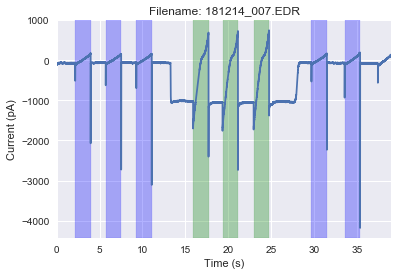

-500.0


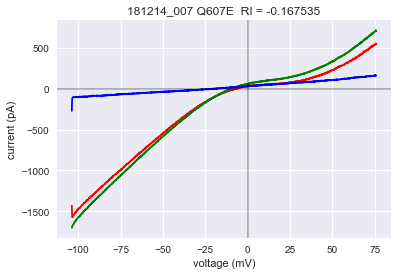

181214_007.EDR processed
total rows: 167
Processing row  140
total=  93812 start= 17000 end= 80000
Without duplicates:  [5394, 7194, 9137, 10937, 12695, 14495, 16990, 17603, 17753, 18360, 18721, 18872, 19005, 20672, 21184, 22292, 22643, 24104, 24941, 25573, 25785, 25920, 26316, 27720, 29886, 32223, 34023, 35655, 37455, 39152, 40952, 43385, 43760, 44659, 45578, 47378, 47890, 48129, 49680, 49868, 50210, 50575, 50730, 52375, 52738, 53185, 53820, 54130, 54242, 54723, 55930, 56190, 56424, 56947, 58171, 61427]
robust = [5394, 9137, 12695, 18872, 25920, 32223, 35655, 39152, 45578, 50575, 54130]
-1000.0
time len= 63000 I len= 63000


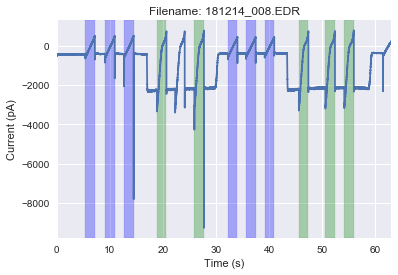

-1000.0


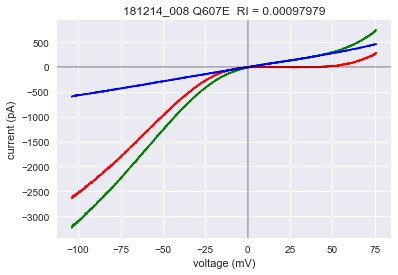

181214_008.EDR processed
total rows: 167
Processing row  141
total=  91816 start= 31000 end= 86000
Without duplicates:  [3530, 6774, 11551, 13351, 15542, 17342, 19350, 21150, 23815, 25715, 27515, 29464, 31264, 33141, 34941, 39755, 41555, 43436, 45236, 47056, 48856, 53116, 53146]
robust = [11551, 15542, 19350, 25715, 29464, 33141, 39755, 43436, 47056]
-2000.0
time len= 55000 I len= 55000


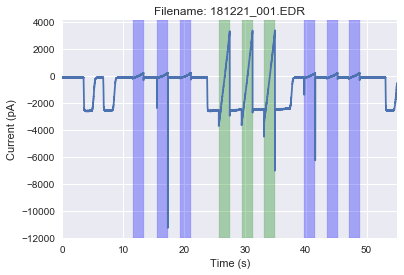

-2000.0


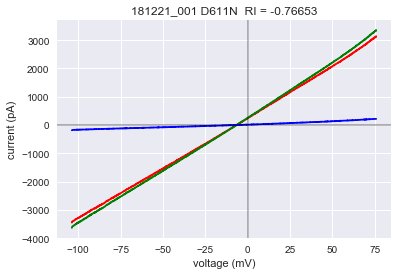

181221_001.EDR processed
total rows: 167
Processing row  142
total=  93812 start= 3000 end= 85000
Without duplicates:  [17522, 19322, 21267, 23067, 25323, 27123, 33375, 35175, 37614, 39414, 41670, 43470, 49097, 50897, 52966, 54766, 57208, 59008, 64945, 66745, 68939, 70739, 72815, 74615]
robust = [17522, 21267, 25323, 33375, 37614, 41670, 49097, 52966, 57208, 64945, 68939, 72815]
-400.0
time len= 82000 I len= 82000


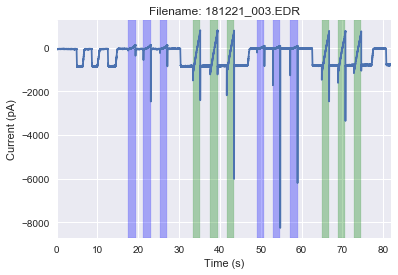

-400.0


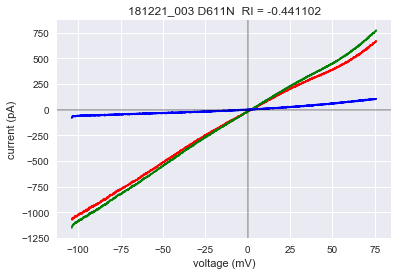

181221_003.EDR processed
total rows: 167
Processing row  143
total=  79840 start= 18000 end= 79840
Without duplicates:  [2832, 4632, 6889, 8689, 10694, 12494, 17933, 19733, 21678, 23478, 25485, 27285, 32601, 34401, 36341, 38141, 40088, 41888]
robust = [2832, 6889, 10694, 17933, 21678, 25485, 32601, 36341, 40088]
-1500.0
time len= 61840 I len= 61840


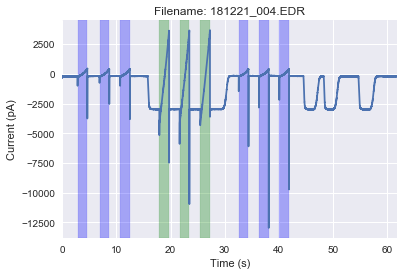

-1500.0


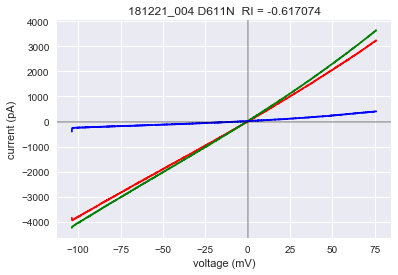

181221_004.EDR processed
total rows: 167
Processing row  144
total=  123752 start= 24000 end= 112000
Without duplicates:  [3375, 5175, 7557, 9357, 11799, 13599, 18602, 20402, 22285, 24085, 26341, 28141, 34951, 36751, 38756, 40556, 42686, 44486, 51185, 53233, 55033, 57038, 58838, 61155, 62955, 75449, 77249, 79071, 80871, 83496, 85296]
robust = [3375, 7557, 11799, 18602, 22285, 26341, 34951, 38756, 42686, 53233, 57038, 61155, 75449, 79071, 83496]
-2000.0
time len= 88000 I len= 88000


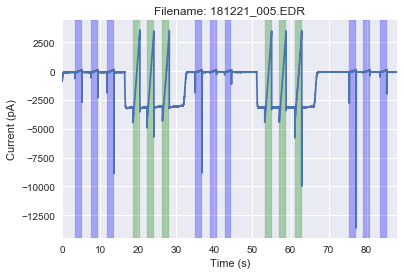

-2000.0


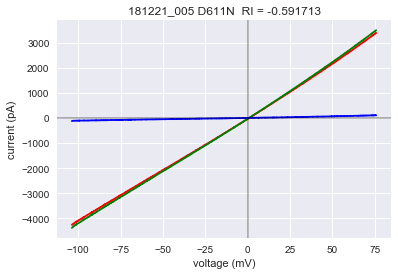

181221_005.EDR processed
total rows: 167
Processing row  145
total=  149700 start= 15000 end= 62000
Without duplicates:  [3403, 5203, 7026, 8826, 11641, 13441, 18627, 20427, 22371, 24171, 25803, 27603, 32791, 34591, 36848, 38648, 41156, 42956]
robust = [3403, 7026, 11641, 18627, 22371, 25803, 32791, 36848, 41156]
-800.0
time len= 47000 I len= 47000


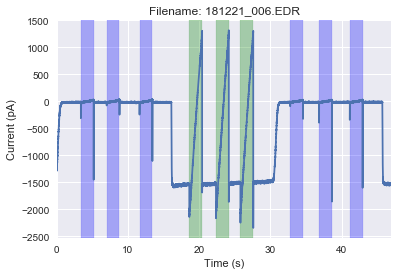

-800.0


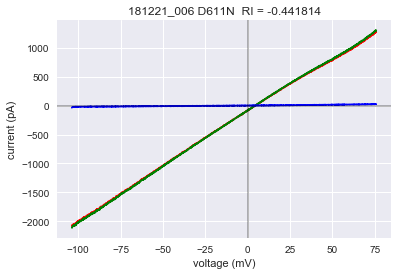

181221_006.EDR processed
total rows: 167
Processing row  146
total=  171656 start= 83000 end= 147000
Without duplicates:  [2666, 4466, 7032, 8832, 10464, 12264, 14627, 14890, 16708, 18508, 19246, 19882, 20264, 22064, 24007, 25807, 25944, 26664, 27120, 27365, 30993, 32793, 34802, 36602, 38859, 40659, 43998, 45705, 46409, 48209, 50277, 52077, 54152, 55952, 57908, 62695]
robust = [2666, 7032, 10464, 16708, 20264, 24007, 30993, 34802, 38859, 46409, 50277, 54152]
-1000.0
time len= 64000 I len= 64000


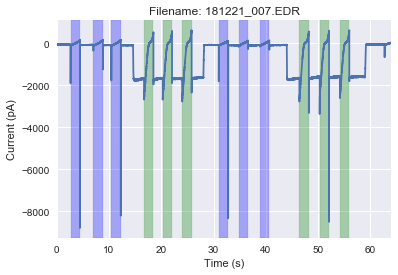

-1000.0


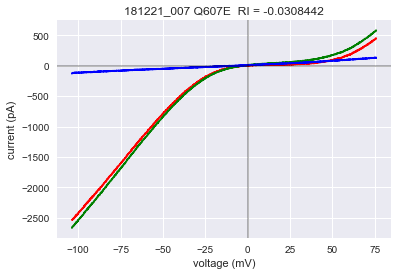

181221_007.EDR processed
total rows: 167
Processing row  147
total=  101796 start= 19000 end= 90000
Without duplicates:  [9306, 11184, 12984, 15116, 16916, 23193, 24266, 25479, 27279, 27965, 29345, 31145, 33029, 34829, 40513, 42313, 46120, 48689, 50489, 53259, 54489, 55238, 55399, 55510, 57038, 57661, 58258, 58686, 58927, 60727, 61361, 62601, 64401, 65524, 66562, 66844, 69054, 70316]
robust = [11184, 15116, 25479, 29345, 33029, 40513, 48689, 55238, 58927, 62601]
-1000.0
time len= 71000 I len= 71000


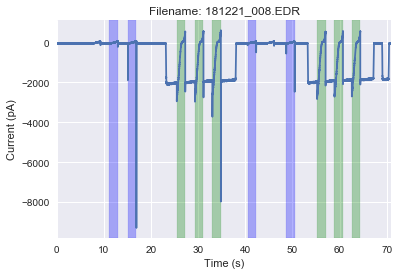

-1000.0


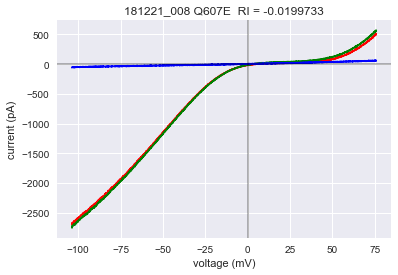

181221_008.EDR processed
total rows: 167
Processing row  148
total=  161676 start= 58000 end= 130000
Without duplicates:  [102, 5327, 7127, 9195, 10995, 13442, 15242, 17219, 17462, 18736, 19431, 21231, 21615, 22917, 23169, 23798, 25598, 26074, 26445, 27592, 27914, 29714, 30440, 30616, 31439, 31593, 34472, 36272, 38461, 40261, 42518, 44318, 47562, 47830, 48161, 48347, 49755, 51555, 52226, 52668, 53208, 53411, 54000, 55800, 56022, 56932, 57807, 59607, 59971, 61767, 61899]
robust = [5327, 9195, 13442, 19431, 23798, 27914, 34472, 38461, 42518, 49755, 54000, 57807]
-1000.0
time len= 72000 I len= 72000


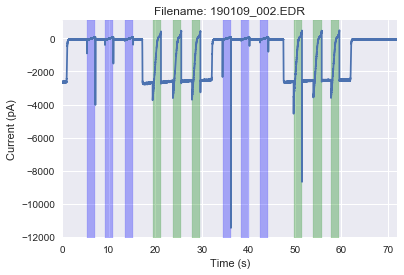

-1000.0


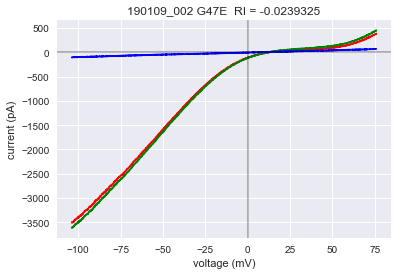

190109_002.EDR processed
total rows: 167
Processing row  149
total=  51896 start= 5000 end= 51896
Without duplicates:  [13713, 15513, 17646, 19446, 21453, 23253, 26569, 28369, 28607, 30790, 33991, 35791, 37862, 39662, 41794, 41958, 43594]
robust = [13713, 17646, 21453, 26569, 33991, 37862, 41794]
-250.0
time len= 46896 I len= 46896


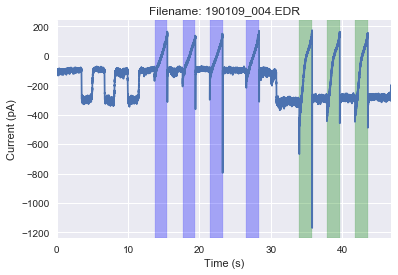

-250.0


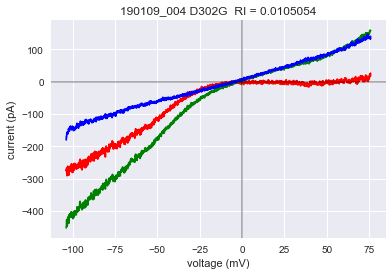

190109_004.EDR processed
total rows: 167
Processing row  150
total=  205588 start= 59000 end= 142000
Without duplicates:  [8433, 8555, 11778, 14249, 14392, 16049, 18118, 19918, 21861, 23661, 29724, 31524, 35463, 37263, 41146, 42946, 48387, 50187, 52000, 53800, 55558, 57358, 65856, 67656, 71412, 73212, 74653, 76453]
robust = [14249, 18118, 21861, 29724, 35463, 41146, 48387, 52000, 55558, 65856, 71412, 74653]
-500.0
time len= 83000 I len= 83000


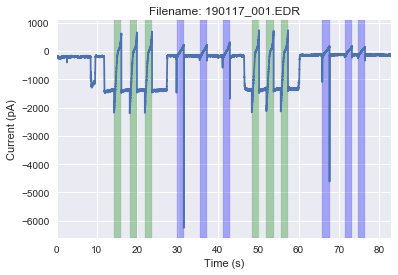

-500.0


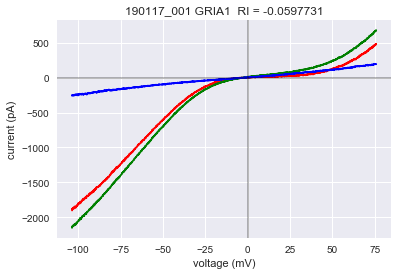

190117_001.EDR processed
total rows: 167
Processing row  151
total=  251496 start= 9000 end= 99000
Without duplicates:  [11523, 13323, 15265, 17065, 19381, 21181, 26059, 27859, 30302, 32102, 34171, 35971, 41719, 43519, 45527, 47327, 49272, 51072, 60131, 61931, 63502, 65302, 67304, 69104, 74920, 76720, 78977, 80777, 83091, 84891]
robust = [11523, 15265, 19381, 26059, 30302, 34171, 41719, 45527, 49272, 60131, 63502, 67304, 74920, 78977, 83091]
-700.0
time len= 90000 I len= 90000


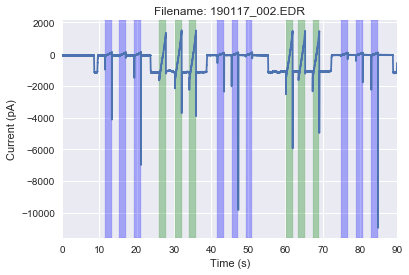

-700.0


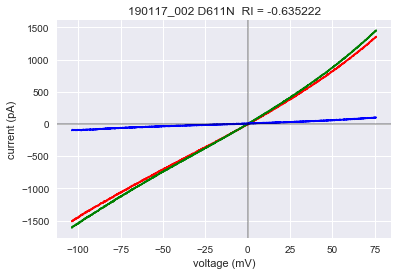

190117_002.EDR processed
total rows: 167
Processing row  152
total=  251496 start= 9000 end= 99000
Without duplicates:  [11523, 13323, 15265, 17065, 19381, 21181, 26059, 27859, 30302, 32102, 34171, 35971, 41719, 43519, 45527, 47327, 49272, 51072, 60131, 61931, 63502, 65302, 67304, 69104, 74920, 76720, 78977, 80777, 83091, 84891]
robust = [11523, 15265, 19381, 26059, 30302, 34171, 41719, 45527, 49272, 60131, 63502, 67304, 74920, 78977, 83091]
-700.0
time len= 90000 I len= 90000


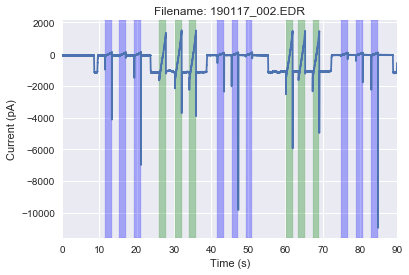

-700.0


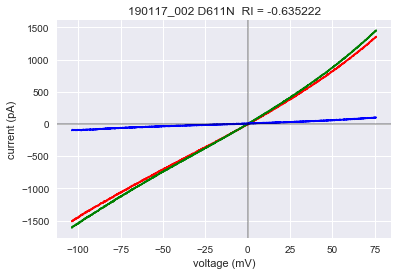

190117_002.EDR processed
total rows: 167
Processing row  153
total=  183632 start= 79000 end= 156000
Without duplicates:  [7042, 8842, 10785, 12585, 14409, 16209, 21274, 23073, 25263, 27063, 28631, 30431, 37620, 39420, 43048, 44848, 47164, 48964, 53096, 54896, 63203, 65003, 67447, 69247, 70813, 72613]
robust = [7042, 10785, 14409, 25263, 28631, 37620, 43048, 47164, 53096, 63203, 67447, 70813]
-600.0
time len= 77000 I len= 77000


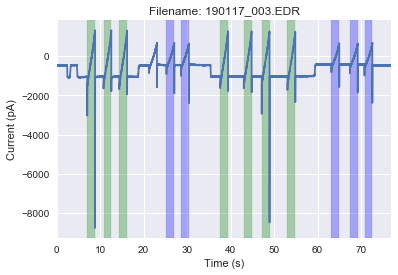

-600.0


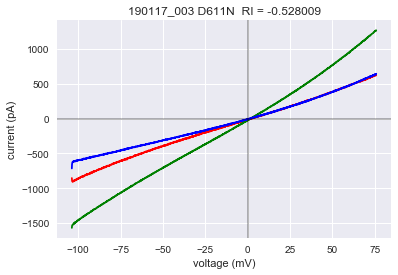

190117_003.EDR processed
total rows: 167
Processing row  154
total=  179640 start= 83000 end= 162000
Without duplicates:  [475, 4904, 7350, 9150, 10968, 12768, 14400, 16200, 16994, 19461, 22698, 24498, 26378, 28178, 30191, 31991, 35603, 37615, 39415, 41298, 43098, 44334, 44977, 46777, 47004, 52901, 54701, 61760, 63560, 65509, 67309]
robust = [7350, 10968, 14400, 22698, 26378, 30191, 37615, 41298, 44977, 52901, 61760, 65509]
-1500.0
time len= 79000 I len= 79000


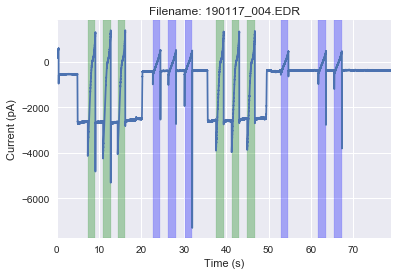

-1500.0


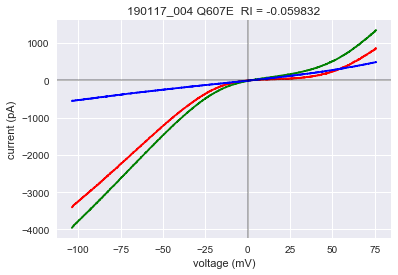

190117_004.EDR processed
total rows: 167
Processing row  155
total=  147704 start= 39000 end= 122000
Without duplicates:  [12284, 14084, 15906, 17706, 19709, 21509, 24161, 30198, 31998, 33502, 35302, 37368, 39168, 44731, 46531, 48419, 50219, 52161, 53961, 56874, 58215, 59270, 61070, 63706, 65506, 67262, 69062, 74182]
robust = [12284, 15906, 19709, 30198, 33502, 37368, 44731, 48419, 52161, 59270, 63706, 67262]
-1500.0
time len= 83000 I len= 83000


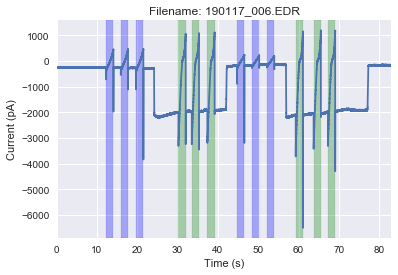

-1500.0


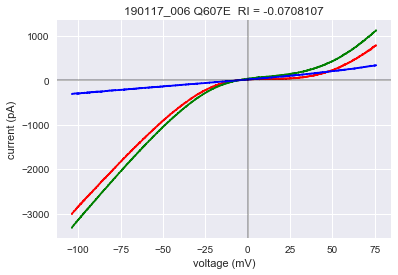

190117_006.EDR processed
total rows: 167
Processing row  156
total=  77844 start= 23000 end= 69000
Without duplicates:  [3012, 3451, 4812, 6756, 8556, 10374, 12174, 16490, 18290, 21108, 22908, 25167, 26967, 31657, 33457, 35712, 37512, 39519, 41319]
robust = [3012, 6756, 10374, 16490, 21108, 25167, 31657, 35712, 39519]
-300.0
time len= 46000 I len= 46000


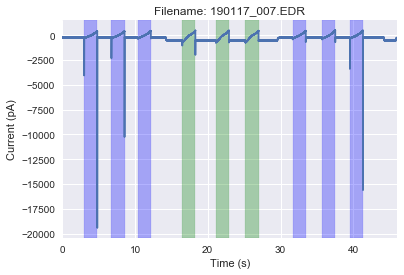

-300.0


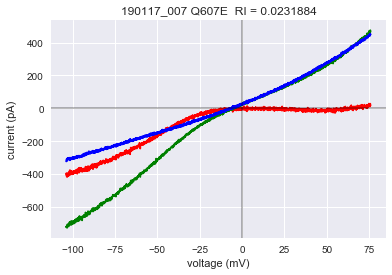

190117_007.EDR processed
total rows: 167
Processing row  157
total=  65868 start= 16000 end= 65868
Without duplicates:  [4031, 5733, 5932, 7050, 7277, 10125, 11196, 12996, 14816, 14940, 15148, 16740, 17066, 18563, 20363, 21957, 22487, 24612, 26412, 28043, 29843, 31545, 33345, 38011, 38402, 38521, 40202, 42155, 43955, 45705, 47505]
robust = [11196, 14940, 18563, 24612, 28043, 31545, 38402, 42155, 45705]
-2000.0
time len= 49868 I len= 49868


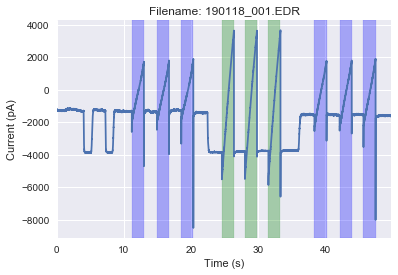

-2000.0


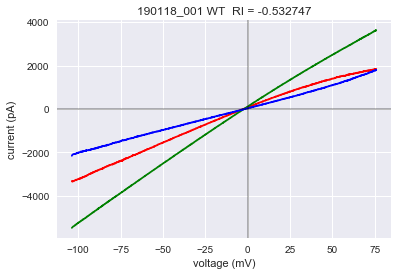

190118_001.EDR processed
total rows: 167
Processing row  158
total=  83832 start= 9000 end= 76000
Without duplicates:  [10288, 15014, 16814, 18819, 20619, 22500, 24300, 33288, 35607, 36664, 36843, 38464, 40600, 42400, 44775, 46575, 53078, 54878, 56203, 56445, 58245, 60003, 61803]
robust = [15014, 18819, 22500, 36664, 40600, 44775, 53078, 56445, 60003]
-200.0
time len= 67000 I len= 67000


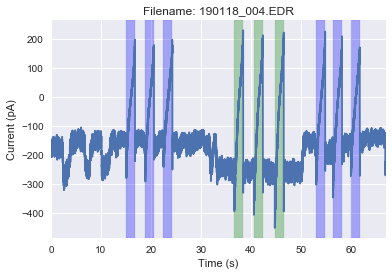

-200.0


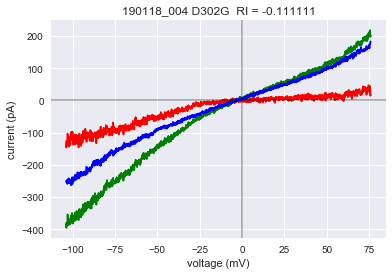

190118_004.EDR processed
total rows: 167
Processing row  159
total=  213572 start= 119000 end= 182000
Without duplicates:  [22389, 24189, 26261, 28061, 30564, 32364, 38614, 40414, 42359, 44159, 47414, 49214]
robust = [22389, 26261, 30564, 38614, 42359, 47414]
-500.0
time len= 63000 I len= 63000


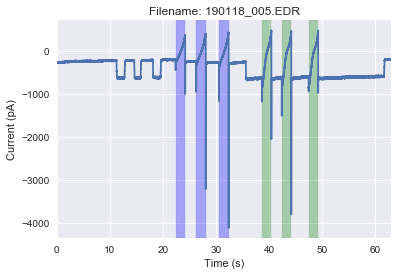

-500.0


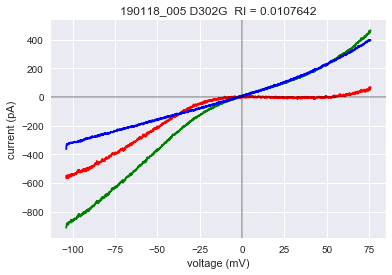

190118_005.EDR processed
total rows: 167
Processing row  160
total=  183632 start= 139000 end= 182000
Without duplicates:  [1264, 3064, 5074, 6874, 8313, 10113, 14747, 16547, 18361, 20161, 22104, 23904, 29037, 30837, 32524, 34324, 35957, 37757]
robust = [1264, 5074, 8313, 14747, 18361, 22104, 29037, 32524, 35957]
-100.0
time len= 43000 I len= 43000


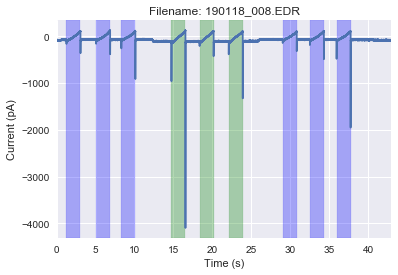

-100.0


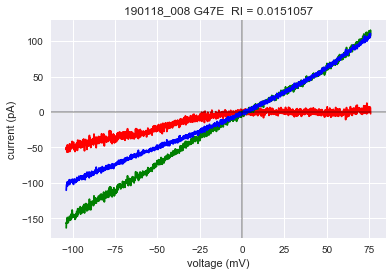

190118_008.EDR processed
total rows: 167
Processing row  161
total=  75848 start= 19000 end= 72000
Without duplicates:  [7322, 9122, 11068, 12868, 14690, 16490, 20676, 22476, 24048, 25848, 27479, 29279, 34466, 36266, 38025, 39825, 41707, 43507]
robust = [7322, 11068, 14690, 20676, 24048, 27479, 34466, 38025, 41707]
-600.0
time len= 53000 I len= 53000


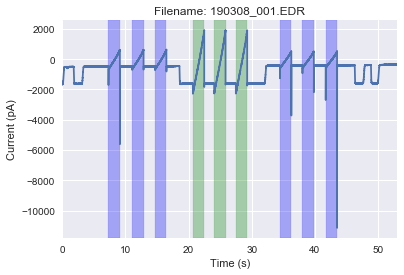

-600.0


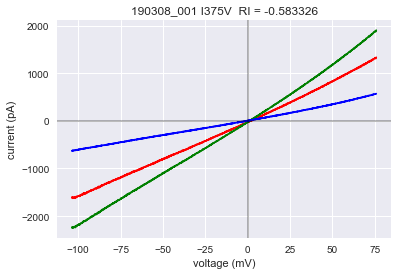

190308_001.EDR processed
total rows: 167
Processing row  162
total=  157684 start= 81000 end= 137000
Without duplicates:  [723, 8098, 9898, 11783, 13583, 15585, 17385, 23008, 24808, 28943, 30743, 32807, 34607, 41230, 43030, 44911, 46711, 48657, 50457]
robust = [8098, 11783, 15585, 23008, 28943, 32807, 41230, 44911, 48657]
-300.0
time len= 56000 I len= 56000


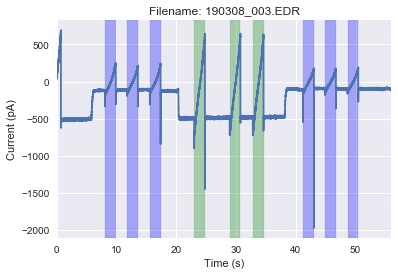

-300.0


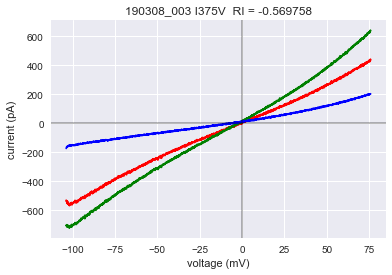

190308_003.EDR processed
total rows: 167
Processing row  163
total=  69860 start= 17000 end= 62000
Without duplicates:  [2021, 3821, 7322, 9203, 11003, 15377, 17177, 19369, 21169, 23554, 25354, 33215, 37332, 39150, 40950]
robust = [2021, 9203, 15377, 19369, 23554, 39150]
-400.0
time len= 45000 I len= 45000


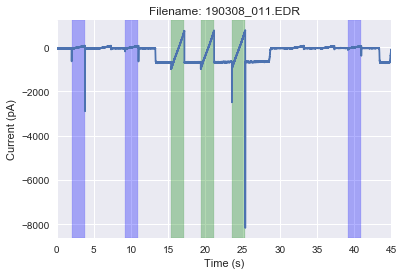

-400.0


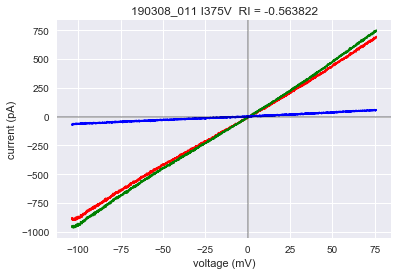

190308_011.EDR processed
total rows: 167
Processing row  164
total=  99800 start= 44000 end= 92000
Without duplicates:  [4350, 6150, 7907, 9707, 11467, 13267, 15609, 17644, 19444, 21762, 23562, 25570, 27370, 32370, 34170, 36112, 37912, 39795, 41595, 44640, 44678]
robust = [4350, 7907, 11467, 17644, 21762, 25570, 32370, 36112, 39795]
-1000.0
time len= 48000 I len= 48000


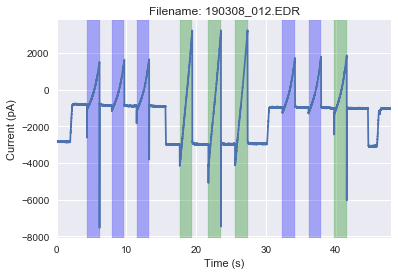

-1000.0


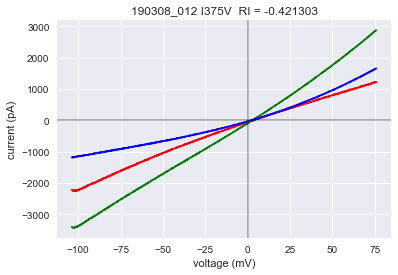

190308_012.EDR processed
total rows: 167
Processing row  165
total=  71856 start= 19000 end= 62000
Without duplicates:  [2081, 3881, 5706, 7506, 9444, 11244, 13938, 15996, 17796, 19865, 21665, 23424, 25224, 30102, 31902, 34279, 36079, 37961, 39761, 42080, 42140]
robust = [2081, 5706, 9444, 15996, 19865, 23424, 30102, 34279, 37961]
-3000.0
time len= 43000 I len= 43000


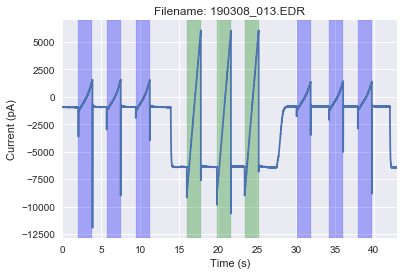

-3000.0


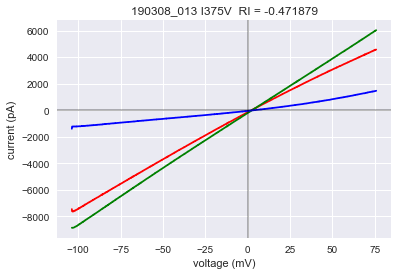

190308_013.EDR processed
total rows: 167
Processing row  166
total=  95808 start= 44000 end= 87000
Without duplicates:  [4469, 6269, 8343, 10143, 12084, 13884, 18259, 20059, 21942, 23742, 27434, 29234, 33672, 35472, 37297, 39097]
robust = [4469, 8343, 12084, 18259, 21942, 27434, 33672, 37297]
-600.0
time len= 43000 I len= 43000


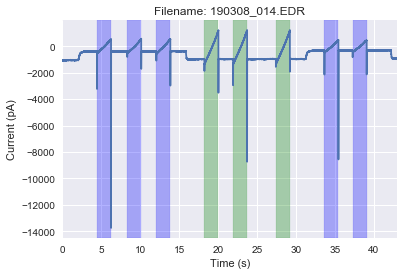

-600.0


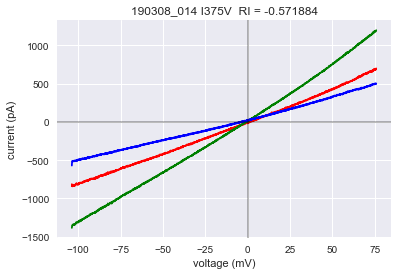

190308_014.EDR processed


In [25]:
# This needs refactoring
# Break into Process Cell independent of Batch process
# Also need to export subtracted ramp values as a csv for each cell

def batch_process(df=ramps_df, jump_threshold=50):
    df['RI'] = ''
    df['40mV I'] = ''
    df['-70mV I'] = ''
    for row in range(0, len(df)): #len(df) Remember to change this!
        print ('total rows:', len(df))
        print('Processing row ', row)
        filename = df['File'][row] + '.EDR'
        filepath = 'C:\\Users\\cdixon\\Documents\\DataSynaptopathies\\2018\\Glu\\' + filename
        
        cell = Cell(filepath, df, row)
        
        jumps = find_jumps(data=cell.I, threshold=jump_threshold)
        ramp_starts = ramp_start_robust(jumps)
        print('robust =', ramp_starts)
        drug_threshold = df['ramp threshold'][row]
        c_ramp_starts, d_ramp_starts = control_or_drug(cell.I, drug_threshold, ramp_starts) #this is not changing for the iterator
        print ('time len=', len(cell.time), 'I len=', len(cell.I))
        plot_trace(cell.time, cell.I, filename, c_ramp_starts, d_ramp_starts)
        subtracted = subtracted_ramp(cell.I, ramp_starts, drug_threshold)
        RI, pos, neg = rectification(subtracted) # 
        graph_final_ramps(cell.I, df['File'][row], df['Mutant'][row], subtracted, c_ramp_starts, d_ramp_starts, RI)#Is this really graphing new data???
        df['RI'][row] = RI
        df['40mV I'][row], = pos
        df['-70mV I'][row], = neg
        save_ramp_data(filename, cell.I, cell.time, subtracted, c_ramp_starts, d_ramp_starts)
        print(filename, 'processed')
    df.to_excel('ramps_results_Feb18.xlsx')

batch_process(df=ramps_df)

# Change the graph so that it still saves, but also outputs to a plt matrix (len(files)) then saves that as pdf.
# Make the data reader slice based on the specification file
#robust segment finder sometimes finds 2 overlapping segments. Need to skip more data points?

## Plotting data for visual inspection
User must choose threshold for control and drug periods and confirm appropriate data period.

After cutting out ramps, visually check that ramps are correctly identified, classified and averaged

In [12]:
#plot data
def plot_trace(time, I, filename, c_ramp_starts, d_ramp_starts):
    '''Plots the entire file by default.
    Ramps are highlighted if the ramp identification functions have already been run'''
    try:
        plt.plot(time, I)
    except ValueError:
        print ("ValueError while plotting")
        pass
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pA)')
    #plt.ylim(yscale) # Need to add a tuple to input
    plt.xlim(0, len(time)/1000)
    plt.title('Filename: %s' %filename)
    try:
        highlight_ramps(c_ramp_starts, color = 'b')
        highlight_ramps(d_ramp_starts, color = 'g')
    except NameError:
        pass
    return plt.show()

#Consider writing a function to identify the max and min in a sensible way? Median of the points either end of ramps?

# Remove the exceptions from the main function and add them in here

In [13]:

def find_jumps(data, threshold=50):
    '''returns a list of timepoints at which a large neg jump (amplitude defined by threshold) occured across 1ms
    Threshold needs to be a positive number, even though it is a negative jump'''
    jumps = []
    for point in range(0, len(data)-2):
        if int(data[point]) > (int(data[point+1])+threshold):
            jumps.append(point)
    # print('Found these jumps: ', jumps)
    return jumps


def ramp_start(jumps):
    '''Identify adjacent pairs of start and end coordinates for ramps of 1800ms duration
    Requires points exactly 1800ms apart'''
    x = 0
    ramps = []
    while x < len(jumps)-1:
        if jumps[x]+1800 == jumps[x+1]:
            ramps.append(jumps[x])
        x = x+1
    return(ramps)


def highlight_ramps(ramp_starts, color = 'red'):
    '''Called in graph function to give visual feedback on where the ramps are identified'''
    for r in ramp_starts:
        plt.axvspan(r/1000, (r/1000)+1.8, color = color, alpha = 0.3)


In [14]:
###
test_jumps1 = [1000, 1001, 1010, 2800, 2801, 3000, 3100, 3300, 4800]
# Test that duplicates are removed
# Should remove any value that is within 100ms of it's predecessor
# Should catch multiple close values
    
def remove_duplicate_ramps(jumps):
    '''remove adjacent jumps that are too close together to be real'''
    x = 0
    remove = []
    while x < len(jumps)-1:
        for y in range(1, (len(jumps)-x -1)):
            if jumps[x+y] < jumps[x]+100:
                remove.append(jumps[x+y])
        x = x+1
    new_jumps = []
    for x in jumps:
        if x not in remove:
            new_jumps.append(x)
    print('Without duplicates: ', new_jumps)
    return(new_jumps)

remove_duplicate_ramps(test_jumps1)

Without duplicates:  [1000, 2800, 3000, 3100, 3300, 4800]


[1000, 2800, 3000, 3100, 3300, 4800]

In [15]:
   


test_jumps2 = [1000, 2800, 3000, 3300, 4800]
# test to ensure ramps are being found and spurious values ignored
# correct return:
# [1000, 3000]
# test_jumps1 will return the same

def ramp_start_robust(jumps):
    '''Identify adjacent pairs of start and end coordinates for ramps of 1800ms duration
    Check each additional jump until run out of jumps or ramp is found'''
    jumps = remove_duplicate_ramps(jumps)
    x = 0
    ramps = []
    while x < len(jumps)-1:
        for y in range(1, (len(jumps)-x)):
            if jumps[x]+1800 == jumps[x+y]:
                ramps.append(jumps[x])
                break #Having found the end of the ramp, move to next x
            elif jumps[x]+1800 < jumps[x+y]:
                break #This x doesn't have a partner, so try the next x
            else:
                continue #May still have a partner, so keep trying more y
        x = x+1
    return(ramps)

ramp_start_robust(test_jumps1)

Without duplicates:  [1000, 2800, 3000, 3100, 3300, 4800]


[1000, 3000]

In [16]:

def control_or_drug(I, drug_threshold, ramp_starts):
    '''Pass in data as I'''
    control_ramp_starts = []
    drug_ramp_starts = []
    print(drug_threshold)
    for r in ramp_starts:
        base = I[r-20].magnitude #use the first 20ms before the ramp for the baseline. Not an average
        base = base[0]
        if base > drug_threshold:
            control_ramp_starts.append(r)
        else:
            drug_ramp_starts.append(r)
    return control_ramp_starts, drug_ramp_starts


def average_ramps(I, ramp_starts):
    '''pass in raw data as I and either drug or control ramp_starts list; will return average of those'''
    #Makes the first array before looping over the others that need averaging
    x = 1
    r = ramp_starts[0]
    av_ramp = I[r-1000:r+2800].magnitude
    for r in ramp_starts[1:]:
        #select I from r-1000 to r+2800 to catch the whole ramp
        seg = I[r-1000:r+2800].magnitude
        av_ramp = av_ramp + seg
        x = x+1
    return(av_ramp/x)


def subtracted_ramp(I, ramp_starts, drug_threshold):
    '''sorts ramps into drug category based on threshold then averages'''
    try:
        c_ramp_starts, d_ramp_starts = control_or_drug(I, drug_threshold, ramp_starts)
        subtracted = average_ramps(I, d_ramp_starts)-average_ramps(I, c_ramp_starts) 
    except IndexError:
        print ('Index error in ramps')
        subtracted = 'NaN'
    return subtracted


def graph_final_ramps(I, recordname, mutant, subtracted, c_ramp_starts, d_ramp_starts, RI):
    '''Saves and outputs plot of control drug and subtracted ramps'''
    mV_ms = 180/1800   # gradient of the ramp protocol that was used in the recording
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104   #-100 because the ramp started at -100, then also -4 to correct for LJP
    fig, ax = plt.subplots()
    plt.plot(x_mV[2:], subtracted[1002:2800], 'r')
    plt.plot(x_mV[2:], average_ramps(I, d_ramp_starts)[1002:2800], 'g')
    plt.plot(x_mV[2:], average_ramps(I, c_ramp_starts)[1002:2800], 'b')
    plt.axhline(0, color='black', alpha=0.3)
    plt.axvline(0, color='black', alpha=0.3)
    plt.xlabel('voltage (mV)')
    plt.ylabel('current (pA)')
    plt.title(recordname + ' ' + mutant + '  RI = ' + str(RI))
    save_name = recordname + 'RampGraph.pdf'
    plt.savefig(save_name, transparent=True)
    return plt.show()


def rectification(subtracted, pos=40, neg=-70):
    '''finds the ratio of currents at specified positive and negative voltages'''
    if subtracted == 'NaN':
        RI = 'NaN'
        print('Not possible to find RI')
    else:
        pos_xindex = 10*(pos+104)+1000 # *10 needed because ramp gradient is 10mV/ms. 1000 adjusts for baseline at the start
        neg_xindex = 10*(neg+104)+1000
        pos = subtracted[pos_xindex]
        neg = subtracted[neg_xindex]
        rectification_index = pos/neg
        RI = rectification_index[0]
    return RI, pos, neg
    
#rectification()

In [ ]:
'''

ramps_df = pd.read_excel('ramps_results_Oct_full.xlsx')
print(len(ramps_df))

ramps_df_Feb18 = pd.read_excel('ramps_results_Feb18.xlsx')
print(len(ramps_df_Feb18))


ramps_df = ramps_df.append(ramps_df_Feb18[ramps_df_Feb18['40mV I'].notnull()])

print(len(ramps_df))
'''

In [26]:
ramps_df.to_excel('ramps_results_Mar18_fullHet.xlsx')

In [17]:
ramps_df['Mutant'].unique()

array(['T646N', 'WT', 'GRIA1', 'A639S', 'W788L', 'G609R', 'I375V', 'F644L',
       'P528T', 'V647L', '528Del', 'G47E', 'D302G', 'Q607E', 'D611N'], dtype=object)

In [66]:
Resub_mutants = ['GRIA1','WT','G47E','D302G','P528T','528Del',
                         'Q607E','G609R','D611N','A639S','F644L', 'T646N', 'V647L',]

subplots = dict(zip(Resub_mutants,list(range(1,len(Resub_mutants)+1))))


In [67]:
#taken from GluA2 graphs, march 14th 2018

color_dict2 = {'A639S': (0.45119999999999971, 0.33999999999999997, 0.85999999999999999),
 'D302G': (0.85999999999999999, 0.61119999999999997, 0.33999999999999997),
 'D611N': (0.33999999999999997, 0.46879999999999972, 0.85999999999999999),
 'F644L': (0.69120000000000026, 0.33999999999999997, 0.85999999999999999),
 'G47E': (0.85999999999999999, 0.37119999999999997, 0.33999999999999997),
 'G609R': (0.33999999999999997, 0.70879999999999954, 0.85999999999999999),
 'P528-530Del': (0.33999999999999997,
  0.85999999999999999,
  0.53120000000000012),
 'P528T': (0.38880000000000003, 0.85999999999999999, 0.33999999999999997),
 'Q607E': (0.33999999999999997, 0.85999999999999999, 0.77120000000000011),
 'T646N': (0.85999999999999999, 0.33999999999999997, 0.78879999999999928),
 'V647L': (0.85999999999999999, 0.33999999999999997, 0.54879999999999951),
 'WT': (0.5, 0.5, 0.5),
 '—': (0.7, 0.7, 0.7)}

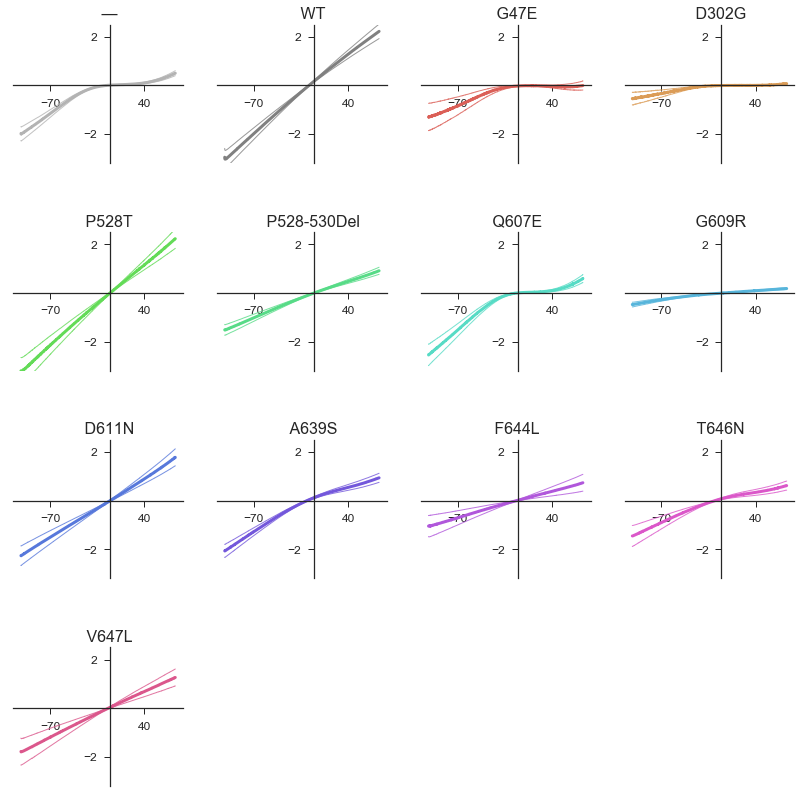

In [69]:
def graph_sub(df, m, i, fig, col, sub):
    '''Saves and outputs plot of control drug and subtracted ramps'''
    
    sns.set_style("ticks")
    ax = fig.add_subplot(4,4,sub)
    
    mV_ms = 180/1800   # gradient of the ramp protocol that was used in the recording
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104   #-100 because the ramp started at -100, then also -4 to correct for LJP
    # fig, ax = plt.subplots()

    # print(x_mV[2:].shape == df_to_plot['neg_error'].iloc[1002:2800].shape == df_to_plot['neg_error'].iloc[1002:2800].shape)
    plt.plot(x_mV[2:], df['mean'].iloc[1002:2800], color=col, lw=3)
    plt.plot(x_mV[2:], df_to_plot['pos_error'].iloc[1002:2800], color=col, alpha = 0.8, lw=1)
    plt.plot(x_mV[2:], df_to_plot['neg_error'].iloc[1002:2800], color=col, alpha = 0.8, lw=1)
    # plt.fill_between(x_mV[2:], df_to_plot['neg_error'].iloc[1002:2800], 
                     # df_to_plot['pos_error'].iloc[1002:2800], col, alpha=0.3)
    
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    plt.xticks(np.arange(-70, 100, step=110), size=12)
    plt.yticks(np.arange(-2, 2.1, step=4), size=12)
    
    plt.axhline(0, color='black', alpha=1, lw=1)
    plt.axvline(0, color='black', alpha=1, lw=1)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title('     '+m, size=16)
    plt.ylim(-3.2, 2.500)
    #save_name = m + 'Mean_sem_Ramps.pdf'
    #plt.savefig(save_name, transparent=True)
    pass



# Following analysis: plotting ramps individually for each mutant
fig = plt.figure(figsize=(14,14))

for i, m in enumerate(Resub_mutants):
    title = m + ' subtracted ramps'
    #color = pal_monochrome[m]
    df_to_plot = pd.DataFrame()
    file_list = ramps_df['File'][ramps_df['Mutant'] == m]
    for f in file_list:
        name = f + ".EDRRampSummary.csv"
        df = pd.read_csv(name)
        df_to_plot[f] = df['Subtracted']
        
    if m == 'GRIA1':
        label = '—'
    elif m == '528Del':
        label = 'P528-530Del'
    else:
        label = m
    
    data_col = df_to_plot.columns
    df_to_plot['mean'] = df_to_plot.aggregate('mean', axis=1)/1000 #convert from pA to nA
    df_to_plot['SEM'] = df_to_plot[data_col].aggregate('sem', axis=1)/1000
    df_to_plot['pos_error'] = df_to_plot['mean']+df_to_plot['SEM']
    df_to_plot['neg_error'] = df_to_plot['mean']-df_to_plot['SEM']
    
    color = color_dict2[label]
    
    graph_sub(df_to_plot, label, i, fig, col=color, sub=subplots[m])
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

plt.savefig('13rampSubplots_Mar18.pdf', transparent=True)
plt.show()


In [ ]:
# format spines

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

## Plot each ramp individually to look for abnormalities

Not usually neccessary

In [ ]:


def plot_individual_ramps(I, c_ramp_starts, d_ramp_starts, subtracted_ramp):
    '''# Extra plots to visually confirm that the subtraction is fine
        # Also helps to see time-series: are polyamines washing out?
    # Plot each of the ramps identified, based on control or drug'''
    
    x = 1

    for n in c_ramp_starts:
        plt.subplot(3, 6, x)#Need to change this to adjust to the number of control/drug traces
        plt.plot(I[n-1000:n+2800], color = 'b')
        plt.ylim(-5000, 4000)
        x += 1

    for n in d_ramp_starts:
        plt.subplot(3, 6, x)
        plt.plot(I[n-1000:n+2800], color = 'g')
        plt.ylim(-5000, 4000)
        x += 1

    n = subtracted_ramp
    plt.subplot(3,6,x)
    plt.plot(n, color = 'r')
    plt.ylim(-5000, 4000)
    plt.show()




## Spare code: Everything below here is not necessary for current functionality

In [ ]:
#plt.figure(figsize=(20,3))
#plt.plot(time[0:20000], I[0:20000])

sampling_rate = 1000

def convert(sec, sampling_rate = sampling_rate):
    '''Converts time(s) to number of samples'''
    return sec*sampling_rate

def section(from_s, to_s, sampling_rate = sampling_rate, time_array = time, data_array = I):
    '''Takes a slice of recording defined by start and end times (from_s, to_s)'''
    return(time_array[convert(from_s):convert(to_s)], data_array[convert(from_s):convert(to_s)])

def plot_section(from_s, to_s, sampling_rate = sampling_rate, time_array = time, data_array = I):
    '''Plots a section of recording defined by start and end times (from_s, to_s)'''
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pA)')
    plt.title('Filename: %s' %filename)
    return plt.plot(time_array[convert(from_s):convert(to_s)], data_array[convert(from_s):convert(to_s)])

plot_section(1, 100)


In [ ]:
#Analysing files one at a time:
filename = filepath.split('\\')[-1]
recordname = filename.split('.')[-2]

#read in file; 
#for Neo info see Garcia et al., 2014:
r = io.WinEdrIO(filename=filepath)
seg = r.read_segment(lazy=False, cascade=True,)

#make data series:
time = seg.analogsignals[0].times
I = seg.analogsignals[0]

http://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/